In [1]:
import h5py
import pylab as pl
import numpy as np
import matplotlib.cm as mpc
import matplotlib.colors as mpco
import networkx
import ipyvolume as ipv
import progressbar
import astropy.cosmology as apc
import scipy.stats as sps

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [3]:
pl.rc('font', size = 30)
pl.rc('legend', fontsize = 30)
pl.rc('axes', linewidth=1.5)

In [4]:
# sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')
# trees = networkx.read_multiline_adjlist('/data/cielo/simulations/LG1/LG1_tree.dat')
#sim = h5py.File('/disk1/data1-casona/data1/cielo/simulations/LG1/LG1.hdf5', 'r')
#trees = networkx.read_multiline_adjlist('/disk1/data1-casona/data1/cielo/simulations/LG1/LG1_tree.dat')
sim = h5py.File('/disk1/lbignone/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/disk1/lbignone/data/cielo/simulations/LG1/LG1_tree.dat')

OmegaM = sim['SnapNumber_128/Header/Omega0'][()]
Cosmo = apc.FlatLambdaCDM(H0=100, Om0=OmegaM) # H0 = 100, so all quantities are in h or /h

In [5]:
# ok, lets determine the orbital plane for one galaxy, 
ff, cc = 4474, 4469
uniqueID = int(128*1e6+ff)
stree = networkx.dfs_tree(trees, str(uniqueID))
mtree = get_main_branch_unique_ids(stree, str(uniqueID))

uniqueC = int(128*1e6+cc)
streeC = networkx.dfs_tree(trees, str(uniqueC))
mtreeC = get_main_branch_unique_ids(streeC, str(uniqueC))

x, y, z = [], [], []
for m, mC in zip(mtree, mtreeC):
    snap, ffT = split_unique_id(int(m))
    snapC, ccT = split_unique_id(int(mC))
    if snap == snapC:
        posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][ffT]
        posCen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][ccT]
        pGal = posGal-posCen
        x.append(pGal[0])
        y.append(pGal[1])
        z.append(pGal[2])
        
x, y, z = np.array(x), np.array(y), np.array(z)

In [6]:
ipv.figure(width=750, height=750)

ipv.plot(x, y, z, ls='-')

ipv.show()

In [7]:
# and by putting size by lost gas mass

def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

def get_main_branch_and_progNumb(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    numb = [[node], ]
    i = 0
    while True:
        successors = list(subtree.successors(node))
        if len(successors) == 0:
            break
        node = successors[0] # select only the first succesor (main branch)
        mpb.append(node)
        numb.append(successors)
        
    return mpb, numb


def set_view(figure, framenr, fraction):
    ipv.view(fraction*360, 0.)
    
def set_angles(fig, i, fraction):
    fig.angley = fraction*np.pi*2

# a bunch of constants
UnitMass_in_g = 1.989e+43
UnitTime_in_s = 3.08568e+16
UnitVelocity_in_cm_per_s = 100000
UnitDensity_in_cgs = 6.7699e-22
UnitEnergy_in_cgs = 1.989e+53
GAMMA_MINUS1 = 2./3.
PROTONMASS = 1.6726e-24
BOLTZMANN = 1.3806e-16    

HMass = 1.00794
FeMass = 55.845
OMass = 15.9994
NfeNhe_sun = -4.5 # grevesse & saundall 98
NoNfe_sun = 1.33 # same

def tempFromMass(Mass, Abund, IE, ne1):
    XH = Abund[:,6]/Mass
    yHelium = (1. - XH)/(4.*XH)
    mu = (1 + 4.* yHelium)/ (1.+ yHelium + ne1 )
    temp = GAMMA_MINUS1 * IE * mu * 1.6726 / 1.3806 * 1.e-8 # / BOLTZMANN  * PROTONMASS
    temp = temp * 1e10 #   UnitEnergy_in_cgs / UnitMass_in_g;
    return temp



def plotPhaseSpace(fofID, centralID):
    uniqueID = int(128*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree, numbs = get_main_branch_and_progNumb(stree, str(uniqueID))
    
    uniqueC = int(128*1e6+centralID)
    streeC = networkx.dfs_tree(trees, str(uniqueC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueC))
    
    # find all the particleIDs that once belong to the subgroup
#     Idlist, vallist, valcen = [], [], []
    Idlist, vallist = [], []
    
    for mm, mmC in zip(mtree[1:], mtreeC[1:]): # ignore the first one
        snap, idd = split_unique_id(int(mm))
        snapC, iddC = split_unique_id(int(mmC))
        tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        pgal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
        if snapC==snap:
            pcen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapC)][iddC]
        if tempOff[0]>= 0 and tempOff[1]>=0:
            tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
            Idlist.extend(list(tempIds))
            # calcule the value for color coding the graph
            #val = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
            val = snap # eso
            #IE = sim['SnapNumber_{}/PartType0/InternalEnergy'.format(snap)][tempOff[0]:tempOff[1]]
            #Mass = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][tempOff[0]:tempOff[1]]
            #Abund = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][tempOff[0]:tempOff[1]]
            #ne1 = sim['SnapNumber_{}/PartType0/ElectronAbundance'.format(snap)][tempOff[0]:tempOff[1]]
            #val = tempFromMass(Mass, Abund, IE, ne1)
            #val = sim['SnapNumber_{}/PartType0/BindingEnergy'.format(snap)][tempOff[0]:tempOff[1]]
            #val, othi = getAnglesTime(idd, iddC, snap)
            #othi, val = getAnglesTime(idd, iddC, snap)
            #val = np.abs(val)
            #L = sim['SnapNumber_{}/PartType0/SpecificAngularMomentum'.format(snap)][tempOff[0]:tempOff[1]]
            #Lt = np.sqrt(L[:,0]**2+L[:,1]**2+L[:,2]**2)
            #val = L[:,2]/Lt # Lz
            #return None
            # if val is one for each particles just append, otherwise do the next
            vallist.extend([val]*tempIds.size)
            # or
            #vallist.extend(list(val))

    Idlist, vallist = np.array(Idlist), np.array(vallist)
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    vallist = vallist[Idunique]

    # the total list of particles that once belong to a give subgroup, lest see where are today.
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
    TdayCoord = sim['SnapNumber_128/PartType0/Coordinates'][TdayOff[0]:TdayOff[1]]

    TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()]
    
    IndexToday = np.in1d(TdayTotalIDs, Idlist)
    IndexToday_ = np.where(IndexToday)[0]
    
    #remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    LostCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_]
    
    # ... and the redshift
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    vallist_, Idlist_ = vallist[iidex_], Idlist[iidex_]

    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    valorder = np.zeros(IndexT_.size)
    valorder[is1] = vallist_[is2]
    
    #now lets cut at  a certain distance
    distance = 600 # distance in ckpc

    posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][centralID]

    dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
    distToC = np.sqrt(dx**2+dy**2+dz**2)

    icut = np.where(distToC<distance)[0]
    IndexT_near = IndexT_[icut]
    valorder_near = valorder[icut]
    #IndexT_near = IndexT_
    #valorder_near = valorder
    
    #NearCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_near]
    #NearVel = sim['SnapNumber_128/PartType0/Velocities'][IndexT_near]
    NearMass = sim['SnapNumber_128/PartType0/Masses'][IndexT_near]
    
    # here i make the cut.
    return NearMass, valorder_near

In [8]:
def getVec(gal, centre, snap):
    velC = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(snap)][gal]
    posC = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][gal]
    offs = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][gal].astype('int')

#     print('nstars:',offs[1]-offs[0])
    a = sim['SnapNumber_{}/Header/Time'.format(snap)][()]

    posStars = sim['SnapNumber_{}/PartType4/Coordinates'.format(snap)][offs[0]:offs[1]]
    velStars = sim['SnapNumber_{}/PartType4/Velocities'.format(snap)][offs[0]:offs[1]]
    velStars = np.sqrt(a)*velStars

    Mass = sim['SnapNumber_{}/PartType4/Masses'.format(snap)][offs[0]:offs[1]]

    orad = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][gal]

    x, y, z = posStars[:,0] - posC[0], posStars[:,1] - posC[1], posStars[:,2] - posC[2]
    r = np.sqrt(x**2+y**2+z**2)
    ir = np.where(r<orad)[0]

    x, y, z = x[ir], y[ir], z[ir]

    velStars = velStars[ir]
    vx, vy, vz = velStars[:,0] - velC[0], velStars[:,1] - velC[1], velStars[:,2] - velC[2]

    Mass = Mass[ir]

    Lx, Ly, Lz = [], [], []

    for xi, yi, zi, vxi, vyi, vzi in zip(x, y, z, vx, vy, vz):
        rp = np.array([xi, yi, zi])
        rv = np.array([vxi, vyi, vzi])
        l = np.cross(rp, rv)
        Lx.append(l[0])
        Ly.append(l[1])
        Lz.append(l[2])

    Lx, Ly, Lz = np.array(Lx), np.array(Ly), np.array(Lz)

    Ltot = np.array([np.sum(Mass*Lx), np.sum(Mass*Ly), np.sum(Mass*Lz)])
    Lnorm = Ltot/np.sqrt(np.sum(Ltot**2.))

    ipro = []
    ii = 0
    for lx, ly, lz in zip(Lx, Ly, Lz):
        lnormi = np.array([lx, ly, lz])/np.sqrt(lx**2+ly**2+lz**2) 
        ddot = np.dot(lnormi, Lnorm)
        if ddot>0:
            ipro.append(ii)
        ii += 1

    Ltot = np.array([np.sum(Mass[ipro]*Lx[ipro]), np.sum(Mass[ipro]*Ly[ipro]), np.sum(Mass[ipro]*Lz[ipro])])
    Lnorm = Ltot/np.sqrt(np.sum(Ltot**2.))
    
    return Lnorm, Ltot


def getAnglesTime(gal, centre, snap):
    offGas = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][gal].astype('int')
#     RotMass = sim['SnapNumber_{}/SubGroups/PartType4/RotationMatrix'.format(snap)][gal]
    cenGas = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][gal]
#     RotII = RotMass.T
#     R = np.array([0., 0., 1.])
#     R_rot = np.dot(RotII, R.T).T
    R_rot, LzM = getVec(gal, centre, snap)
    
    velGal = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(snap)][gal]
    cenGro = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][centre]
    velGro = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(snap)][centre]
    
    vecCen = cenGro - cenGas
    vecVel = velGal - velGro
    
    x, y, z = cenGas[0]-cenGro[0], cenGas[1]-cenGro[1], cenGas[2]-cenGro[2]
    
    sep = np.sqrt(np.sum(vecCen**2))
    
    gro = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][centre]
    R200 = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][gro]
    
    sepr200 = sep/R200
    
    vecCenN = vecCen/sep
    vecVelN = vecVel/np.sqrt(np.sum(vecVel**2.))
    
    # and cosines
    cosCen = np.dot(R_rot, vecCenN)
    cosVel = np.dot(R_rot, vecVelN)
    
#     Ls = sim['SnapNumber_{}/PartType4/SpecificAngularMomentum'.format(snap)][offGas[0]:offGas[1]]
#     Lz = Ls[:,2]
#     L = np.sqrt(Ls[:,0]**2+Ls[:,1]**2+Ls[:,2]**2)
#     LzL = Lz/L
    
#     ii = np.where(np.isnan(LzL)==False)
#     LzL = LzL[ii]
    
#     LzM = np.mean(LzL)
    
    return R_rot, LzM, sepr200, x, y, z

# the new one, just the part that do not work

def getTime_withMass(ff, cc, number=100):
    uniqueID = int(128*1e6+ff)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    # and the centre
    uniqueIDC = int(128*1e6+cc)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
    VecRot, LZ, dist = [], [], []
    z, snaplist, mass = [], [], []
    X, Y, Z = [], [], []
    LostMasses, snapMasses = plotPhaseSpace(ff, cc) # all masses at all z.
    
    for mm, mmC in zip(mtree, mtreeC):
        snap, ffT = split_unique_id(int(mm))
        snapC, ccT = split_unique_id(int(mmC))
        if snap==snapC:
            Off = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][ffT].astype('int')
            Np = Off[1]-Off[0]
            if Np>number:
                # and masses
                imasses = np.where(snapMasses==snap)
                ThisMasses = LostMasses[imasses]
                sMass = np.sum(ThisMasses)
                mass.append(sMass)
                
                R_rot, LzT, distT, xt, yt, zt = getAnglesTime(ffT, ccT, snap)
                VecRot.append(R_rot)
                LZ.append(LzT)
                dist.append(distT)
                zi = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
                z.append(zi)
                snaplist.append(snap)
                X.append(xt)
                Y.append(yt)
                Z.append(zt)

    VecRot, LZ, dist = np.array(VecRot), np.array(LZ), np.array(dist)
    z, snaplist = np.array(z), np.array(snaplist)
    mass = np.array(mass)
    X, Y, Z = np.array(X), np.array(Y), np.array(Z)
    
    return VecRot, LZ, dist, z, snaplist, mass, X, Y, Z


def getProfiles(ff, cc, nbin):
    uniqueID = int(128*1e6+ff)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    # and the centre
    uniqueIDC = int(128*1e6+cc)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
    ropt = sim['SnapNumber_128/SubGroups/OpticalRadius'][ff]
    
    MassPro, FeHPro, OFePro, AgePro, dist = [], [], [], [], []
    Times = []
    group = sim['SnapNumber_128/SubGroups/GroupNumber'][cc]
    R200 =  sim['SnapNumber_128/Groups/Group_R_Crit200'][group]
    
    for mm, mmC in zip(mtree, mtreeC):
        snap, ffT = split_unique_id(int(mm))
        snapC, ccT = split_unique_id(int(mmC))
        if snap==snapC:
            PosGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][ffT]
            PosCen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][ccT]
            rDist = np.sqrt(np.sum((PosGal-PosCen)**2.))
            if rDist<2*R200:
                dist.append(rDist)
                
                Off = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][ffT].astype('int')
                R_rot, Lsum = getVec(ffT, ccT, snap)
                posStars = sim['SnapNumber_{}/PartType4/Coordinates'.format(snap)][Off[0]:Off[1]]
                
                f = (1-R_rot[0])/(R_rot[1]**2 + R_rot[2]**2)
                R1 = np.array([[0, R_rot[1], R_rot[2]], [-R_rot[1], 0, 0], [-R_rot[2], 0, 0]])
                R2 = np.matmul(R1, R1)
                
                RM = np.identity(3) + R1 + R2*f

                p_POSu = posStars - PosGal
                
                RotPos = np.matmul(RM, p_POSu.T)

                RR = np.sqrt(RotPos[1]**2+RotPos[2]**2)
                
                Abund = sim['SnapNumber_{}/PartType4/Abundances'.format(snap)][Off[0]:Off[1]]
                TFeH = np.log10((Abund[:,4]/FeMass)/(Abund[:,6]/HMass)) - NfeNhe_sun
                TOFe = np.log10((Abund[:,3]/OMass)/(Abund[:,4]/FeMass)) - NoNfe_sun
    
                ife = np.where((np.isnan(TFeH)==False) & (np.isinf(TFeH)==False))
                io = np.where((np.isnan(TOFe)==False) & (np.isinf(TOFe)==False))
    
                TFeH = TFeH[ife]
                TOFe = TOFe[io]
            
                Masses = sim['SnapNumber_{}/PartType4/Masses'.format(snap)][Off[0]:Off[1]]
                Ages = sim['SnapNumber_{}/PartType4/StellarFormationTime'.format(snap)][Off[0]:Off[1]]
                
                zform = (1./Ages)-1.
                Yform = Cosmo.lookback_time(zform).value
                
                z = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
                timenow = Cosmo.lookback_time(z).value
                
                Yform = Yform - timenow # at this redshift
                
                SMass, xbins, dc = sps.binned_statistic(RR, Masses, statistic='sum', bins=nbin, range=(0, 1.5*ropt))
                Areas = np.pi*(xbins[1:]**2.-xbins[:-1]**2.)
                Sigmas = SMass*1e10/Areas # Msun/kpc^2 h i think
                
                SAges, xbins, dc = sps.binned_statistic(RR, Yform, statistic='median', bins=nbin, range=(0, 1.5*ropt))
                SFeH, xbins, dc = sps.binned_statistic(RR[ife], TFeH, statistic='median', bins=nbin, range=(0, 1.5*ropt))
                SOFe, xbins, dc = sps.binned_statistic(RR[io], TOFe, statistic='median', bins=nbin, range=(0, 1.5*ropt))
                
                Times.append(timenow)
                
                MassPro.append(Sigmas)
                FeHPro.append(SFeH)
                OFePro.append(SOFe)
                AgePro.append(SAges)
    
    xaxis = 0.5*(xbins[1:] + xbins[:-1])
    
    dist = np.array(dist)
    t = np.where(dist<=R200)[0]
    t1 = t.max()
    
    MassPro = np.array(MassPro)
    FeHPro = np.array(FeHPro)
    OFePro = np.array(OFePro)
    AgePro = np.array(AgePro)
    
    Times = np.array(Times)
    
    return xaxis, MassPro, FeHPro, OFePro, AgePro, Times, t1

In [9]:
# ff, cc = 4338, 4337
# xaxis_4338, MassPro_4338, FeHPro_4338, OFePro_4338, AgePro_4338, Times_4338, t1_4338 = getProfiles(ff, cc, 30)

In [10]:
# pl.figure(figsize=(14, 14))

# I = np.arange(Times_4338.size)

# cmap = mpc.viridis
# norm = pl.Normalize(Times_4338.min(), Times_4338.max())


# for md, tm, i in zip(MassPro_4338, Times_4338, I):
#     if i != t1_4338:
#         pl.plot(xaxis_4338, md, color=cmap(norm(tm)), ls=':')
#     else:
#         pl.plot(xaxis_4338, md, color=cmap(norm(tm)), ls='-', lw=3)
    
# pl.semilogy()
# pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )

# pl.xlabel('$r/$(kpc h$^{-1}$)')
# pl.ylabel('$\Sigma_{\star}/(M_{\odot}$ kpc$^{-2} h$)')

# xlim = pl.xlim()
# ylim = pl.ylim()

# deltax = xlim[1]-xlim[0]
# deltay = ylim[1]-ylim[0]

# pl.text(xlim[0]+deltax/20., ylim[0]+deltay/1e4, 'g{}'.format(ff))

# pl.figure(figsize=(14, 14))

# for md, tm, i in zip(AgePro_4338, Times_4338, I):
#     if i != t1_4338:
#         pl.plot(xaxis_4338, np.log10(md)+9., color=cmap(norm(tm)), ls=':')
#     else:
#         pl.plot(xaxis_4338, np.log10(md)+9., color=cmap(norm(tm)), ls='-', lw=3)
    
# # pl.semilogy()
# pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )

# pl.xlabel('$r/$(kpc h$^{-1}$)')
# # pl.ylabel('Age$_{\star}$/(Gyrs h$^{-1}$)')
# pl.ylabel('log(Age$_{\star}$/(yr h$^{-1}$))')

# xlim = pl.xlim()
# ylim = pl.ylim()

# deltax = xlim[1]-xlim[0]
# deltay = ylim[1]-ylim[0]

# pl.text(xlim[0]+deltax/20., ylim[0]+deltay/1e2, 'g{}'.format(ff))


# pl.figure(figsize=(14, 14))

# for md, tm, i in zip(FeHPro_4338, Times_4338, I):
#     if i != t1_4338:
#         pl.plot(xaxis_4338, md, color=cmap(norm(tm)), ls=':')
#     else:
#         pl.plot(xaxis_4338, md, color=cmap(norm(tm)), ls='-', lw=3)
    
# pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )

# pl.xlabel('$r/$(kpc h$^{-1}$)')
# pl.ylabel('[Fe/H]$_{\star}$')

# xlim = pl.xlim()
# ylim = pl.ylim()

# deltax = xlim[1]-xlim[0]
# deltay = ylim[1]-ylim[0]

# pl.text(xlim[0]+deltax/20., ylim[0]+deltay/10, 'g{}'.format(ff))


# pl.figure(figsize=(14, 14))

# for md, tm, i in zip(OFePro_4338, Times_4338, I):
#     if i != t1_4338:
#         pl.plot(xaxis_4338, md, color=cmap(norm(tm)), ls=':')
#     else:
#         pl.plot(xaxis_4338, md, color=cmap(norm(tm)), ls='-', lw=3)
    
# pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )

# pl.xlabel('$r/$(kpc h$^{-1}$)')
# pl.ylabel('[O/Fe]$_{\star}$')

# xlim = pl.xlim()
# ylim = pl.ylim()

# deltax = xlim[1]-xlim[0]
# deltay = ylim[1]-ylim[0]

# pl.text(xlim[0]+deltax/20., ylim[0]+deltay/10, 'g{}'.format(ff))

In [11]:
# ff, cc = 4339, 4337
# xaxis_4339, MassPro_4339, FeHPro_4339, OFePro_4339, AgePro_4339, Times_4339, t1_4339 = getProfiles(ff, cc, 30)

# pl.figure(figsize=(14, 14))

# I = np.arange(Times_4339.size)

# cmap = mpc.viridis
# norm = pl.Normalize(Times_4339.min(), Times_4339.max())


# for md, tm, i in zip(MassPro_4339, Times_4339, I):
#     if i != t1_4339:
#         pl.plot(xaxis_4339, md, color=cmap(norm(tm)), ls=':')
#     else:
#         pl.plot(xaxis_4339, md, color=cmap(norm(tm)), ls='-', lw=3)
    
# pl.semilogy()
# pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )

# pl.xlabel('$r/$(kpc h$^{-1}$)')
# pl.ylabel('$\Sigma_{\star}/(M_{\odot}$ kpc$^{-2} h$)')

# xlim = pl.xlim()
# ylim = pl.ylim()

# deltax = xlim[1]-xlim[0]
# deltay = ylim[1]-ylim[0]

# pl.text(xlim[0]+deltax/20., ylim[0]+deltay/1e4, 'g{}'.format(ff))

# pl.figure(figsize=(14, 14))

# for md, tm, i in zip(AgePro_4339, Times_4339, I):
#     if i != t1_4339:
#         pl.plot(xaxis_4339, np.log10(md)+9., color=cmap(norm(tm)), ls=':')
#     else:
#         pl.plot(xaxis_4339, np.log10(md)+9., color=cmap(norm(tm)), ls='-', lw=3)
    
# # pl.semilogy()
# pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )

# pl.xlabel('$r/$(kpc h$^{-1}$)')
# # pl.ylabel('Age$_{\star}$/(Gyrs h$^{-1}$)')
# pl.ylabel('log(Age$_{\star}$/(yr h$^{-1}$))')

# xlim = pl.xlim()
# ylim = pl.ylim()

# deltax = xlim[1]-xlim[0]
# deltay = ylim[1]-ylim[0]

# pl.text(xlim[0]+deltax/20., ylim[0]+deltay/1e2, 'g{}'.format(ff))

# pl.figure(figsize=(14, 14))

# for md, tm, i in zip(FeHPro_4339, Times_4339, I):
#     if i != t1_4339:
#         pl.plot(xaxis_4339, md, color=cmap(norm(tm)), ls=':')
#     else:
#         pl.plot(xaxis_4339, md, color=cmap(norm(tm)), ls='-', lw=3)
    
# pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )

# pl.xlabel('$r/$(kpc h$^{-1}$)')
# pl.ylabel('[Fe/H]$_{\star}$')

# xlim = pl.xlim()
# ylim = pl.ylim()

# deltax = xlim[1]-xlim[0]
# deltay = ylim[1]-ylim[0]

# pl.text(xlim[0]+deltax/20., ylim[0]+deltay/10, 'g{}'.format(ff))

# pl.figure(figsize=(14, 14))

# for md, tm, i in zip(OFePro_4339, Times_4339, I):
#     if i != t1_4339:
#         pl.plot(xaxis_4339, md, color=cmap(norm(tm)), ls=':')
#     else:
#         pl.plot(xaxis_4339, md, color=cmap(norm(tm)), ls='-', lw=3)
    
# pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )

# pl.xlabel('$r/$(kpc h$^{-1}$)')
# pl.ylabel('[O/Fe]$_{\star}$')

# xlim = pl.xlim()
# ylim = pl.ylim()

# deltax = xlim[1]-xlim[0]
# deltay = ylim[1]-ylim[0]

# pl.text(xlim[0]+deltax/20., ylim[0]+deltay/10, 'g{}'.format(ff))

In [12]:
# ff, cc = 4341, 4337
# xaxis_4341, MassPro_4341, FeHPro_4341, OFePro_4341, AgePro_4341, Times_4341, t1_4341 = getProfiles(ff, cc, 30)

# pl.figure(figsize=(14, 14))

# I = np.arange(Times_4341.size)

# cmap = mpc.viridis
# norm = pl.Normalize(Times_4341.min(), Times_4341.max())


# for md, tm, i in zip(MassPro_4341, Times_4341, I):
#     if i != t1_4341:
#         pl.plot(xaxis_4341, md, color=cmap(norm(tm)), ls=':')
#     else:
#         pl.plot(xaxis_4341, md, color=cmap(norm(tm)), ls='-', lw=3)
    
# pl.semilogy()
# pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )

# pl.xlabel('$r/$(kpc h$^{-1}$)')
# pl.ylabel('$\Sigma_{\star}/(M_{\odot}$ kpc$^{-2} h$)')

# xlim = pl.xlim()
# ylim = pl.ylim()

# deltax = xlim[1]-xlim[0]
# deltay = ylim[1]-ylim[0]

# pl.text(xlim[0]+deltax/20., ylim[0]+deltay/1e4, 'g{}'.format(ff))

# pl.figure(figsize=(14, 14))

# for md, tm, i in zip(AgePro_4341, Times_4341, I):
#     if i != t1_4341:
#         pl.plot(xaxis_4341, np.log10(md)+9., color=cmap(norm(tm)), ls=':')
#     else:
#         pl.plot(xaxis_4341, np.log10(md)+9., color=cmap(norm(tm)), ls='-', lw=3)
    
# # pl.semilogy()
# pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )

# pl.xlabel('$r/$(kpc h$^{-1}$)')
# # pl.ylabel('Age$_{\star}$/(Gyrs h$^{-1}$)')
# pl.ylabel('log(Age$_{\star}$/(yr h$^{-1}$))')

# xlim = pl.xlim()
# ylim = pl.ylim()

# deltax = xlim[1]-xlim[0]
# deltay = ylim[1]-ylim[0]

# pl.text(xlim[0]+deltax/20., ylim[0]+deltay/1e2, 'g{}'.format(ff))

# pl.figure(figsize=(14, 14))

# for md, tm, i in zip(FeHPro_4341, Times_4341, I):
#     if i != t1_4341:
#         pl.plot(xaxis_4341, md, color=cmap(norm(tm)), ls=':')
#     else:
#         pl.plot(xaxis_4341, md, color=cmap(norm(tm)), ls='-', lw=3)
    
# pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )

# pl.xlabel('$r/$(kpc h$^{-1}$)')
# pl.ylabel('[Fe/H]$_{\star}$')

# xlim = pl.xlim()
# ylim = pl.ylim()

# deltax = xlim[1]-xlim[0]
# deltay = ylim[1]-ylim[0]

# pl.text(xlim[0]+deltax/20., ylim[0]+deltay/10, 'g{}'.format(ff))

# pl.figure(figsize=(14, 14))

# for md, tm, i in zip(OFePro_4341, Times_4341, I):
#     if i != t1_4341:
#         pl.plot(xaxis_4341, md, color=cmap(norm(tm)), ls=':')
#     else:
#         pl.plot(xaxis_4341, md, color=cmap(norm(tm)), ls='-', lw=3)
    
# pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )

# pl.xlabel('$r/$(kpc h$^{-1}$)')
# pl.ylabel('[O/Fe]$_{\star}$')

# xlim = pl.xlim()
# ylim = pl.ylim()

# deltax = xlim[1]-xlim[0]
# deltay = ylim[1]-ylim[0]

# pl.text(xlim[0]+deltax/20., ylim[0]+deltay/10, 'g{}'.format(ff))

In [13]:
# ff, cc = 4343, 4337
# xaxis_4343, MassPro_4343, FeHPro_4343, OFePro_4343, AgePro_4343, Times_4343, t1_4343 = getProfiles(ff, cc, 30)

# pl.figure(figsize=(14, 14))

# I = np.arange(Times_4343.size)

# cmap = mpc.viridis
# norm = pl.Normalize(Times_4343.min(), Times_4343.max())


# for md, tm, i in zip(MassPro_4343, Times_4343, I):
#     if i != t1_4343:
#         pl.plot(xaxis_4343, md, color=cmap(norm(tm)), ls=':')
#     else:
#         pl.plot(xaxis_4343, md, color=cmap(norm(tm)), ls='-', lw=3)
    
# pl.semilogy()
# pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )

# pl.xlabel('$r/$(kpc h$^{-1}$)')
# pl.ylabel('$\Sigma_{\star}/(M_{\odot}$ kpc$^{-2} h$)')

# xlim = pl.xlim()
# ylim = pl.ylim()

# deltax = xlim[1]-xlim[0]
# deltay = ylim[1]-ylim[0]

# pl.text(xlim[0]+deltax/20., ylim[0]+deltay/1e4, 'g{}'.format(ff))

# pl.figure(figsize=(14, 14))

# for md, tm, i in zip(AgePro_4343, Times_4343, I):
#     if i != t1_4343:
#         pl.plot(xaxis_4343, np.log10(md)+9., color=cmap(norm(tm)), ls=':')
#     else:
#         pl.plot(xaxis_4343, np.log10(md)+9., color=cmap(norm(tm)), ls='-', lw=3)
    
# # pl.semilogy()
# pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )

# pl.xlabel('$r/$(kpc h$^{-1}$)')
# # pl.ylabel('Age$_{\star}$/(Gyrs h$^{-1}$)')
# pl.ylabel('log(Age$_{\star}$/(yr h$^{-1}$))')

# xlim = pl.xlim()
# ylim = pl.ylim()

# deltax = xlim[1]-xlim[0]
# deltay = ylim[1]-ylim[0]

# pl.text(xlim[0]+deltax/20., ylim[0]+deltay/1e2, 'g{}'.format(ff))

# pl.figure(figsize=(14, 14))

# for md, tm, i in zip(FeHPro_4343, Times_4343, I):
#     if i != t1_4343:
#         pl.plot(xaxis_4343, md, color=cmap(norm(tm)), ls=':')
#     else:
#         pl.plot(xaxis_4343, md, color=cmap(norm(tm)), ls='-', lw=3)
    
# pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )

# pl.xlabel('$r/$(kpc h$^{-1}$)')
# pl.ylabel('[Fe/H]$_{\star}$')

# xlim = pl.xlim()
# ylim = pl.ylim()

# deltax = xlim[1]-xlim[0]
# deltay = ylim[1]-ylim[0]

# pl.text(xlim[0]+deltax/20., ylim[0]+deltay/10, 'g{}'.format(ff))

# pl.figure(figsize=(14, 14))

# for md, tm, i in zip(OFePro_4343, Times_4343, I):
#     if i != t1_4343:
#         pl.plot(xaxis_4343, md, color=cmap(norm(tm)), ls=':')
#     else:
#         pl.plot(xaxis_4343, md, color=cmap(norm(tm)), ls='-', lw=3)
    
# pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )

# pl.xlabel('$r/$(kpc h$^{-1}$)')
# pl.ylabel('[O/Fe]$_{\star}$')

# xlim = pl.xlim()
# ylim = pl.ylim()

# deltax = xlim[1]-xlim[0]
# deltay = ylim[1]-ylim[0]

# pl.text(xlim[0]+deltax/20., ylim[0]+deltay/10, 'g{}'.format(ff))

In [14]:
# the other one



In [15]:
# ff, cc = 4470, 4469
# xaxis_4470, MassPro_4470, FeHPro_4470, OFePro_4470, AgePro_4470, Times_4470, t1_4470 = getProfiles(ff, cc, 30)

# nsnaps = np.arange(128, 30, -1)
# imerger = np.where(nsnaps==101)[0] # hardcoded

# zmerger = sim['SnapNumber_101/Header/Redshift'][()]
# tmerger = Cosmo.lookback_time(zmerger).value

# pl.figure(figsize=(14, 14))

# I = np.arange(Times_4470.size)

# cmap = mpc.viridis
# norm = pl.Normalize(Times_4470.min(), Times_4470.max())

# for md, tm, i in zip(MassPro_4470, Times_4470, I):
#     if i == t1_4470:
#         pl.plot(xaxis_4470, md, color=cmap(norm(tm)), ls='-', lw=3)
#     elif i == imerger:
#         pl.plot(xaxis_4470, md, color='red', ls='--', lw=3)
#     else:
#         pl.plot(xaxis_4470, md, color=cmap(norm(tm)), ls=':')
    
# pl.semilogy()
# cb = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
# cb.ax.plot([0, 100], [tmerger]*2, ls='--', color='red', lw=3)

# pl.xlabel('$r/$(kpc h$^{-1}$)')
# pl.ylabel('$\Sigma_{\star}/(M_{\odot}$ kpc$^{-2} h$)')

# xlim = pl.xlim()
# ylim = pl.ylim()

# deltax = xlim[1]-xlim[0]
# deltay = ylim[1]-ylim[0]

# pl.text(xlim[0]+deltax/20., ylim[0]+deltay/1e4, 'g{}'.format(ff))

# pl.figure(figsize=(14, 14))

# for md, tm, i in zip(AgePro_4470, Times_4470, I):
#     if i == t1_4470:
#         pl.plot(xaxis_4470, np.log10(md)+9., color=cmap(norm(tm)), ls='-', lw=3)
#     elif i==imerger:
#         pl.plot(xaxis_4470, np.log10(md)+9., color='red', ls='--', lw=3)
#     else:
#         pl.plot(xaxis_4470, np.log10(md)+9., color=cmap(norm(tm)), ls=':')
    
# # pl.semilogy()
# cb = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
# cb.ax.plot([0, 100], [tmerger]*2, ls='--', color='red', lw=3)

# pl.xlabel('$r/$(kpc h$^{-1}$)')
# # pl.ylabel('Age$_{\star}$/(Gyrs h$^{-1}$)')
# pl.ylabel('log(Age$_{\star}$/(yr h$^{-1}$))')

# xlim = pl.xlim()
# ylim = pl.ylim()

# deltax = xlim[1]-xlim[0]
# deltay = ylim[1]-ylim[0]

# pl.text(xlim[0]+deltax/20., ylim[0]+deltay/1e2, 'g{}'.format(ff))

# pl.figure(figsize=(14, 14))

# for md, tm, i in zip(FeHPro_4470, Times_4470, I):
#     if i == t1_4470:
#         pl.plot(xaxis_4470, md, color=cmap(norm(tm)), ls='-', lw=3)
#     elif i == imerger:
#         pl.plot(xaxis_4470, md, color='red', ls='--', lw=3)
#     else:
#         pl.plot(xaxis_4470, md, color=cmap(norm(tm)), ls=':')
    
# cb = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
# cb.ax.plot([0, 100], [tmerger]*2, ls='--', color='red', lw=3)

# pl.xlabel('$r/$(kpc h$^{-1}$)')
# pl.ylabel('[Fe/H]$_{\star}$')

# xlim = pl.xlim()
# ylim = pl.ylim()

# deltax = xlim[1]-xlim[0]
# deltay = ylim[1]-ylim[0]

# pl.text(xlim[0]+deltax/20., ylim[0]+deltay/10, 'g{}'.format(ff))

# pl.figure(figsize=(14, 14))

# for md, tm, i in zip(OFePro_4470, Times_4470, I):
#     if i == t1_4470:
#         pl.plot(xaxis_4470, md, color=cmap(norm(tm)), ls='-', lw=3)
#     elif i == imerger:
#         pl.plot(xaxis_4470, md, color='red', ls='--', lw=3)
#     else:
#         pl.plot(xaxis_4470, md, color=cmap(norm(tm)), ls=':')
    
# cb = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
# cb.ax.plot([0, 100], [tmerger]*2, ls='--', color='red', lw=3)


# pl.xlabel('$r/$(kpc h$^{-1}$)')
# pl.ylabel('[O/Fe]$_{\star}$')

# xlim = pl.xlim()
# ylim = pl.ylim()

# deltax = xlim[1]-xlim[0]
# deltay = ylim[1]-ylim[0]

# pl.text(xlim[0]+deltax/20., ylim[0]+deltay/10, 'g{}'.format(ff))

In [16]:
# ff, cc = 4471, 4469
# xaxis_4471, MassPro_4471, FeHPro_4471, OFePro_4471, AgePro_4471, Times_4471, t1_4471 = getProfiles(ff, cc, 30)

# pl.figure(figsize=(14, 14))

# I = np.arange(Times_4471.size)

# cmap = mpc.viridis
# norm = pl.Normalize(Times_4471.min(), Times_4471.max())


# for md, tm, i in zip(MassPro_4471, Times_4471, I):
#     if i != t1_4471:
#         pl.plot(xaxis_4471, md, color=cmap(norm(tm)), ls=':')
#     else:
#         pl.plot(xaxis_4471, md, color=cmap(norm(tm)), ls='-', lw=3)
    
# pl.semilogy()
# pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )

# pl.xlabel('$r/$(kpc h$^{-1}$)')
# pl.ylabel('$\Sigma_{\star}/(M_{\odot}$ kpc$^{-2} h$)')

# xlim = pl.xlim()
# ylim = pl.ylim()

# deltax = xlim[1]-xlim[0]
# deltay = ylim[1]-ylim[0]

# pl.text(xlim[0]+deltax/20., ylim[0]+deltay/1e4, 'g{}'.format(ff))

# pl.figure(figsize=(14, 14))

# for md, tm, i in zip(AgePro_4471, Times_4471, I):
#     if i != t1_4471:
#         pl.plot(xaxis_4471, np.log10(md)+9., color=cmap(norm(tm)), ls=':')
#     else:
#         pl.plot(xaxis_4471, np.log10(md)+9., color=cmap(norm(tm)), ls='-', lw=3)
    
# # pl.semilogy()
# pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )

# pl.xlabel('$r/$(kpc h$^{-1}$)')
# # pl.ylabel('Age$_{\star}$/(Gyrs h$^{-1}$)')
# pl.ylabel('log(Age$_{\star}$/(yr h$^{-1}$))')

# xlim = pl.xlim()
# ylim = pl.ylim()

# deltax = xlim[1]-xlim[0]
# deltay = ylim[1]-ylim[0]

# pl.text(xlim[0]+deltax/20., ylim[0]+deltay/1e2, 'g{}'.format(ff))

# pl.figure(figsize=(14, 14))

# for md, tm, i in zip(FeHPro_4471, Times_4471, I):
#     if i != t1_4471:
#         pl.plot(xaxis_4471, md, color=cmap(norm(tm)), ls=':')
#     else:
#         pl.plot(xaxis_4471, md, color=cmap(norm(tm)), ls='-', lw=3)
    
# pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )

# pl.xlabel('$r/$(kpc h$^{-1}$)')
# pl.ylabel('[Fe/H]$_{\star}$')

# xlim = pl.xlim()
# ylim = pl.ylim()

# deltax = xlim[1]-xlim[0]
# deltay = ylim[1]-ylim[0]

# pl.text(xlim[0]+deltax/20., ylim[0]+deltay/10, 'g{}'.format(ff))

# pl.figure(figsize=(14, 14))

# for md, tm, i in zip(OFePro_4471, Times_4471, I):
#     if i != t1_4471:
#         pl.plot(xaxis_4471, md, color=cmap(norm(tm)), ls=':')
#     else:
#         pl.plot(xaxis_4471, md, color=cmap(norm(tm)), ls='-', lw=3)
    
# pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )

# pl.xlabel('$r/$(kpc h$^{-1}$)')
# pl.ylabel('[O/Fe]$_{\star}$')

# xlim = pl.xlim()
# ylim = pl.ylim()

# deltax = xlim[1]-xlim[0]
# deltay = ylim[1]-ylim[0]

# pl.text(xlim[0]+deltax/20., ylim[0]+deltay/10, 'g{}'.format(ff))

In [17]:
# ff, cc = 4473, 4469
# xaxis_4473, MassPro_4473, FeHPro_4473, OFePro_4473, AgePro_4473, Times_4473, t1_4473 = getProfiles(ff, cc, 30)

# pl.figure(figsize=(14, 14))

# I = np.arange(Times_4473.size)

# cmap = mpc.viridis
# norm = pl.Normalize(Times_4473.min(), Times_4473.max())


# for md, tm, i in zip(MassPro_4473, Times_4473, I):
#     if i != t1_4473:
#         pl.plot(xaxis_4473, md, color=cmap(norm(tm)), ls=':')
#     else:
#         pl.plot(xaxis_4473, md, color=cmap(norm(tm)), ls='-', lw=3)
    
# pl.semilogy()
# pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )

# pl.xlabel('$r/$(kpc h$^{-1}$)')
# pl.ylabel('$\Sigma_{\star}/(M_{\odot}$ kpc$^{-2} h$)')

# xlim = pl.xlim()
# ylim = pl.ylim()

# deltax = xlim[1]-xlim[0]
# deltay = ylim[1]-ylim[0]

# pl.text(xlim[0]+deltax/20., ylim[0]+deltay/1e4, 'g{}'.format(ff))

# pl.figure(figsize=(14, 14))

# for md, tm, i in zip(AgePro_4473, Times_4473, I):
#     if i != t1_4473:
#         pl.plot(xaxis_4473, np.log10(md)+9., color=cmap(norm(tm)), ls=':')
#     else:
#         pl.plot(xaxis_4473, np.log10(md)+9., color=cmap(norm(tm)), ls='-', lw=3)
    
# # pl.semilogy()
# pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )

# pl.xlabel('$r/$(kpc h$^{-1}$)')
# # pl.ylabel('Age$_{\star}$/(Gyrs h$^{-1}$)')
# pl.ylabel('log(Age$_{\star}$/(yr h$^{-1}$))')

# xlim = pl.xlim()
# ylim = pl.ylim()

# deltax = xlim[1]-xlim[0]
# deltay = ylim[1]-ylim[0]

# pl.text(xlim[0]+deltax/20., ylim[0]+deltay/1e2, 'g{}'.format(ff))

# pl.figure(figsize=(14, 14))

# for md, tm, i in zip(FeHPro_4473, Times_4473, I):
#     if i != t1_4473:
#         pl.plot(xaxis_4473, md, color=cmap(norm(tm)), ls=':')
#     else:
#         pl.plot(xaxis_4473, md, color=cmap(norm(tm)), ls='-', lw=3)
    
# pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )

# pl.xlabel('$r/$(kpc h$^{-1}$)')
# pl.ylabel('[Fe/H]$_{\star}$')

# xlim = pl.xlim()
# ylim = pl.ylim()

# deltax = xlim[1]-xlim[0]
# deltay = ylim[1]-ylim[0]

# pl.text(xlim[0]+deltax/20., ylim[0]+deltay/10, 'g{}'.format(ff))

# pl.figure(figsize=(14, 14))

# for md, tm, i in zip(OFePro_4473, Times_4473, I):
#     if i != t1_4473:
#         pl.plot(xaxis_4473, md, color=cmap(norm(tm)), ls=':')
#     else:
#         pl.plot(xaxis_4473, md, color=cmap(norm(tm)), ls='-', lw=3)
    
# pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )

# pl.xlabel('$r/$(kpc h$^{-1}$)')
# pl.ylabel('[O/Fe]$_{\star}$')

# xlim = pl.xlim()
# ylim = pl.ylim()

# deltax = xlim[1]-xlim[0]
# deltay = ylim[1]-ylim[0]

# pl.text(xlim[0]+deltax/20., ylim[0]+deltay/10, 'g{}'.format(ff))

In [18]:
# ff, cc = 4474, 4469
# xaxis_4474, MassPro_4474, FeHPro_4474, OFePro_4474, AgePro_4474, Times_4474, t1_4474 = getProfiles(ff, cc, 30)

# pl.figure(figsize=(14, 14))

# I = np.arange(Times_4474.size)

# cmap = mpc.viridis
# norm = pl.Normalize(Times_4474.min(), Times_4474.max())


# for md, tm, i in zip(MassPro_4474, Times_4474, I):
#     if i != t1_4474:
#         pl.plot(xaxis_4474, md, color=cmap(norm(tm)), ls=':')
#     else:
#         pl.plot(xaxis_4474, md, color=cmap(norm(tm)), ls='-', lw=3)
    
# pl.semilogy()
# pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )

# pl.xlabel('$r/$(kpc h$^{-1}$)')
# pl.ylabel('$\Sigma_{\star}/(M_{\odot}$ kpc$^{-2} h$)')

# xlim = pl.xlim()
# ylim = pl.ylim()

# deltax = xlim[1]-xlim[0]
# deltay = ylim[1]-ylim[0]

# pl.text(xlim[0]+deltax/20., ylim[0]+deltay/1e4, 'g{}'.format(ff))

# pl.figure(figsize=(14, 14))

# for md, tm, i in zip(AgePro_4474, Times_4474, I):
#     if i != t1_4474:
#         pl.plot(xaxis_4474, np.log10(md)+9., color=cmap(norm(tm)), ls=':')
#     else:
#         pl.plot(xaxis_4474, np.log10(md)+9., color=cmap(norm(tm)), ls='-', lw=3)
    
# # pl.semilogy()
# pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )

# pl.xlabel('$r/$(kpc h$^{-1}$)')
# # pl.ylabel('Age$_{\star}$/(Gyrs h$^{-1}$)')
# pl.ylabel('log(Age$_{\star}$/(yr h$^{-1}$))')

# xlim = pl.xlim()
# ylim = pl.ylim()

# deltax = xlim[1]-xlim[0]
# deltay = ylim[1]-ylim[0]

# pl.text(xlim[0]+deltax/20., ylim[0]+deltay/1e2, 'g{}'.format(ff))

# pl.figure(figsize=(14, 14))

# for md, tm, i in zip(FeHPro_4474, Times_4474, I):
#     if i != t1_4474:
#         pl.plot(xaxis_4474, md, color=cmap(norm(tm)), ls=':')
#     else:
#         pl.plot(xaxis_4474, md, color=cmap(norm(tm)), ls='-', lw=3)
    
# pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )

# pl.xlabel('$r/$(kpc h$^{-1}$)')
# pl.ylabel('[Fe/H]$_{\star}$')

# xlim = pl.xlim()
# ylim = pl.ylim()

# deltax = xlim[1]-xlim[0]
# deltay = ylim[1]-ylim[0]

# pl.text(xlim[0]+deltax/20., ylim[0]+deltay/10, 'g{}'.format(ff))

# pl.figure(figsize=(14, 14))

# for md, tm, i in zip(OFePro_4474, Times_4474, I):
#     if i != t1_4474:
#         pl.plot(xaxis_4474, md, color=cmap(norm(tm)), ls=':')
#     else:
#         pl.plot(xaxis_4474, md, color=cmap(norm(tm)), ls='-', lw=3)
    
# pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )

# pl.xlabel('$r/$(kpc h$^{-1}$)')
# pl.ylabel('[O/Fe]$_{\star}$')

# xlim = pl.xlim()
# ylim = pl.ylim()

# deltax = xlim[1]-xlim[0]
# deltay = ylim[1]-ylim[0]

# pl.text(xlim[0]+deltax/20., ylim[0]+deltay/10, 'g{}'.format(ff))

In [19]:
Cosmo1 = apc.FlatLambdaCDM(H0=100, Om0=OmegaM)
Cosmo2 = apc.FlatLambdaCDM(H0=67, Om0=OmegaM)

In [20]:
Cosmo1.lookback_time(0.5)

<Quantity 3.50872752 Gyr>

In [21]:
Cosmo2.lookback_time(0.5)

<Quantity 5.23690675 Gyr>

In [22]:
3.5087275/0.67

5.23690671641791

In [23]:
Cosmo1.comoving_distance(0.5)

<Quantity 1314.11458116 Mpc>

In [24]:
Cosmo2.comoving_distance(0.5)

<Quantity 1961.36504651 Mpc>

In [25]:
import BreakFinder as BF

def SDBinMovilAve(r,m,n):#[kpc][Msun]
    r,m=np.array(r),np.array(m)
    Sigma = []
    sor=np.argsort(r)
    r,m=r[sor],m[sor]
    #r = r*1e3 #kpc
    for i in range(len(r)):
         if n-1 < i < len(r)-n:
             SumM = np.median(m[i-n:i+n])
             #S = np.pi*((r[i+n]**2) - (r[i-n]**2)) #kpc**2
             Sigma.append(SumM)
    return r[n:-n], np.array(Sigma)

def SDBinMovilAveW(r,m,w,n):#[kpc][Msun]
    r,m,w = np.array(r),np.array(m), np.array(w)
    Sigma = []
    sor=np.argsort(r)
    r,m,w = r[sor],m[sor], w[sor]
    #r = r*1e3 #kpc
    for i in range(len(r)):
         if n-1 < i < len(r)-n:
#           SumM = np.median(m[i-n:i+n])
            SumM = np.average(m[i-n:i+n], weights=w[i-n:i+n])
            #S = np.pi*((r[i+n]**2) - (r[i-n]**2)) #kpc**2
            Sigma.append(SumM)
    return r[n:-n], np.array(Sigma)

In [26]:
# I gonna try the mobile bin, for everything, by the way.
def getProfilesMob(ff, cc, nbin):
    uniqueID = int(128*1e6+ff)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    # and the centre
    uniqueIDC = int(128*1e6+cc)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
#     ropt = sim['SnapNumber_128/SubGroups/OpticalRadius'][ff]
    
    MassPro, FeHPro, OFePro, AgePro, dist = [], [], [], [], []
    Times = []
    XS, XF, XO = [], [], [] # now changes between snapshots
    group = sim['SnapNumber_128/SubGroups/GroupNumber'][cc]
    R200 =  sim['SnapNumber_128/Groups/Group_R_Crit200'][group]
    
    for mm, mmC in zip(mtree, mtreeC):
        snap, ffT = split_unique_id(int(mm))
        snapC, ccT = split_unique_id(int(mmC))
        if snap==snapC:
            PosGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][ffT]
            PosCen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][ccT]
            rDist = np.sqrt(np.sum((PosGal-PosCen)**2.))
            if rDist<2*R200:
                dist.append(rDist)
                
                Off = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][ffT].astype('int')
                R_rot, Lsum = getVec(ffT, ccT, snap)
                posStars = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][Off[0]:Off[1]]
                
                ropt = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][ffT]
                
                f = (1-R_rot[0])/(R_rot[1]**2 + R_rot[2]**2)
                R1 = np.array([[0, R_rot[1], R_rot[2]], [-R_rot[1], 0, 0], [-R_rot[2], 0, 0]])
                R2 = np.matmul(R1, R1)
                
                RM = np.identity(3) + R1 + R2*f

                p_POSu = posStars - PosGal
                
                RotPos = np.matmul(RM, p_POSu.T)

                RR = np.sqrt(RotPos[1]**2+RotPos[2]**2)
                
                Abund = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][Off[0]:Off[1]]
                TFeH = np.log10((Abund[:,4]/FeMass)/(Abund[:,6]/HMass)) - NfeNhe_sun
                TOFe = np.log10((Abund[:,3]/OMass)/(Abund[:,4]/FeMass)) - NoNfe_sun
    
                ife = np.where((np.isnan(TFeH)==False) & (np.isinf(TFeH)==False) & (RR<1.5*ropt))
                io = np.where((np.isnan(TOFe)==False) & (np.isinf(TOFe)==False) & (RR<1.5*ropt))
    
                TFeH = TFeH[ife]
                TOFe = TOFe[io]
            
                Masses = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][Off[0]:Off[1]]
#                 Ages = sim['SnapNumber_{}/PartType0/StellarFormationTime'.format(snap)][Off[0]:Off[1]]
                
#                 zform = (1./Ages)-1.
#                 Yform = Cosmo.lookback_time(zform).value
                
                z = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
                timenow = Cosmo.lookback_time(z).value
                
#                 Yform = Yform - timenow # at this redshift
                
                iR = np.where(RR<1.5*ropt)
                #SMass, xbins, dc = sps.binned_statistic(RR, Masses, statistic='sum', bins=nbin, range=(0, 1.5*ropt))
                
                nbin = np.int(0.2*Masses[iR].size)
                Xs, Smass = BF.SDBinMovil(RR[iR],Masses[iR]*1e10,nbin)
                
                
                #Areas = np.pi*(xbins[1:]**2.-xbins[:-1]**2.)
                #Sigmas = SMass*1e10/Areas # Msun/kpc^2 h i think
                Sigmas = Smass # its already in log
                
#                 SAges, xbins, dc = sps.binned_statistic(RR, Yform, statistic='median', bins=nbbi, range=(0, 1.5*ropt))
#                 SFeH, xbins, dc = sps.binned_statistic(RR[ife], TFeH, statistic='median', bins=nbin, range=(0, 1.5*ropt))
#                 SOFe, xbins, dc = sps.binned_statistic(RR[io], TOFe, statistic='median', bins=nbin, range=(0, 1.5*ropt))
                
    
                nbinF = np.int(0.2*TFeH.size)
                nbinO = np.int(0.2*TOFe.size)
                
                Xs2, SAges = np.linspace(1, 14, Xs.size), np.ones(Xs.size)
#                 Xs2, SAges = SDBinMovilAve(RR[iR], Yform[iR], nbin)
#                 XsFeH, SFeH = SDBinMovilAve(RR[ife], TFeH, nbinF)
#                 XsOFe, SOFe = SDBinMovilAve(RR[io], TOFe, nbinO)
                try:
                    XsFeH, SFeH = SDBinMovilAveW(RR[ife], TFeH, Masses[ife], nbinF)
                    XsOFe, SOFe = SDBinMovilAveW(RR[io], TOFe, Masses[io], nbinO)
                except ZeroDivisionError:
                    XsFeH, SFeH = Xs2, SAges*np.nan
                    XsOFe, SOFe = Xs2, SAges*np.nan
                
                Times.append(timenow)
                
                MassPro.append(Sigmas)
                FeHPro.append(SFeH)
                OFePro.append(SOFe)
                AgePro.append(SAges)
                
                XS.append(Xs)
                XF.append(XsFeH)
                XO.append(XsOFe)
                
    
    #xaxis = 0.5*(xbins[1:] + xbins[:-1])
    
    dist = np.array(dist)
    t = np.where(dist<=R200)[0]
    t1 = t.max()
    
    MassPro = np.array(MassPro)
    FeHPro = np.array(FeHPro)
    OFePro = np.array(OFePro)
    AgePro = np.array(AgePro)
    XS = np.array(XS)
    XF = np.array(XF)
    XO = np.array(XO)
    
    Times = np.array(Times)
    
    return XS, XF, XO, MassPro, FeHPro, OFePro, AgePro, Times, t1

In [27]:
xaxis_4474, XF_4474, XO_4474, MassPro_4474, FeHPro_4474, OFePro_4474, AgePro_4474, Times_4474, t1_4474 = getProfilesMob(ff, cc, 30)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


Text(1.681929853224515, -0.26105627065524456, 'g4474')

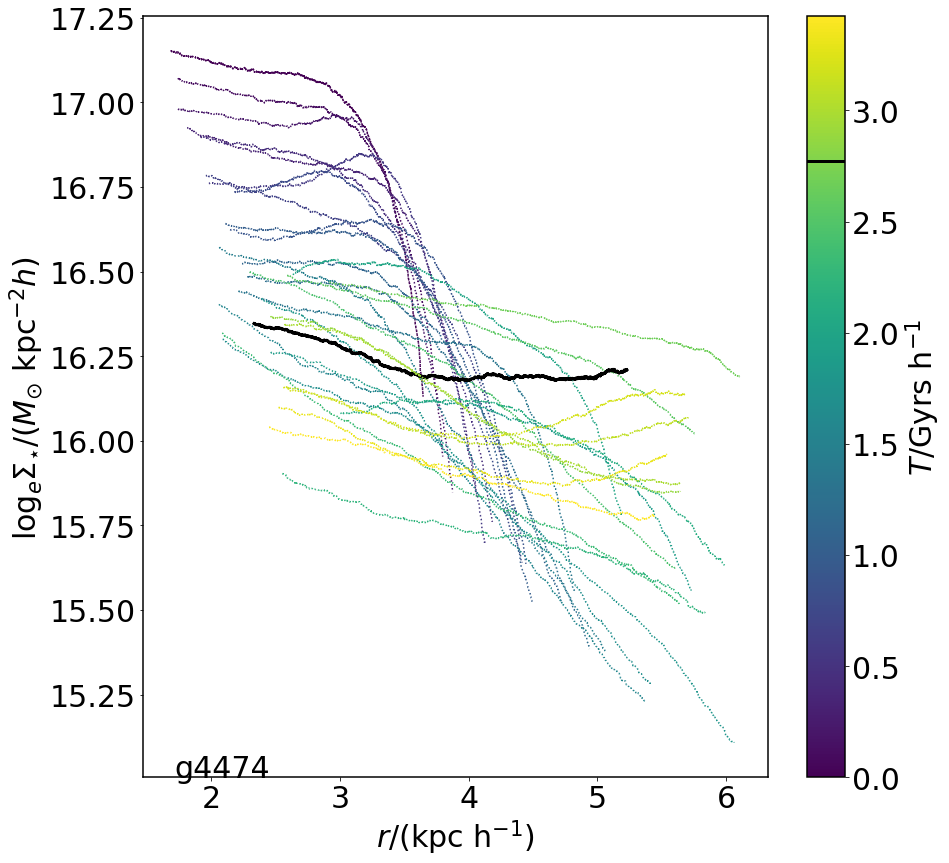

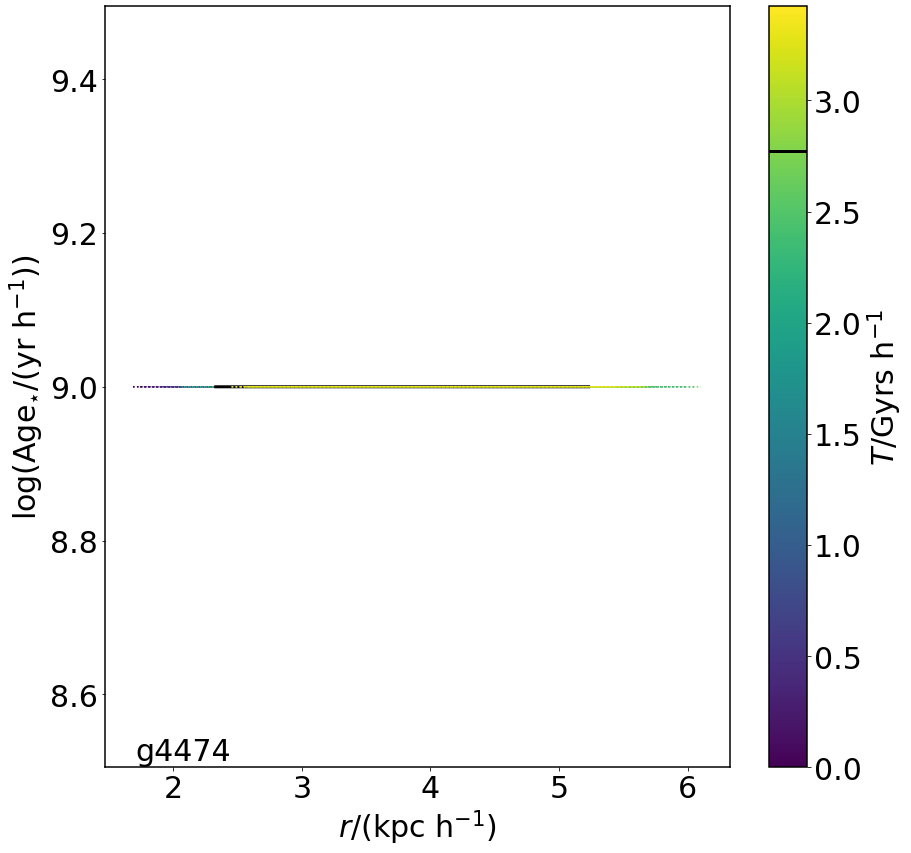

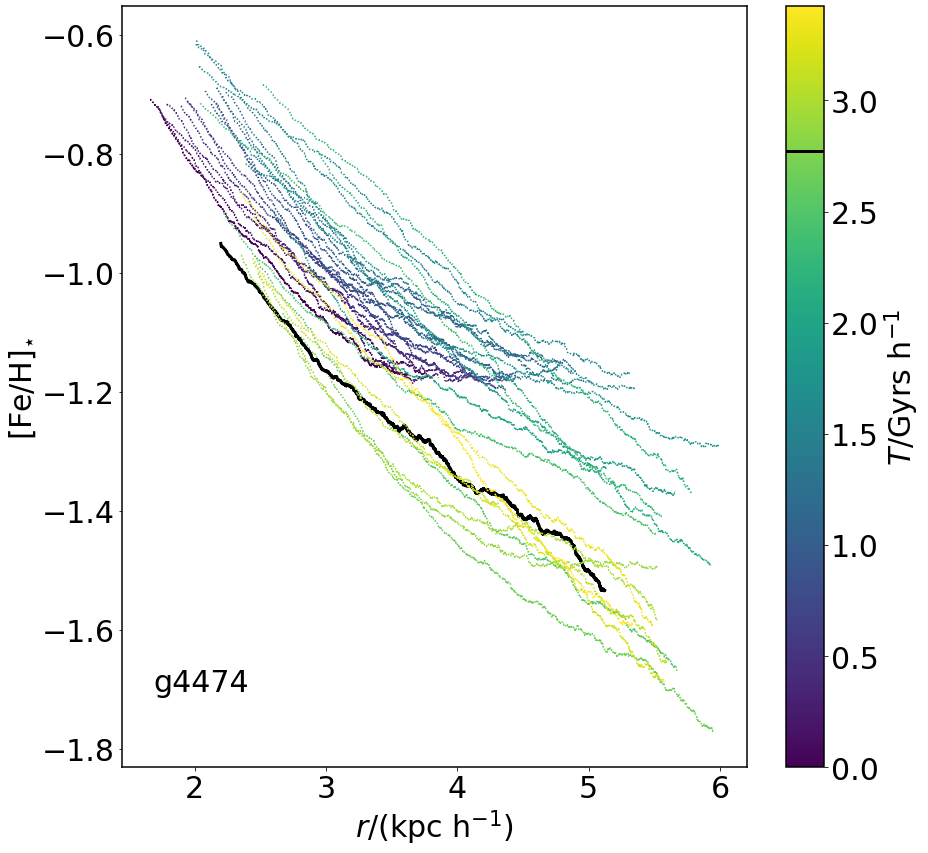

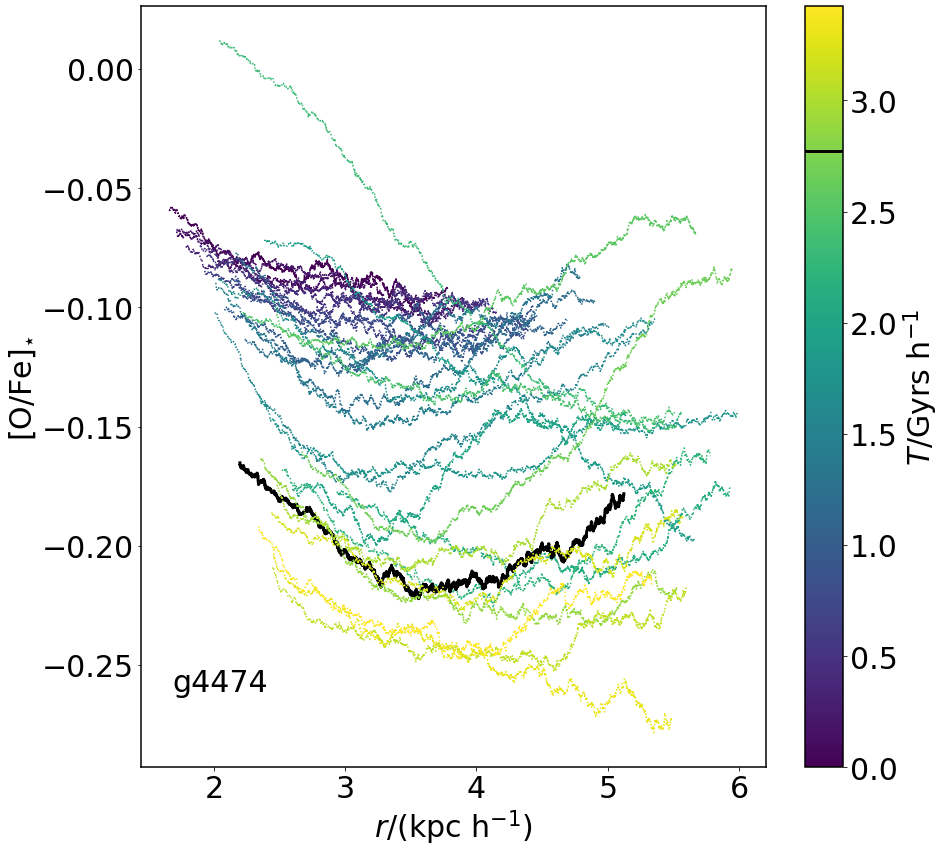

In [28]:
ff, cc = 4474, 4469
xaxis_4474, XF_4474, XO_4474, MassPro_4474, FeHPro_4474, OFePro_4474, AgePro_4474, Times_4474, t1_4474 = getProfilesMob(ff, cc, 30)

pl.figure(figsize=(14, 14))

I = np.arange(Times_4474.size)

cmap = mpc.viridis
norm = pl.Normalize(Times_4474.min(), Times_4474.max())


for xd, md, tm, i in zip(xaxis_4474, MassPro_4474, Times_4474, I):
    if i != t1_4474:
        pl.plot(xd, md, color=cmap(norm(tm)), ls=':')
    else:
        pl.plot(xd, md, color='black', ls='-', lw=3)
        ttt = tm

# pl.semilogy()
bar = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
bar.ax.plot([0, 100], [ttt]*2, ls='-', color='black', lw=3)

pl.xlabel('$r/$(kpc h$^{-1}$)')
pl.ylabel('$\log_e \Sigma_{\star}/(M_{\odot}$ kpc$^{-2} h$)')

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[0]+deltay/1e4, 'g{}'.format(ff))

pl.figure(figsize=(14, 14))

for xd, md, tm, i in zip(xaxis_4474 ,AgePro_4474, Times_4474, I):
    if i != t1_4474:
        pl.plot(xd, np.log10(md)+9., color=cmap(norm(tm)), ls=':')
    else:
        pl.plot(xd, np.log10(md)+9., 'black', ls='-', lw=3)
    
# pl.semilogy()
bar = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
bar.ax.plot([0, 100], [ttt]*2, ls='-', color='black', lw=3)

pl.xlabel('$r/$(kpc h$^{-1}$)')
# pl.ylabel('Age$_{\star}$/(Gyrs h$^{-1}$)')
pl.ylabel('log(Age$_{\star}$/(yr h$^{-1}$))')

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[0]+deltay/1e2, 'g{}'.format(ff))

pl.figure(figsize=(14, 14))

for xd, md, tm, i in zip(XF_4474, FeHPro_4474, Times_4474, I):
    if i != t1_4474:
        pl.plot(xd, md, color=cmap(norm(tm)), ls=':')
    else:
        pl.plot(xd, md, color='black', ls='-', lw=3)
    
bar = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
bar.ax.plot([0, 100], [ttt]*2, ls='-', color='black', lw=3)

pl.xlabel('$r/$(kpc h$^{-1}$)')
pl.ylabel('[Fe/H]$_{\star}$')

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[0]+deltay/10, 'g{}'.format(ff))

pl.figure(figsize=(14, 14))

for xd, md, tm, i in zip(XO_4474, OFePro_4474, Times_4474, I):
    if i != t1_4474:
        pl.plot(xd, md, color=cmap(norm(tm)), ls=':')
    else:
        pl.plot(xd, md, color='black', ls='-', lw=3)
    
bar = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
bar.ax.plot([0, 100], [ttt]*2, ls='-', color='black', lw=3)

pl.xlabel('$r/$(kpc h$^{-1}$)')
pl.ylabel('[O/Fe]$_{\star}$')

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[0]+deltay/10, 'g{}'.format(ff))

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


Text(0.5309773398482958, -0.25107810482382775, 'g4338')

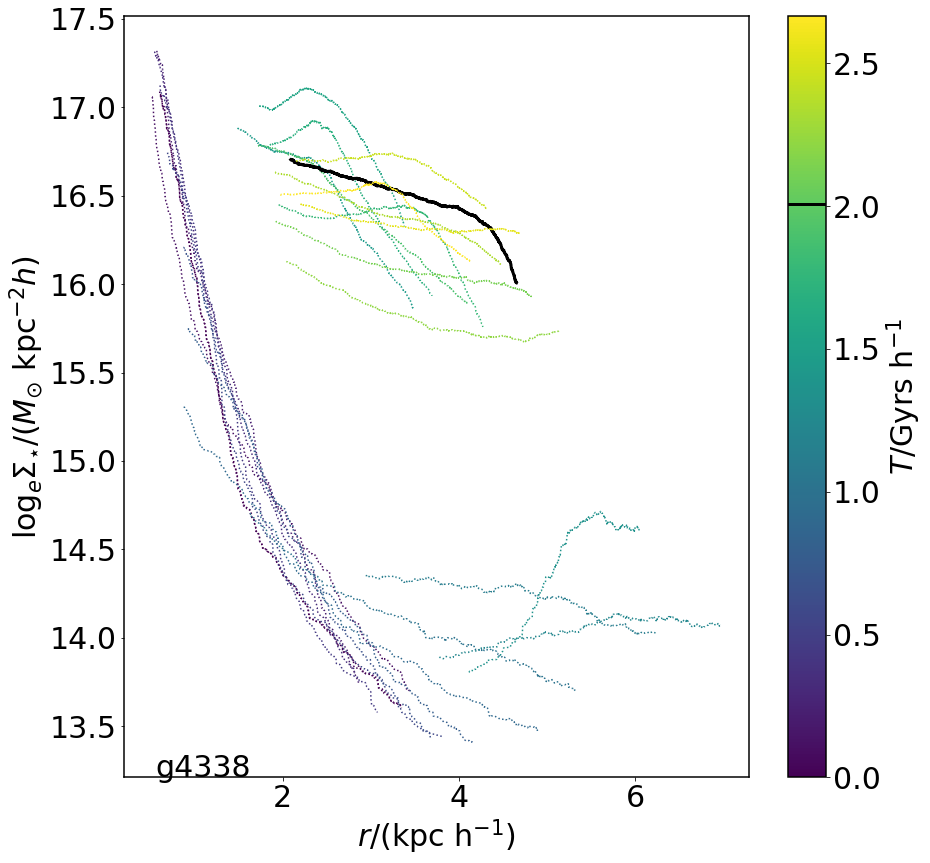

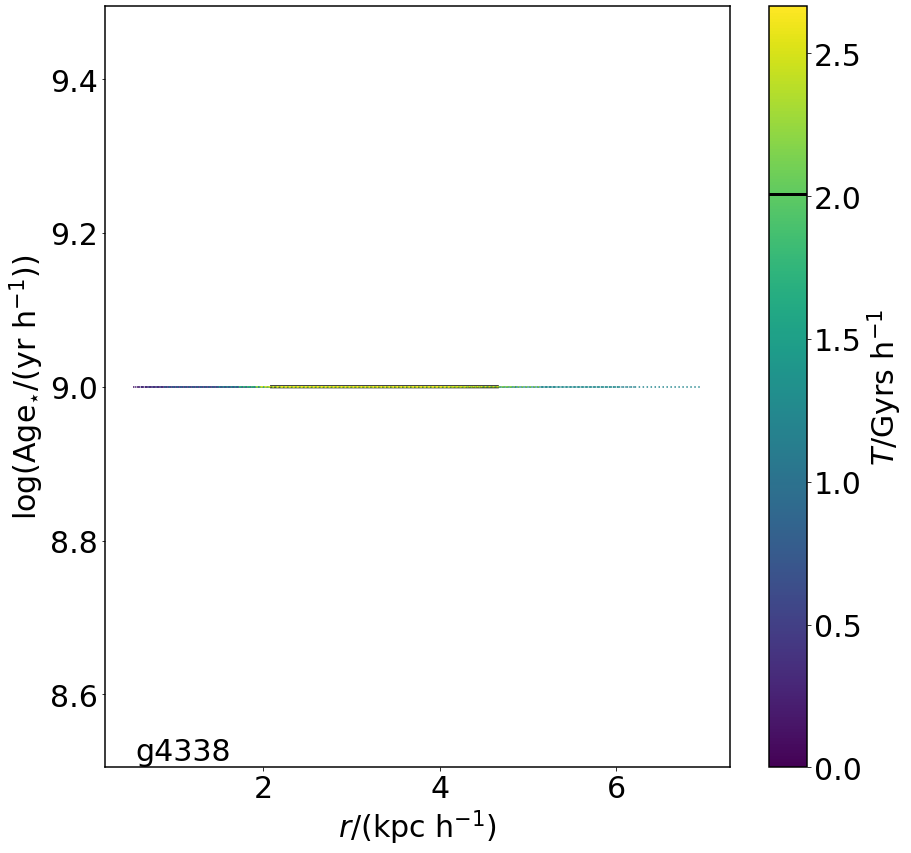

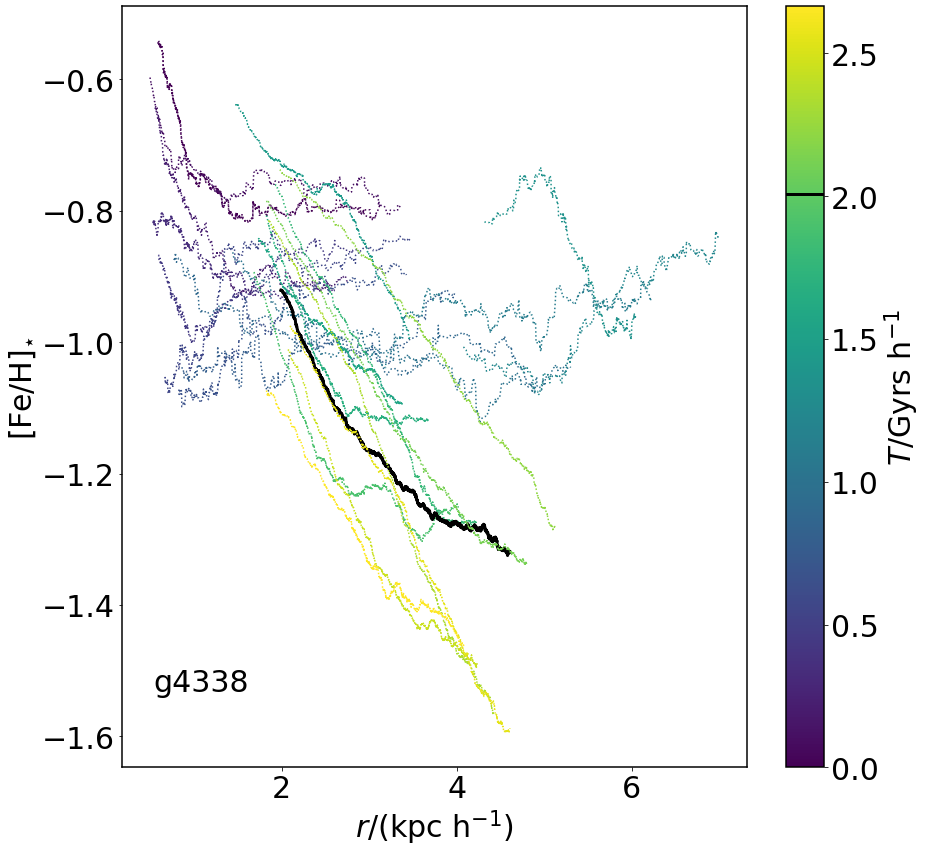

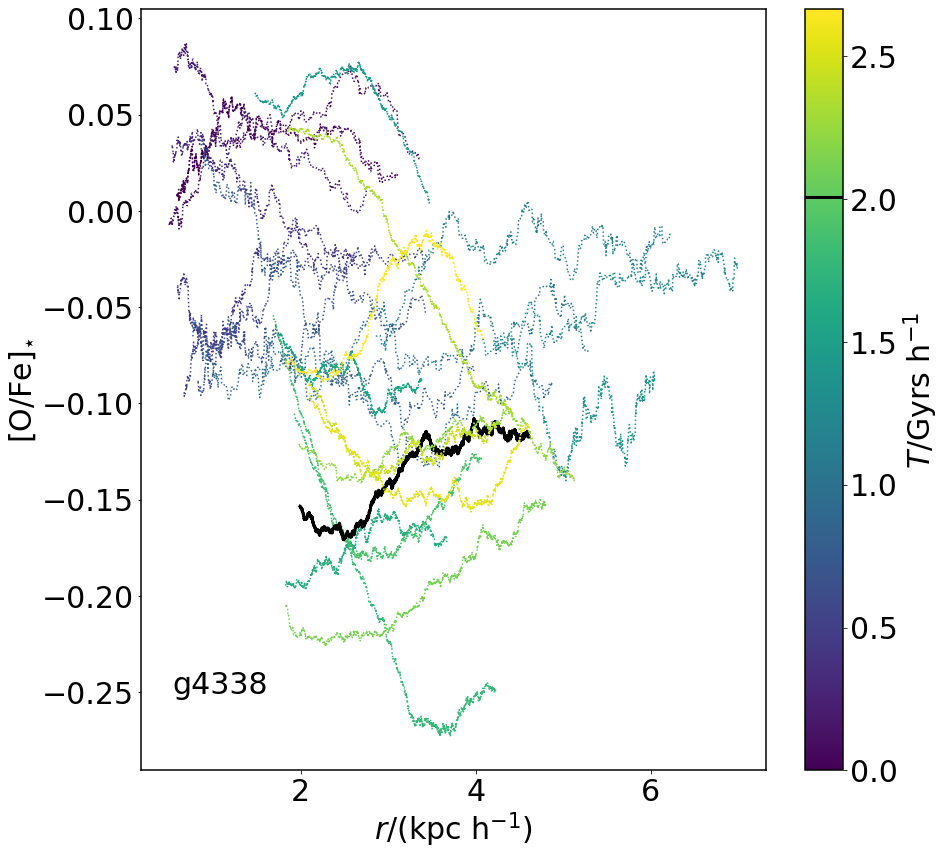

In [29]:
ff, cc = 4338, 4337
xaxis_4474, XF_4474, XO_4474, MassPro_4474, FeHPro_4474, OFePro_4474, AgePro_4474, Times_4474, t1_4474 = getProfilesMob(ff, cc, 30)

pl.figure(figsize=(14, 14))

I = np.arange(Times_4474.size)

cmap = mpc.viridis
norm = pl.Normalize(Times_4474.min(), Times_4474.max())


for xd, md, tm, i in zip(xaxis_4474, MassPro_4474, Times_4474, I):
    if i != t1_4474:
        pl.plot(xd, md, color=cmap(norm(tm)), ls=':')
    else:
        pl.plot(xd, md, color='black', ls='-', lw=3)
        ttt = tm

# pl.semilogy()
bar = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
bar.ax.plot([0, 100], [ttt]*2, ls='-', color='black', lw=3)

pl.xlabel('$r/$(kpc h$^{-1}$)')
pl.ylabel('$\log_e \Sigma_{\star}/(M_{\odot}$ kpc$^{-2} h$)')

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[0]+deltay/1e4, 'g{}'.format(ff))

pl.figure(figsize=(14, 14))

for xd, md, tm, i in zip(xaxis_4474 ,AgePro_4474, Times_4474, I):
    if i != t1_4474:
        pl.plot(xd, np.log10(md)+9., color=cmap(norm(tm)), ls=':')
    else:
        pl.plot(xd, np.log10(md)+9., 'black', ls='-', lw=3)
    
# pl.semilogy()
bar = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
bar.ax.plot([0, 100], [ttt]*2, ls='-', color='black', lw=3)

pl.xlabel('$r/$(kpc h$^{-1}$)')
# pl.ylabel('Age$_{\star}$/(Gyrs h$^{-1}$)')
pl.ylabel('log(Age$_{\star}$/(yr h$^{-1}$))')

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[0]+deltay/1e2, 'g{}'.format(ff))

pl.figure(figsize=(14, 14))

for xd, md, tm, i in zip(XF_4474, FeHPro_4474, Times_4474, I):
    if i != t1_4474:
        pl.plot(xd, md, color=cmap(norm(tm)), ls=':')
    else:
        pl.plot(xd, md, color='black', ls='-', lw=3)
    
bar = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
bar.ax.plot([0, 100], [ttt]*2, ls='-', color='black', lw=3)

pl.xlabel('$r/$(kpc h$^{-1}$)')
pl.ylabel('[Fe/H]$_{\star}$')

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[0]+deltay/10, 'g{}'.format(ff))

pl.figure(figsize=(14, 14))

for xd, md, tm, i in zip(XO_4474, OFePro_4474, Times_4474, I):
    if i != t1_4474:
        pl.plot(xd, md, color=cmap(norm(tm)), ls=':')
    else:
        pl.plot(xd, md, color='black', ls='-', lw=3)
    
bar = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
bar.ax.plot([0, 100], [ttt]*2, ls='-', color='black', lw=3)

pl.xlabel('$r/$(kpc h$^{-1}$)')
pl.ylabel('[O/Fe]$_{\star}$')

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[0]+deltay/10, 'g{}'.format(ff))

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


Text(0.6051153126099174, -0.39290009282529353, 'g4339')

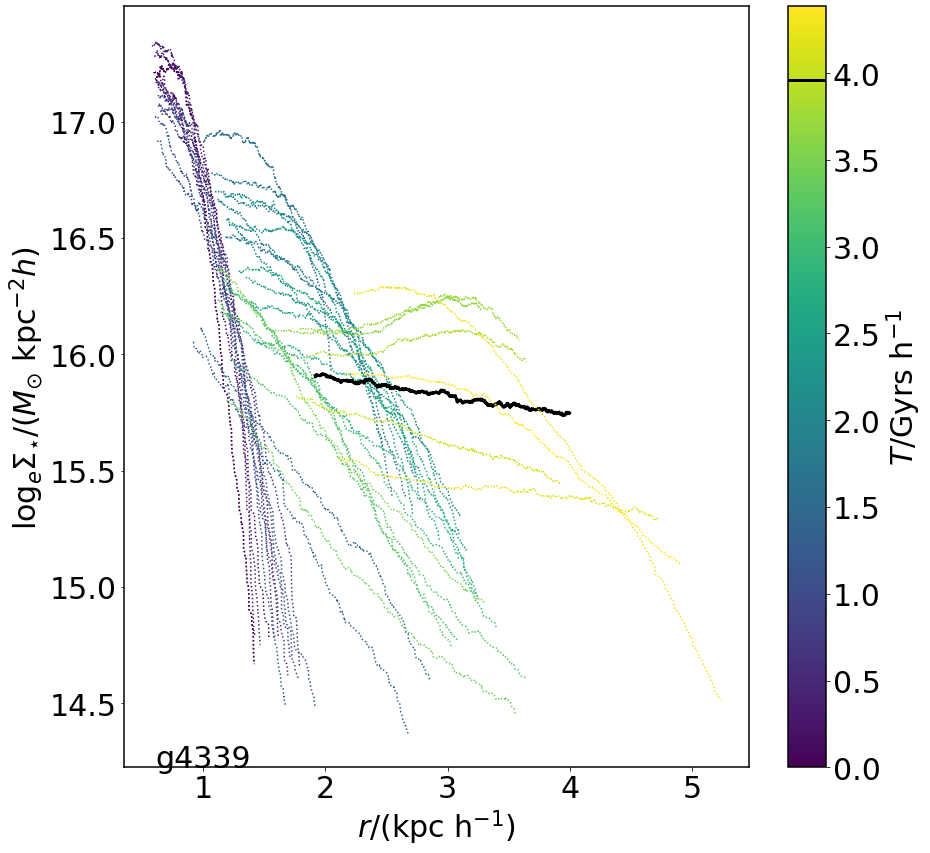

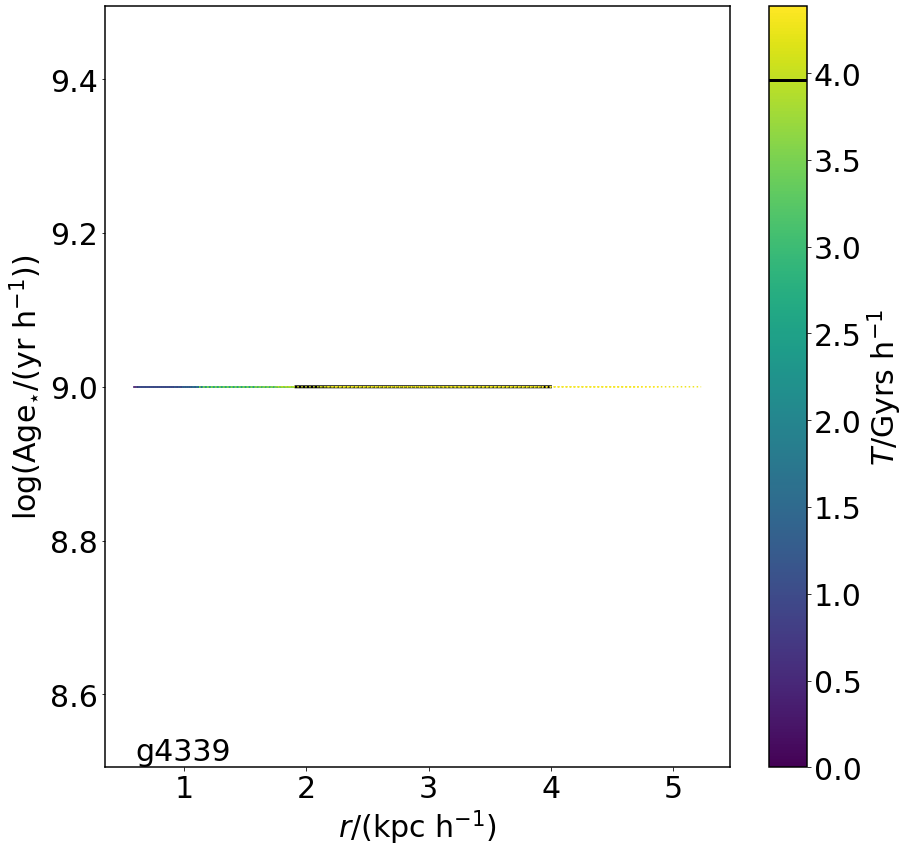

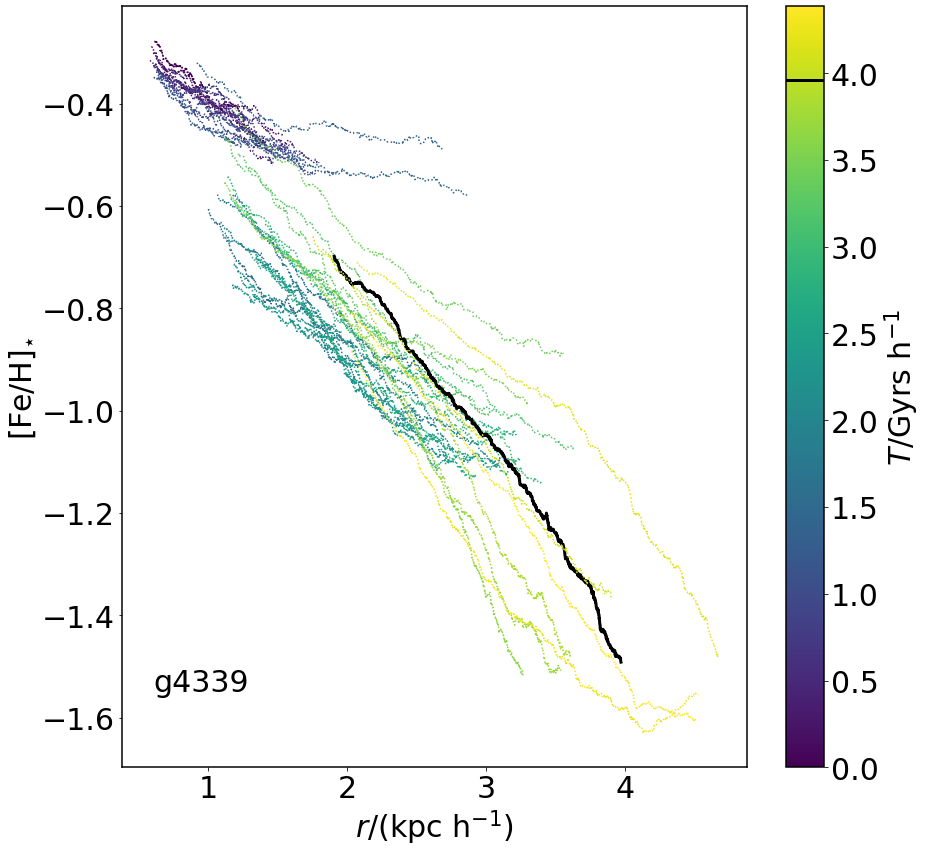

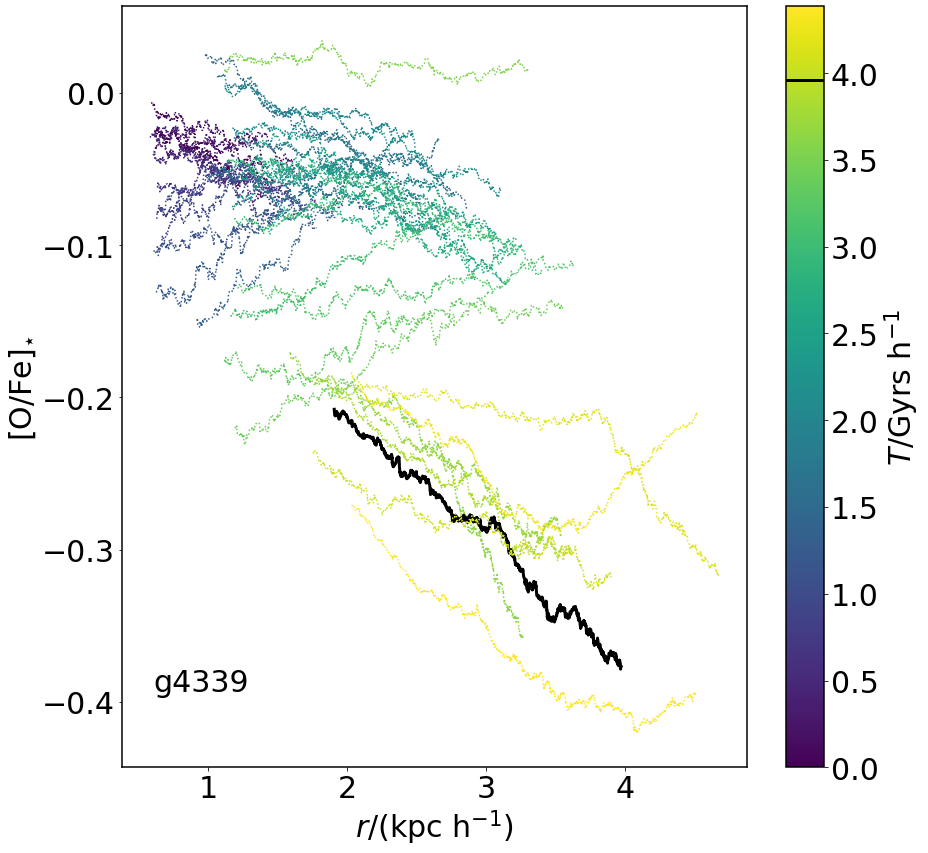

In [30]:
ff, cc = 4339, 4337
xaxis_4474, XF_4474, XO_4474, MassPro_4474, FeHPro_4474, OFePro_4474, AgePro_4474, Times_4474, t1_4474 = getProfilesMob(ff, cc, 30)

pl.figure(figsize=(14, 14))

I = np.arange(Times_4474.size)

cmap = mpc.viridis
norm = pl.Normalize(Times_4474.min(), Times_4474.max())


for xd, md, tm, i in zip(xaxis_4474, MassPro_4474, Times_4474, I):
    if i != t1_4474:
        pl.plot(xd, md, color=cmap(norm(tm)), ls=':')
    else:
        pl.plot(xd, md, color='black', ls='-', lw=3)
        ttt = tm

# pl.semilogy()
bar = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
bar.ax.plot([0, 100], [ttt]*2, ls='-', color='black', lw=3)

pl.xlabel('$r/$(kpc h$^{-1}$)')
pl.ylabel('$\log_e \Sigma_{\star}/(M_{\odot}$ kpc$^{-2} h$)')

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[0]+deltay/1e4, 'g{}'.format(ff))

pl.figure(figsize=(14, 14))

for xd, md, tm, i in zip(xaxis_4474 ,AgePro_4474, Times_4474, I):
    if i != t1_4474:
        pl.plot(xd, np.log10(md)+9., color=cmap(norm(tm)), ls=':')
    else:
        pl.plot(xd, np.log10(md)+9., 'black', ls='-', lw=3)
    
# pl.semilogy()
bar = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
bar.ax.plot([0, 100], [ttt]*2, ls='-', color='black', lw=3)

pl.xlabel('$r/$(kpc h$^{-1}$)')
# pl.ylabel('Age$_{\star}$/(Gyrs h$^{-1}$)')
pl.ylabel('log(Age$_{\star}$/(yr h$^{-1}$))')

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[0]+deltay/1e2, 'g{}'.format(ff))

pl.figure(figsize=(14, 14))

for xd, md, tm, i in zip(XF_4474, FeHPro_4474, Times_4474, I):
    if i != t1_4474:
        pl.plot(xd, md, color=cmap(norm(tm)), ls=':')
    else:
        pl.plot(xd, md, color='black', ls='-', lw=3)
    
bar = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
bar.ax.plot([0, 100], [ttt]*2, ls='-', color='black', lw=3)

pl.xlabel('$r/$(kpc h$^{-1}$)')
pl.ylabel('[Fe/H]$_{\star}$')

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[0]+deltay/10, 'g{}'.format(ff))

pl.figure(figsize=(14, 14))

for xd, md, tm, i in zip(XO_4474, OFePro_4474, Times_4474, I):
    if i != t1_4474:
        pl.plot(xd, md, color=cmap(norm(tm)), ls=':')
    else:
        pl.plot(xd, md, color='black', ls='-', lw=3)
    
bar = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
bar.ax.plot([0, 100], [ttt]*2, ls='-', color='black', lw=3)

pl.xlabel('$r/$(kpc h$^{-1}$)')
pl.ylabel('[O/Fe]$_{\star}$')

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[0]+deltay/10, 'g{}'.format(ff))

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


Text(0.4026060016632448, -0.23889747090637684, 'g4341')

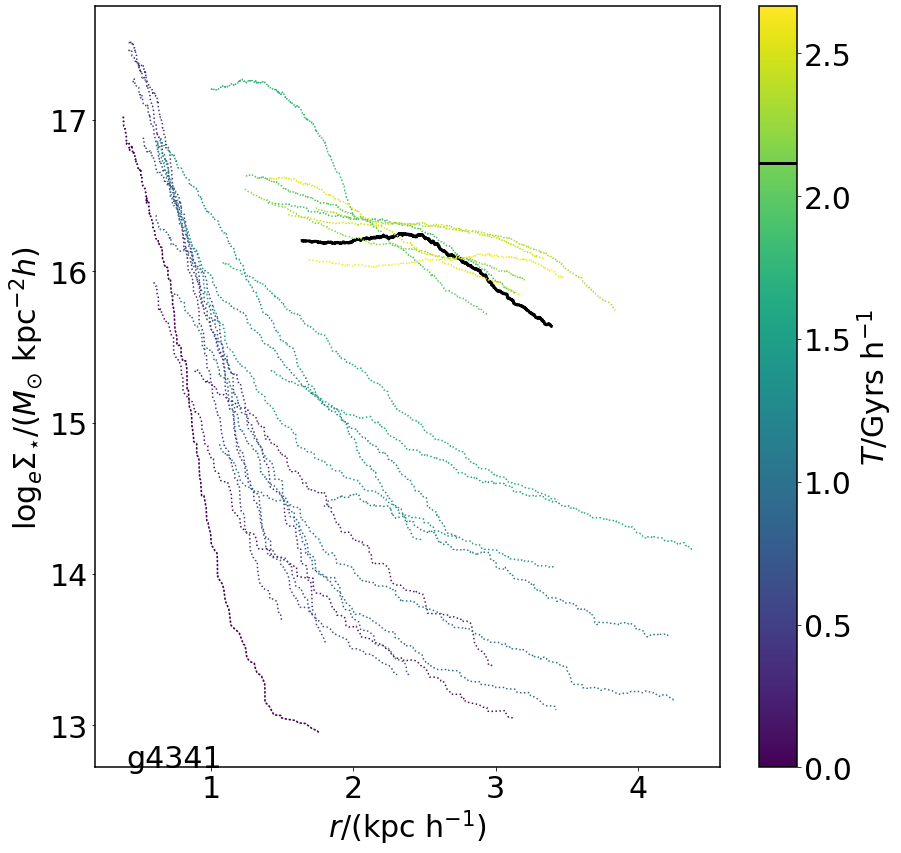

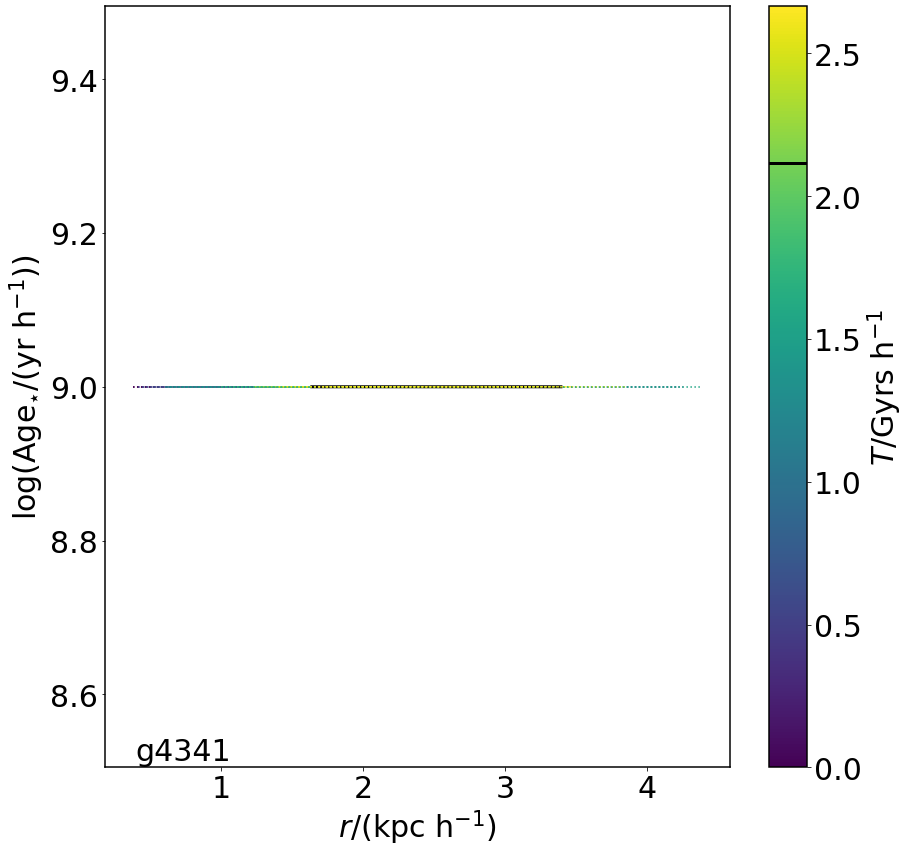

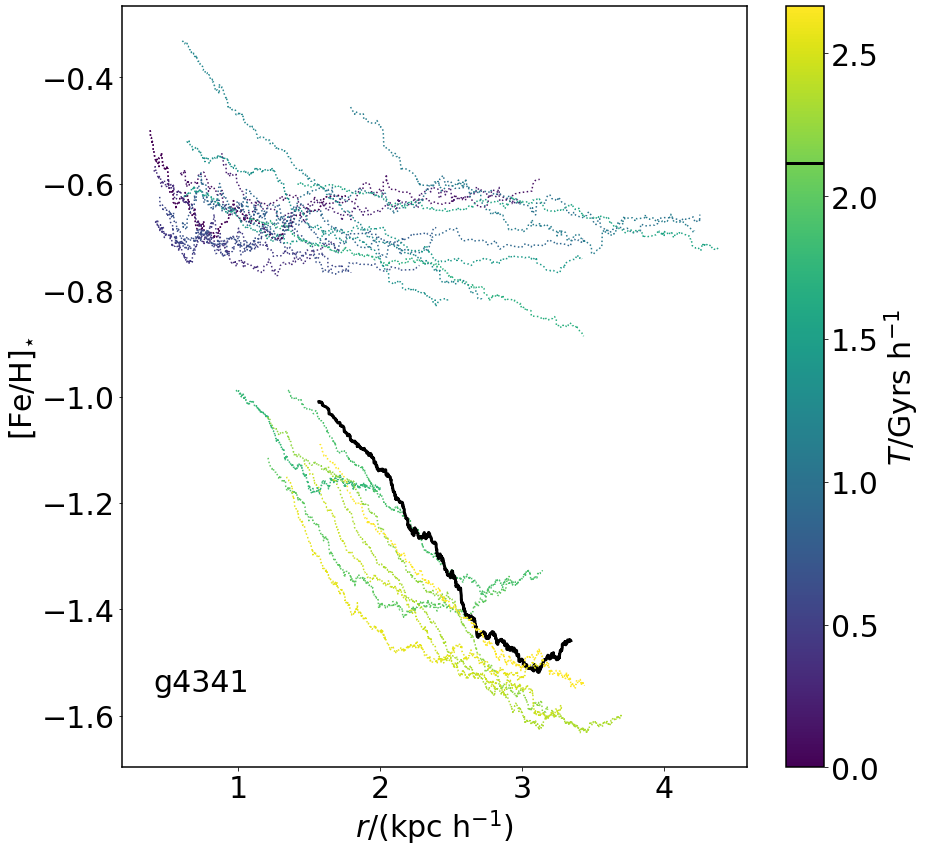

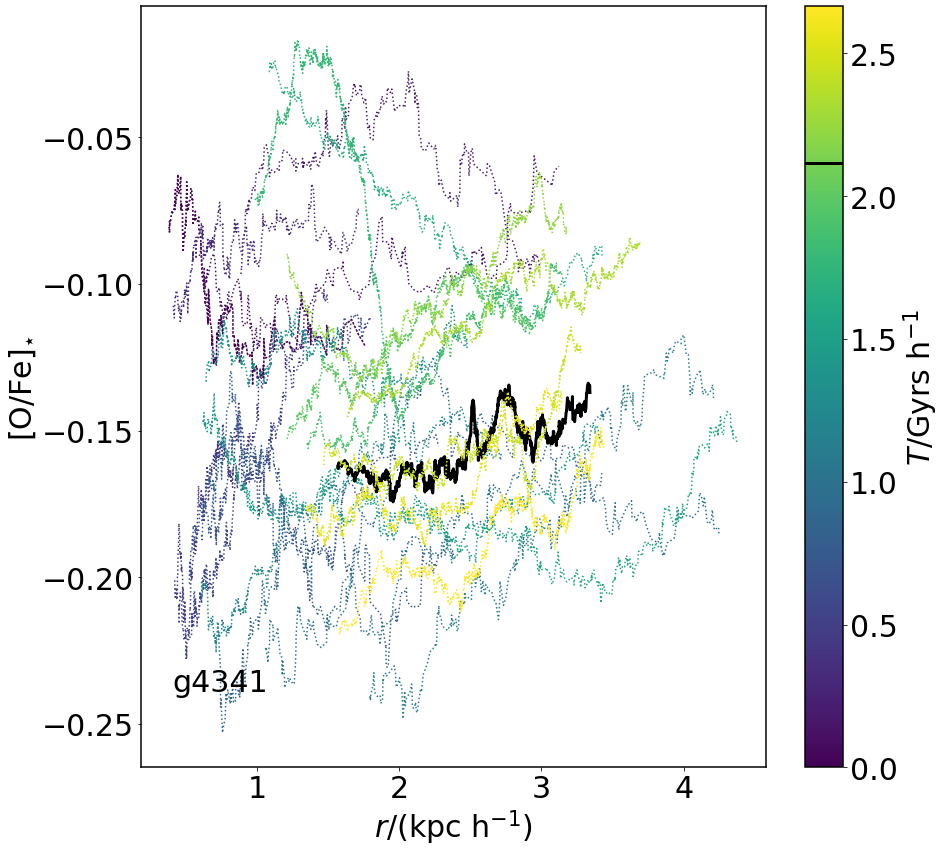

In [31]:
ff, cc = 4341, 4337
xaxis_4474, XF_4474, XO_4474, MassPro_4474, FeHPro_4474, OFePro_4474, AgePro_4474, Times_4474, t1_4474 = getProfilesMob(ff, cc, 30)

pl.figure(figsize=(14, 14))

I = np.arange(Times_4474.size)

cmap = mpc.viridis
norm = pl.Normalize(Times_4474.min(), Times_4474.max())


for xd, md, tm, i in zip(xaxis_4474, MassPro_4474, Times_4474, I):
    if i != t1_4474:
        pl.plot(xd, md, color=cmap(norm(tm)), ls=':')
    else:
        pl.plot(xd, md, color='black', ls='-', lw=3)
        ttt = tm

# pl.semilogy()
bar = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
bar.ax.plot([0, 100], [ttt]*2, ls='-', color='black', lw=3)

pl.xlabel('$r/$(kpc h$^{-1}$)')
pl.ylabel('$\log_e \Sigma_{\star}/(M_{\odot}$ kpc$^{-2} h$)')

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[0]+deltay/1e4, 'g{}'.format(ff))

pl.figure(figsize=(14, 14))

for xd, md, tm, i in zip(xaxis_4474 ,AgePro_4474, Times_4474, I):
    if i != t1_4474:
        pl.plot(xd, np.log10(md)+9., color=cmap(norm(tm)), ls=':')
    else:
        pl.plot(xd, np.log10(md)+9., 'black', ls='-', lw=3)
    
# pl.semilogy()
bar = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
bar.ax.plot([0, 100], [ttt]*2, ls='-', color='black', lw=3)

pl.xlabel('$r/$(kpc h$^{-1}$)')
# pl.ylabel('Age$_{\star}$/(Gyrs h$^{-1}$)')
pl.ylabel('log(Age$_{\star}$/(yr h$^{-1}$))')

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[0]+deltay/1e2, 'g{}'.format(ff))

pl.figure(figsize=(14, 14))

for xd, md, tm, i in zip(XF_4474, FeHPro_4474, Times_4474, I):
    if i != t1_4474:
        pl.plot(xd, md, color=cmap(norm(tm)), ls=':')
    else:
        pl.plot(xd, md, color='black', ls='-', lw=3)
    
bar = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
bar.ax.plot([0, 100], [ttt]*2, ls='-', color='black', lw=3)

pl.xlabel('$r/$(kpc h$^{-1}$)')
pl.ylabel('[Fe/H]$_{\star}$')

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[0]+deltay/10, 'g{}'.format(ff))

pl.figure(figsize=(14, 14))

for xd, md, tm, i in zip(XO_4474, OFePro_4474, Times_4474, I):
    if i != t1_4474:
        pl.plot(xd, md, color=cmap(norm(tm)), ls=':')
    else:
        pl.plot(xd, md, color='black', ls='-', lw=3)
    
bar = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
bar.ax.plot([0, 100], [ttt]*2, ls='-', color='black', lw=3)

pl.xlabel('$r/$(kpc h$^{-1}$)')
pl.ylabel('[O/Fe]$_{\star}$')

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[0]+deltay/10, 'g{}'.format(ff))

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/disk2/home/srodriguez/cielo_tutorial/notebooks/BreakFinder.py:149: RuntimeWarning: invalid value encountered in true_divide
  Sigma.append(SumM/S)
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


Text(0.6167990122656077, -0.2170992185175419, 'g4343')

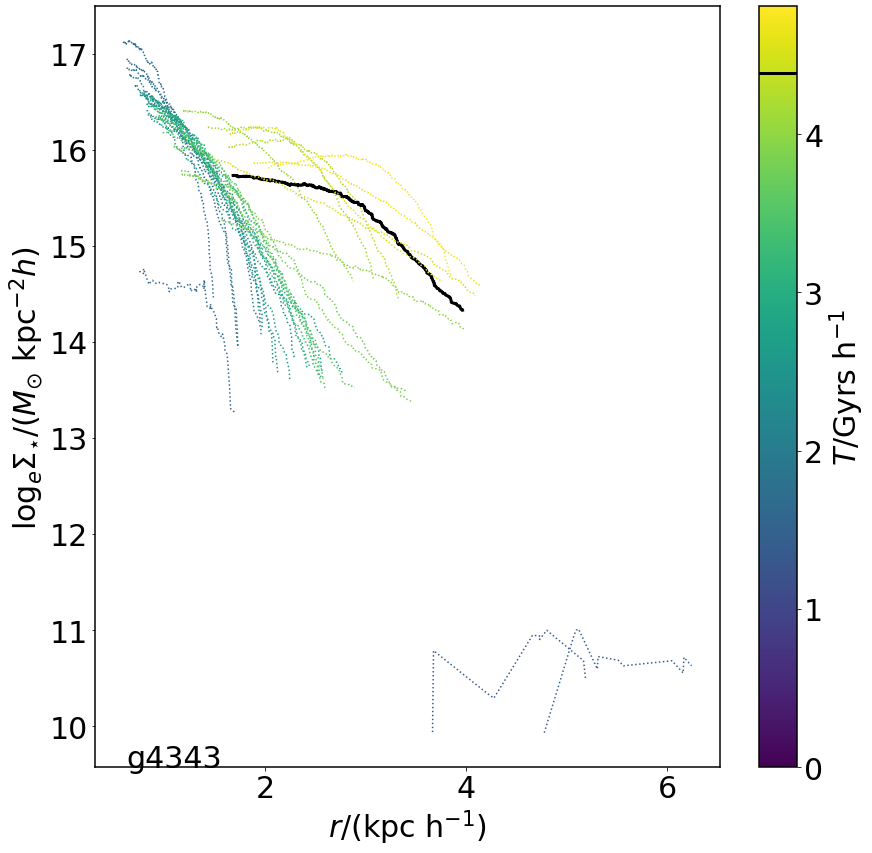

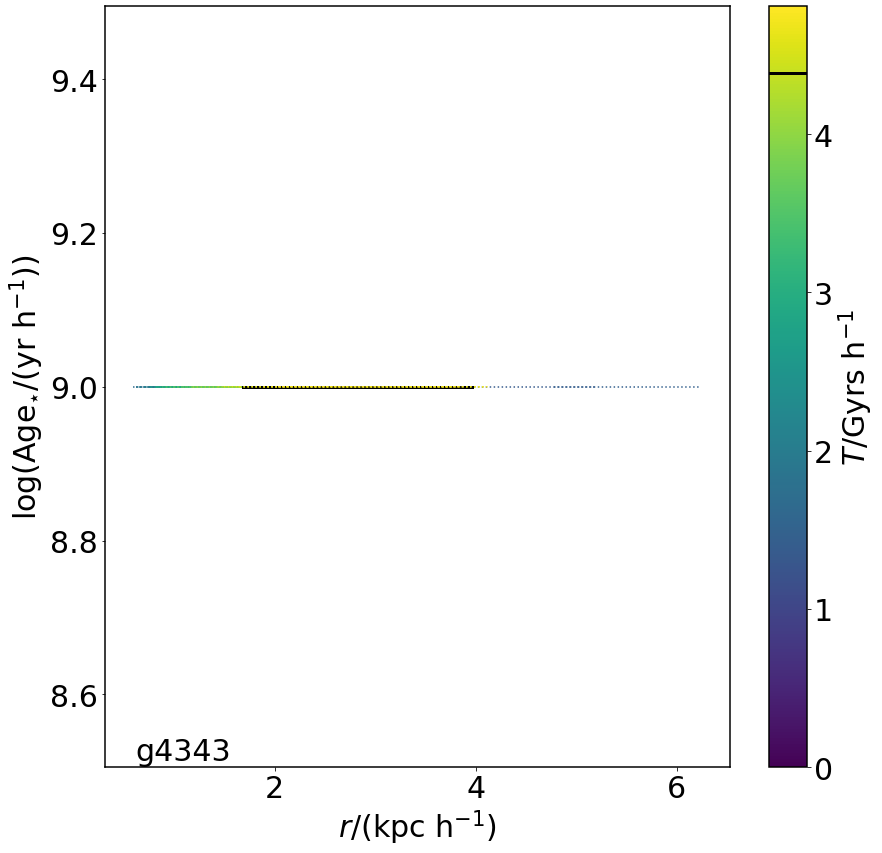

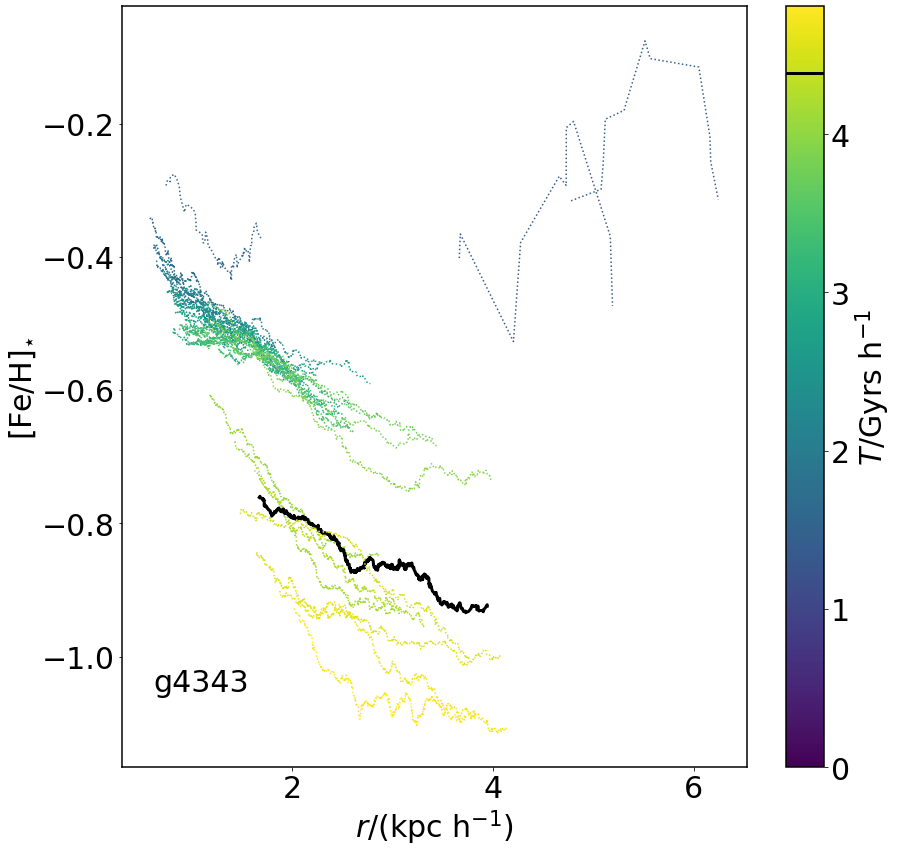

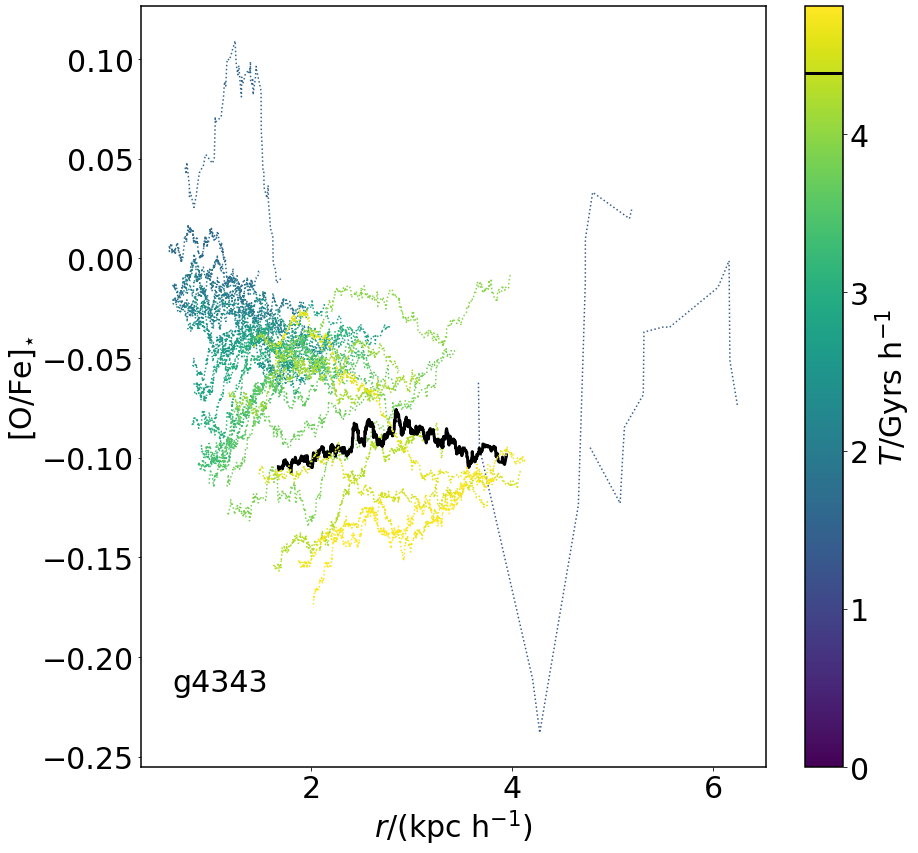

In [32]:
ff, cc = 4343, 4337
xaxis_4474, XF_4474, XO_4474, MassPro_4474, FeHPro_4474, OFePro_4474, AgePro_4474, Times_4474, t1_4474 = getProfilesMob(ff, cc, 30)

pl.figure(figsize=(14, 14))

I = np.arange(Times_4474.size)

cmap = mpc.viridis
norm = pl.Normalize(Times_4474.min(), Times_4474.max())


for xd, md, tm, i in zip(xaxis_4474, MassPro_4474, Times_4474, I):
    try:
        if i != t1_4474:
            pl.plot(xd, md, color=cmap(norm(tm)), ls=':')
        else:
            pl.plot(xd, md, color='black', ls='-', lw=3)
            ttt = tm
    except ValueError:
        pass

# pl.semilogy()
bar = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
bar.ax.plot([0, 100], [ttt]*2, ls='-', color='black', lw=3)

pl.xlabel('$r/$(kpc h$^{-1}$)')
pl.ylabel('$\log_e \Sigma_{\star}/(M_{\odot}$ kpc$^{-2} h$)')

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[0]+deltay/1e4, 'g{}'.format(ff))

pl.figure(figsize=(14, 14))

for xd, md, tm, i in zip(xaxis_4474 ,AgePro_4474, Times_4474, I):
    try:
        if i != t1_4474:
            pl.plot(xd, np.log10(md)+9., color=cmap(norm(tm)), ls=':')
        else:
            pl.plot(xd, np.log10(md)+9., 'black', ls='-', lw=3)
    except ValueError:
        pass
    
# pl.semilogy()
bar = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
bar.ax.plot([0, 100], [ttt]*2, ls='-', color='black', lw=3)

pl.xlabel('$r/$(kpc h$^{-1}$)')
# pl.ylabel('Age$_{\star}$/(Gyrs h$^{-1}$)')
pl.ylabel('log(Age$_{\star}$/(yr h$^{-1}$))')

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[0]+deltay/1e2, 'g{}'.format(ff))

pl.figure(figsize=(14, 14))

for xd, md, tm, i in zip(XF_4474, FeHPro_4474, Times_4474, I):
    try:
        if i != t1_4474:
            pl.plot(xd, md, color=cmap(norm(tm)), ls=':')
        else:
            pl.plot(xd, md, color='black', ls='-', lw=3)
    except ValueError:
        pass
    
bar = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
bar.ax.plot([0, 100], [ttt]*2, ls='-', color='black', lw=3)

pl.xlabel('$r/$(kpc h$^{-1}$)')
pl.ylabel('[Fe/H]$_{\star}$')

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[0]+deltay/10, 'g{}'.format(ff))

pl.figure(figsize=(14, 14))

for xd, md, tm, i in zip(XO_4474, OFePro_4474, Times_4474, I):
    try:
        if i != t1_4474:
            pl.plot(xd, md, color=cmap(norm(tm)), ls=':')
        else:
            pl.plot(xd, md, color='black', ls='-', lw=3)
    except ValueError:
        pass

bar = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
bar.ax.plot([0, 100], [ttt]*2, ls='-', color='black', lw=3)

pl.xlabel('$r/$(kpc h$^{-1}$)')
pl.ylabel('[O/Fe]$_{\star}$')

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[0]+deltay/10, 'g{}'.format(ff))

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


Text(2.6713955784996024, -0.2574285067617893, 'g4470')

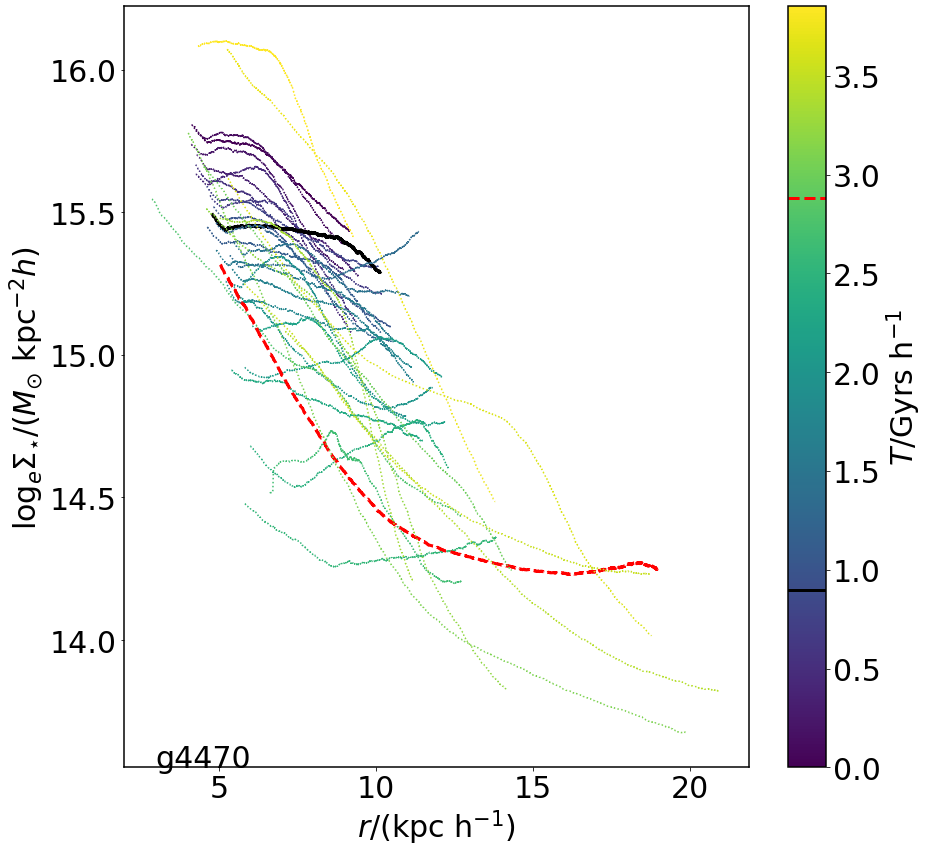

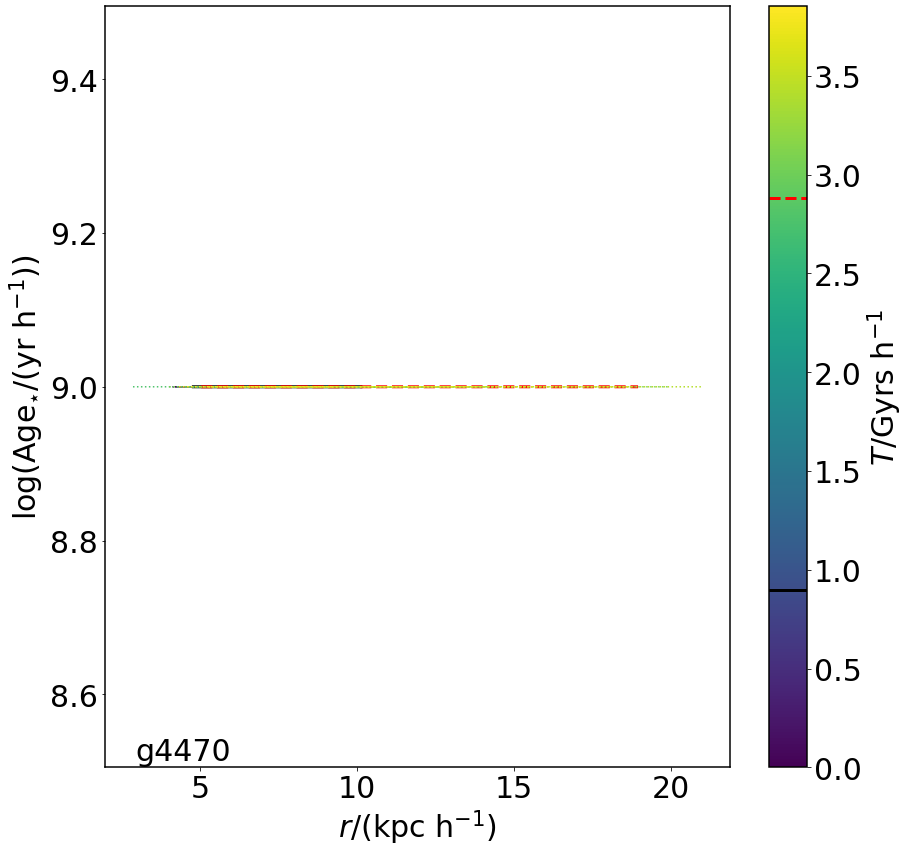

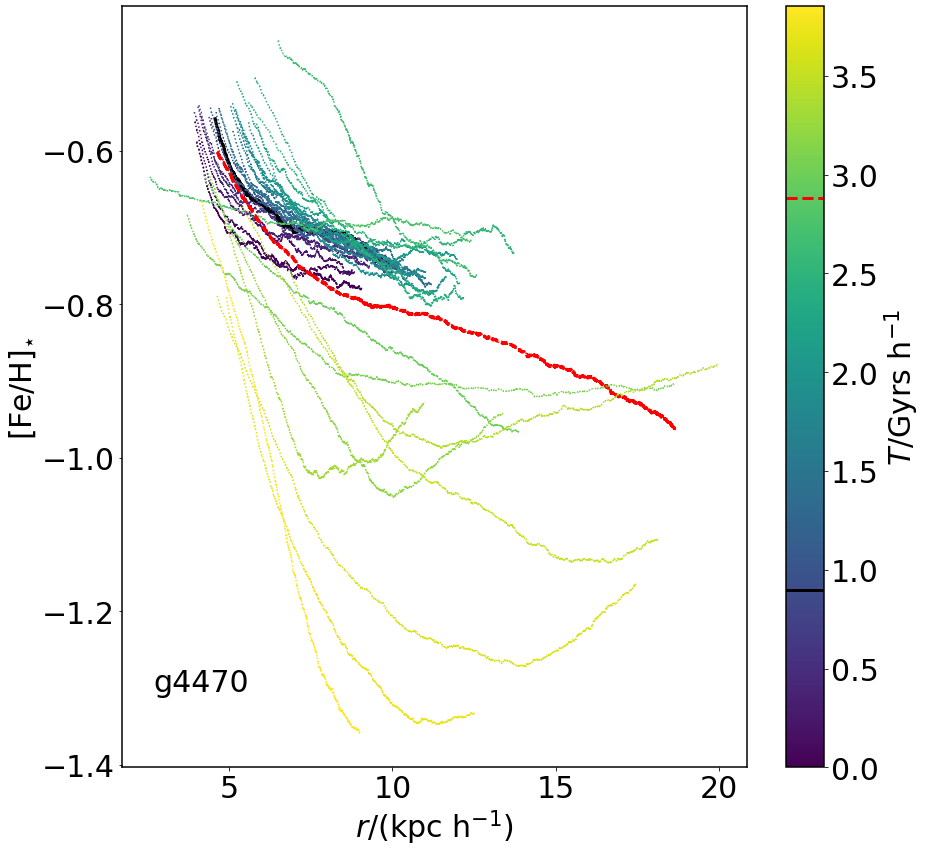

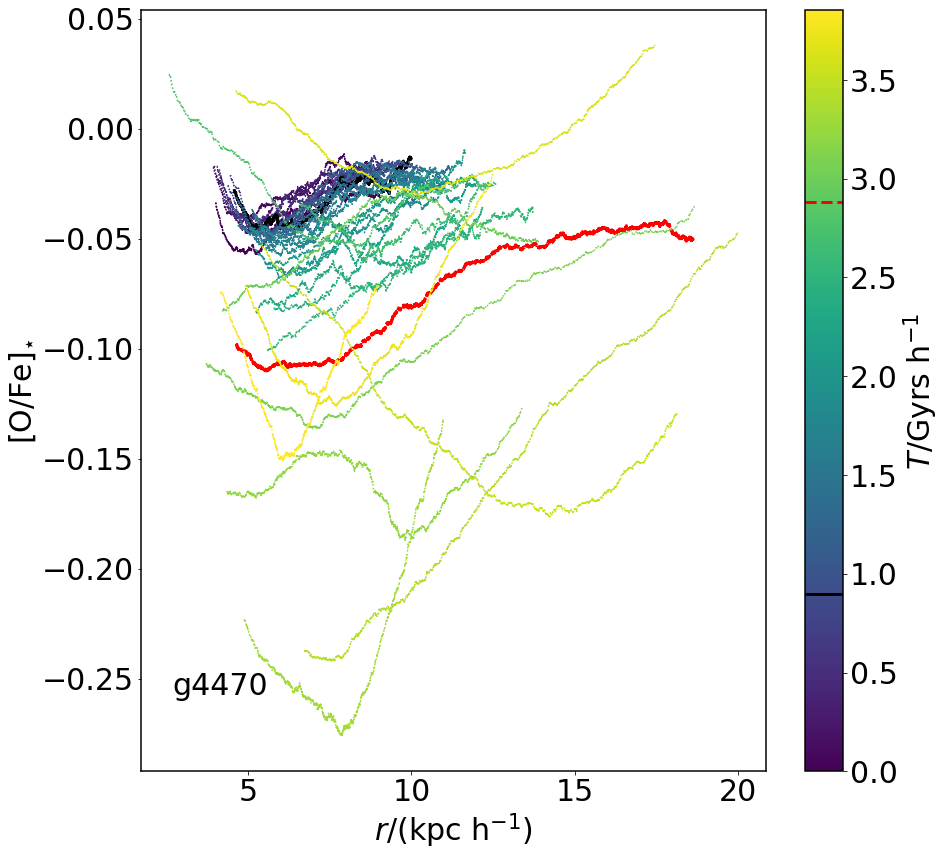

In [33]:
ff, cc = 4470, 4469
xaxis_4474, XF_4474, XO_4474, MassPro_4474, FeHPro_4474, OFePro_4474, AgePro_4474, Times_4474, t1_4474 = getProfilesMob(ff, cc, 30)

nsnaps = np.arange(128, 30, -1)
imerger = np.where(nsnaps==101)[0] # hardcoded

zmerger = sim['SnapNumber_101/Header/Redshift'][()]
tmerger = Cosmo.lookback_time(zmerger).value

pl.figure(figsize=(14, 14))

I = np.arange(Times_4474.size)

cmap = mpc.viridis
norm = pl.Normalize(Times_4474.min(), Times_4474.max())


for xd, md, tm, i in zip(xaxis_4474, MassPro_4474, Times_4474, I):
    if i == t1_4474:
        pl.plot(xd, md, color='black', ls='-', lw=3)
        ttt = tm
    elif i == imerger:
        pl.plot(xd, md, color='red', ls='--', lw=3)
    else:
        pl.plot(xd, md, color=cmap(norm(tm)), ls=':')
    
# pl.semilogy()
bar = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
bar.ax.plot([0, 100], [ttt]*2, ls='-', color='black', lw=3)
bar.ax.plot([0, 100], [tmerger]*2, ls='--', color='red', lw=3)

pl.xlabel('$r/$(kpc h$^{-1}$)')
pl.ylabel('$\log_e \Sigma_{\star}/(M_{\odot}$ kpc$^{-2} h$)')

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[0]+deltay/1e4, 'g{}'.format(ff))

pl.figure(figsize=(14, 14))

for xd, md, tm, i in zip(xaxis_4474 ,AgePro_4474, Times_4474, I):
    if i == t1_4474:
        pl.plot(xd, np.log10(md)+9, color='black', ls='-', lw=3)
    elif i == imerger:
        pl.plot(xd, np.log10(md)+9, color='red', ls='--', lw=3)
    else:
        pl.plot(xd, np.log10(md)+9, color=cmap(norm(tm)), ls=':')
        
# pl.semilogy()
bar = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
bar.ax.plot([0, 100], [ttt]*2, ls='-', color='black', lw=3)
bar.ax.plot([0, 100], [tmerger]*2, ls='--', color='red', lw=3)

pl.xlabel('$r/$(kpc h$^{-1}$)')
# pl.ylabel('Age$_{\star}$/(Gyrs h$^{-1}$)')
pl.ylabel('log(Age$_{\star}$/(yr h$^{-1}$))')

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[0]+deltay/1e2, 'g{}'.format(ff))

pl.figure(figsize=(14, 14))

for xd, md, tm, i in zip(XF_4474, FeHPro_4474, Times_4474, I):
    if i == t1_4474:
        pl.plot(xd, md, color='black', ls='-', lw=3)
    elif i == imerger:
        pl.plot(xd, md, color='red', ls='--', lw=3)
    else:
        pl.plot(xd, md, color=cmap(norm(tm)), ls=':')
    
bar = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
bar.ax.plot([0, 100], [ttt]*2, ls='-', color='black', lw=3)
bar.ax.plot([0, 100], [tmerger]*2, ls='--', color='red', lw=3)

pl.xlabel('$r/$(kpc h$^{-1}$)')
pl.ylabel('[Fe/H]$_{\star}$')

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[0]+deltay/10, 'g{}'.format(ff))

pl.figure(figsize=(14, 14))

for xd, md, tm, i in zip(XO_4474, OFePro_4474, Times_4474, I):
    if i == t1_4474:
        pl.plot(xd, md, color='black', ls='-', lw=3)
    elif i == imerger:
        pl.plot(xd, md, color='red', ls='--', lw=3)
    else:
        pl.plot(xd, md, color=cmap(norm(tm)), ls=':')
    
bar = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
bar.ax.plot([0, 100], [ttt]*2, ls='-', color='black', lw=3)
bar.ax.plot([0, 100], [tmerger]*2, ls='--', color='red', lw=3)

pl.xlabel('$r/$(kpc h$^{-1}$)')
pl.ylabel('[O/Fe]$_{\star}$')

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[0]+deltay/10, 'g{}'.format(ff))

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


Text(2.496149822613038, -0.23894971355795863, 'g4471')

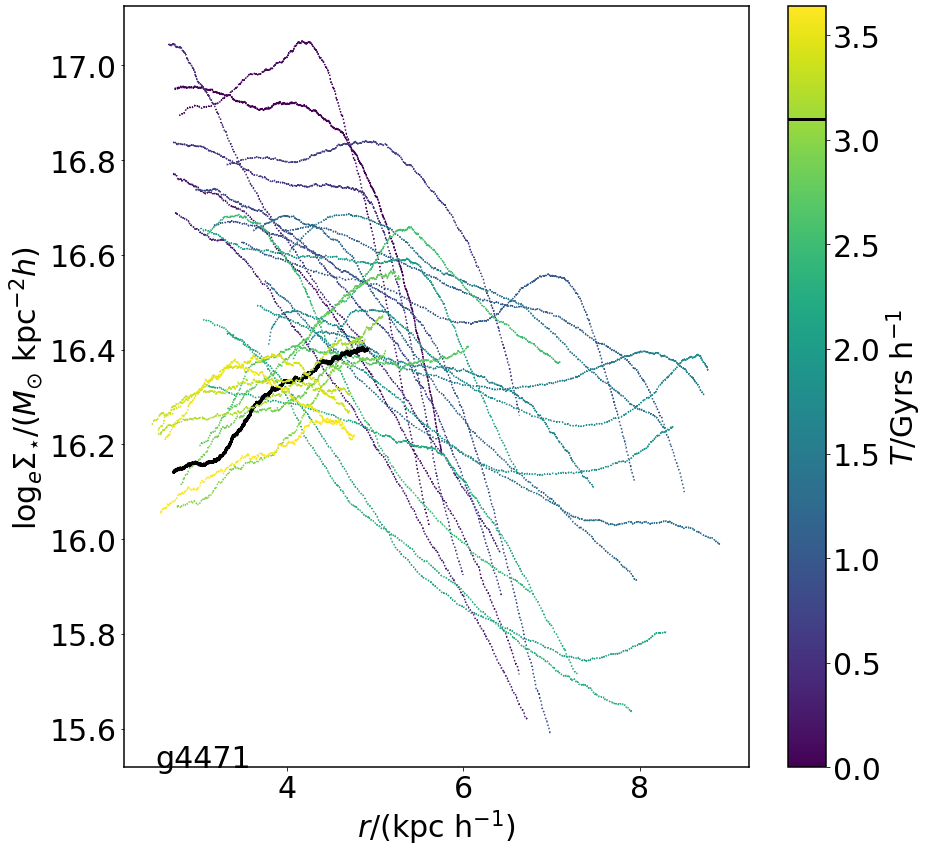

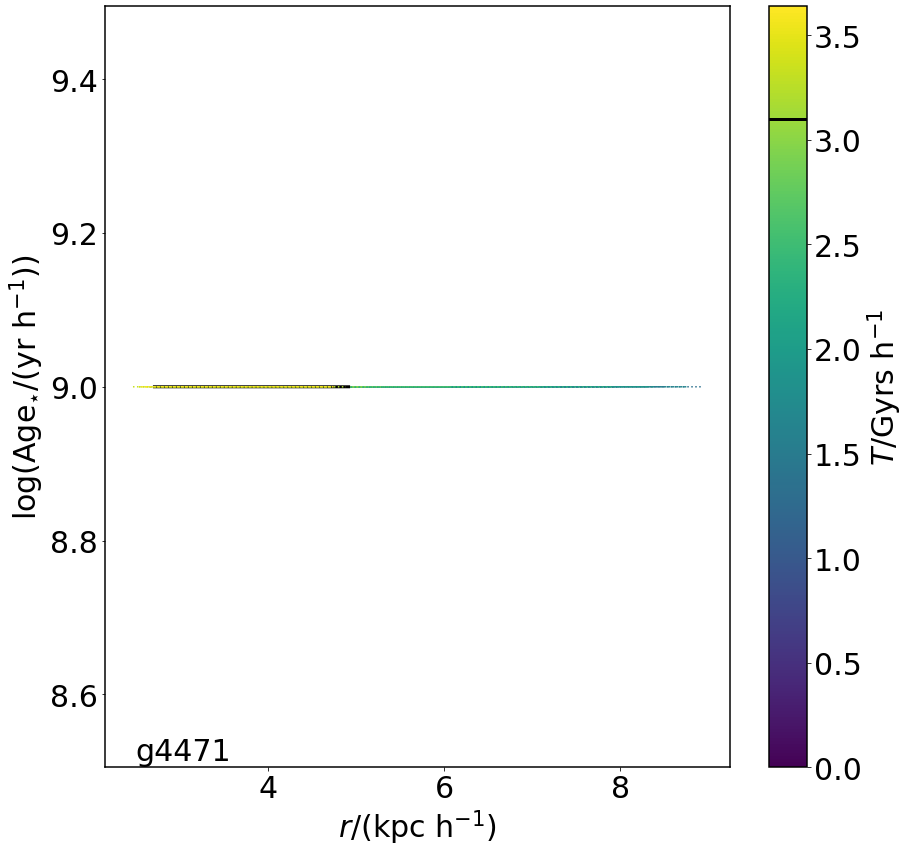

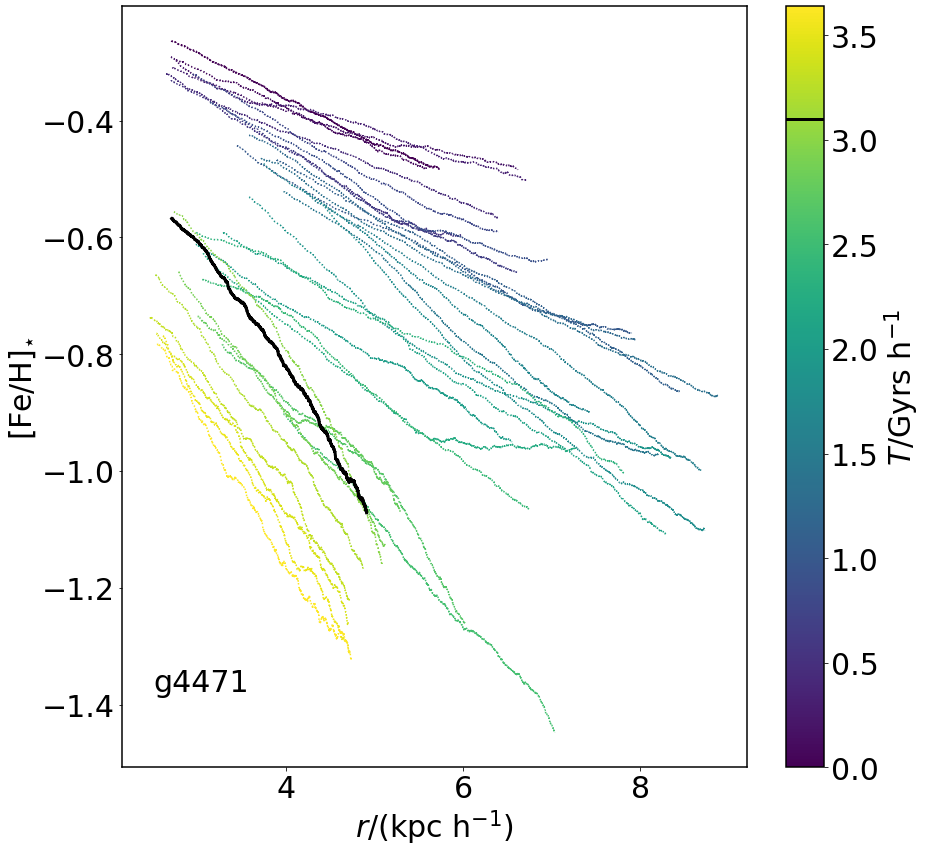

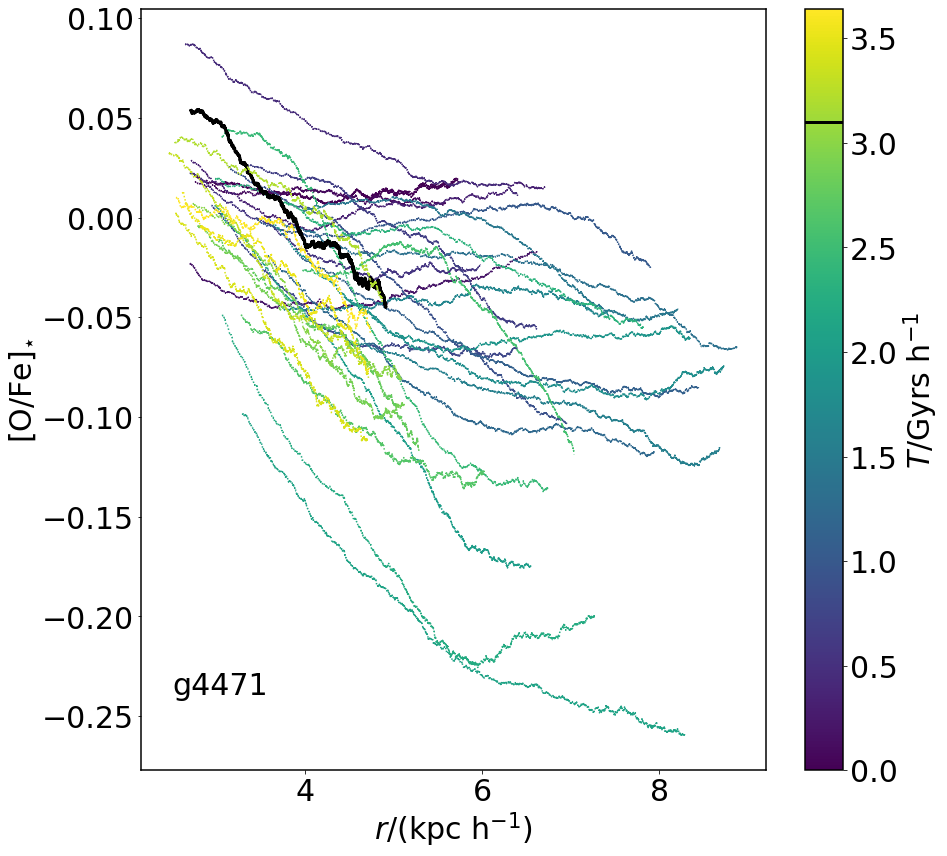

In [34]:
ff, cc = 4471, 4469
xaxis_4474, XF_4474, XO_4474, MassPro_4474, FeHPro_4474, OFePro_4474, AgePro_4474, Times_4474, t1_4474 = getProfilesMob(ff, cc, 30)

pl.figure(figsize=(14, 14))

I = np.arange(Times_4474.size)

cmap = mpc.viridis
norm = pl.Normalize(Times_4474.min(), Times_4474.max())


for xd, md, tm, i in zip(xaxis_4474, MassPro_4474, Times_4474, I):
    if i != t1_4474:
        pl.plot(xd, md, color=cmap(norm(tm)), ls=':')
    else:
        pl.plot(xd, md, color='black', ls='-', lw=3)
        ttt = tm

# pl.semilogy()
bar = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
bar.ax.plot([0, 100], [ttt]*2, ls='-', color='black', lw=3)

pl.xlabel('$r/$(kpc h$^{-1}$)')
pl.ylabel('$\log_e \Sigma_{\star}/(M_{\odot}$ kpc$^{-2} h$)')

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[0]+deltay/1e4, 'g{}'.format(ff))

pl.figure(figsize=(14, 14))

for xd, md, tm, i in zip(xaxis_4474 ,AgePro_4474, Times_4474, I):
    if i != t1_4474:
        pl.plot(xd, np.log10(md)+9., color=cmap(norm(tm)), ls=':')
    else:
        pl.plot(xd, np.log10(md)+9., 'black', ls='-', lw=3)
    
# pl.semilogy()
bar = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
bar.ax.plot([0, 100], [ttt]*2, ls='-', color='black', lw=3)

pl.xlabel('$r/$(kpc h$^{-1}$)')
# pl.ylabel('Age$_{\star}$/(Gyrs h$^{-1}$)')
pl.ylabel('log(Age$_{\star}$/(yr h$^{-1}$))')

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[0]+deltay/1e2, 'g{}'.format(ff))

pl.figure(figsize=(14, 14))

for xd, md, tm, i in zip(XF_4474, FeHPro_4474, Times_4474, I):
    if i != t1_4474:
        pl.plot(xd, md, color=cmap(norm(tm)), ls=':')
    else:
        pl.plot(xd, md, color='black', ls='-', lw=3)
    
bar = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
bar.ax.plot([0, 100], [ttt]*2, ls='-', color='black', lw=3)

pl.xlabel('$r/$(kpc h$^{-1}$)')
pl.ylabel('[Fe/H]$_{\star}$')

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[0]+deltay/10, 'g{}'.format(ff))

pl.figure(figsize=(14, 14))

for xd, md, tm, i in zip(XO_4474, OFePro_4474, Times_4474, I):
    if i != t1_4474:
        pl.plot(xd, md, color=cmap(norm(tm)), ls=':')
    else:
        pl.plot(xd, md, color='black', ls='-', lw=3)
    
bar = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
bar.ax.plot([0, 100], [ttt]*2, ls='-', color='black', lw=3)

pl.xlabel('$r/$(kpc h$^{-1}$)')
pl.ylabel('[O/Fe]$_{\star}$')

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[0]+deltay/10, 'g{}'.format(ff))

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


Text(1.2141272284002296, -0.0940947525424417, 'g4473')

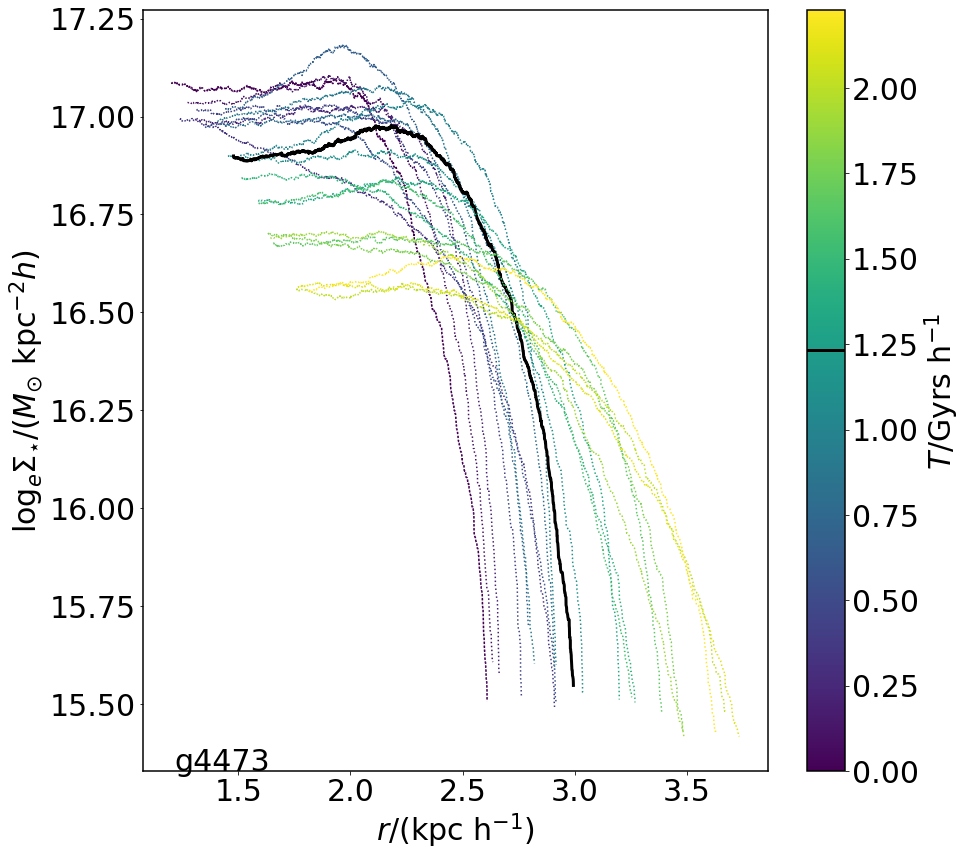

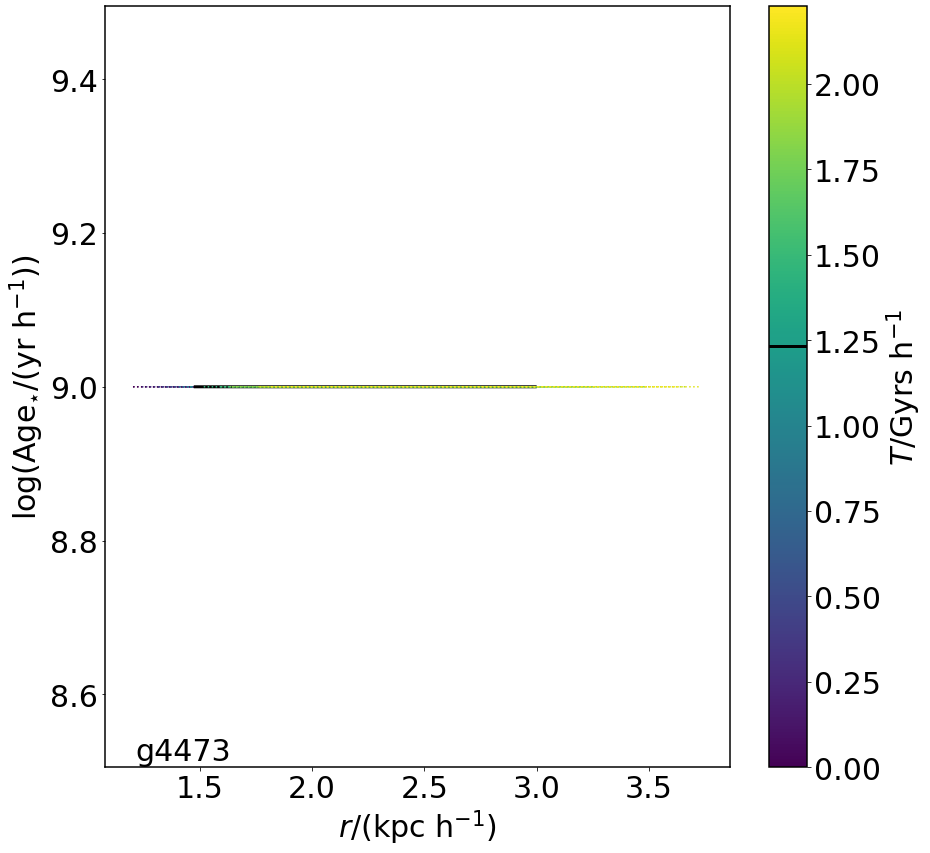

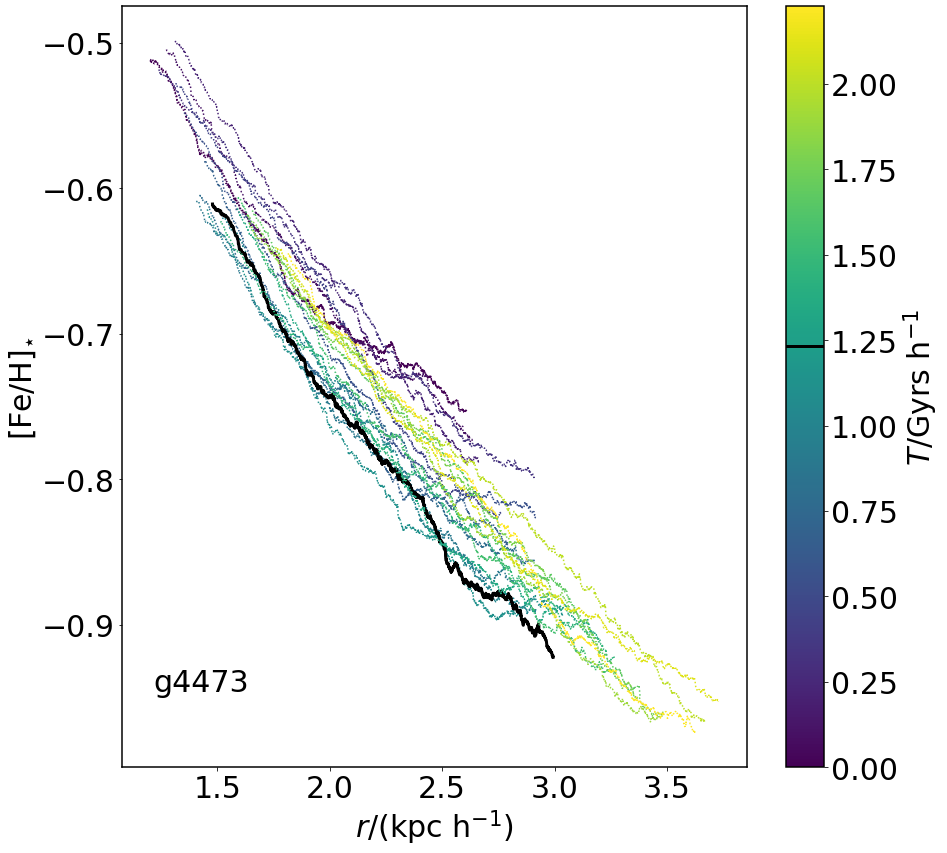

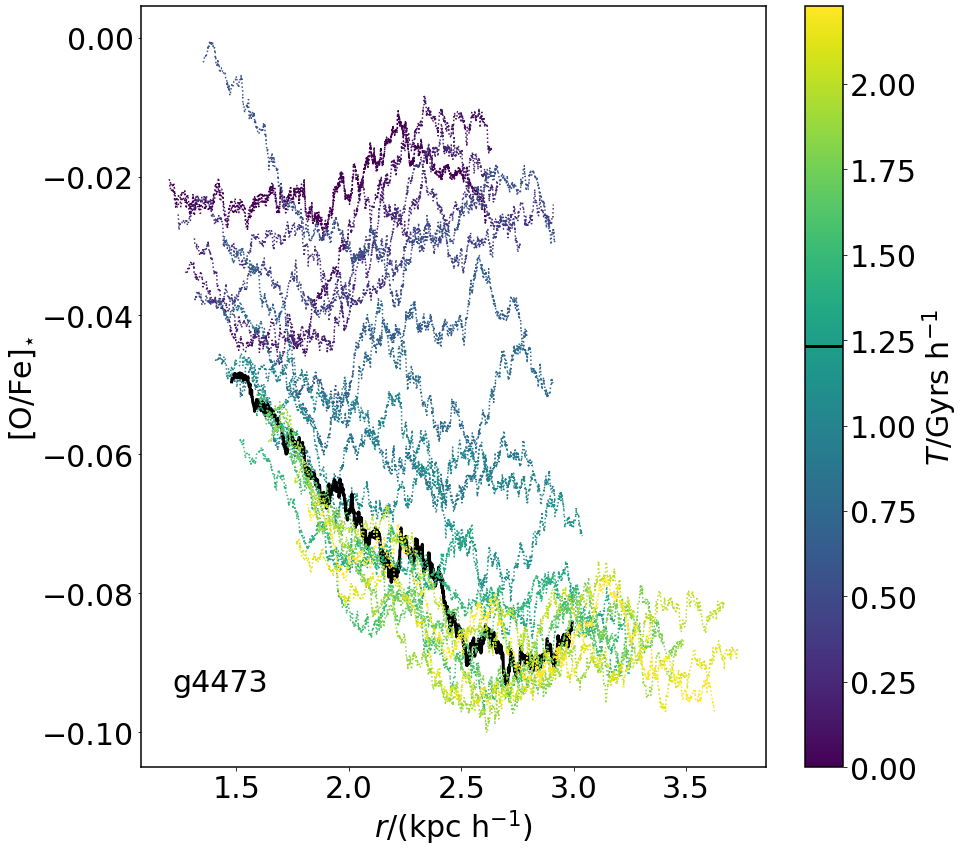

In [35]:
ff, cc = 4473, 4469
xaxis_4474, XF_4474, XO_4474, MassPro_4474, FeHPro_4474, OFePro_4474, AgePro_4474, Times_4474, t1_4474 = getProfilesMob(ff, cc, 30)

pl.figure(figsize=(14, 14))

I = np.arange(Times_4474.size)

cmap = mpc.viridis
norm = pl.Normalize(Times_4474.min(), Times_4474.max())


for xd, md, tm, i in zip(xaxis_4474, MassPro_4474, Times_4474, I):
    if i != t1_4474:
        pl.plot(xd, md, color=cmap(norm(tm)), ls=':')
    else:
        pl.plot(xd, md, color='black', ls='-', lw=3)
        ttt = tm

# pl.semilogy()
bar = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
bar.ax.plot([0, 100], [ttt]*2, ls='-', color='black', lw=3)

pl.xlabel('$r/$(kpc h$^{-1}$)')
pl.ylabel('$\log_e \Sigma_{\star}/(M_{\odot}$ kpc$^{-2} h$)')

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[0]+deltay/1e4, 'g{}'.format(ff))

pl.figure(figsize=(14, 14))

for xd, md, tm, i in zip(xaxis_4474 ,AgePro_4474, Times_4474, I):
    if i != t1_4474:
        pl.plot(xd, np.log10(md)+9., color=cmap(norm(tm)), ls=':')
    else:
        pl.plot(xd, np.log10(md)+9., 'black', ls='-', lw=3)
    
# pl.semilogy()
bar = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
bar.ax.plot([0, 100], [ttt]*2, ls='-', color='black', lw=3)

pl.xlabel('$r/$(kpc h$^{-1}$)')
# pl.ylabel('Age$_{\star}$/(Gyrs h$^{-1}$)')
pl.ylabel('log(Age$_{\star}$/(yr h$^{-1}$))')

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[0]+deltay/1e2, 'g{}'.format(ff))

pl.figure(figsize=(14, 14))

for xd, md, tm, i in zip(XF_4474, FeHPro_4474, Times_4474, I):
    if i != t1_4474:
        pl.plot(xd, md, color=cmap(norm(tm)), ls=':')
    else:
        pl.plot(xd, md, color='black', ls='-', lw=3)
    
bar = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
bar.ax.plot([0, 100], [ttt]*2, ls='-', color='black', lw=3)

pl.xlabel('$r/$(kpc h$^{-1}$)')
pl.ylabel('[Fe/H]$_{\star}$')

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[0]+deltay/10, 'g{}'.format(ff))

pl.figure(figsize=(14, 14))

for xd, md, tm, i in zip(XO_4474, OFePro_4474, Times_4474, I):
    if i != t1_4474:
        pl.plot(xd, md, color=cmap(norm(tm)), ls=':')
    else:
        pl.plot(xd, md, color='black', ls='-', lw=3)
    
bar = pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )
bar.ax.plot([0, 100], [ttt]*2, ls='-', color='black', lw=3)

pl.xlabel('$r/$(kpc h$^{-1}$)')
pl.ylabel('[O/Fe]$_{\star}$')

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[0]+deltay/10, 'g{}'.format(ff))

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


(5.146868166630212,
 0.4054952766354839,
 1.018764436458874,
 0.4561744343368225,
 0.4562344377041794)

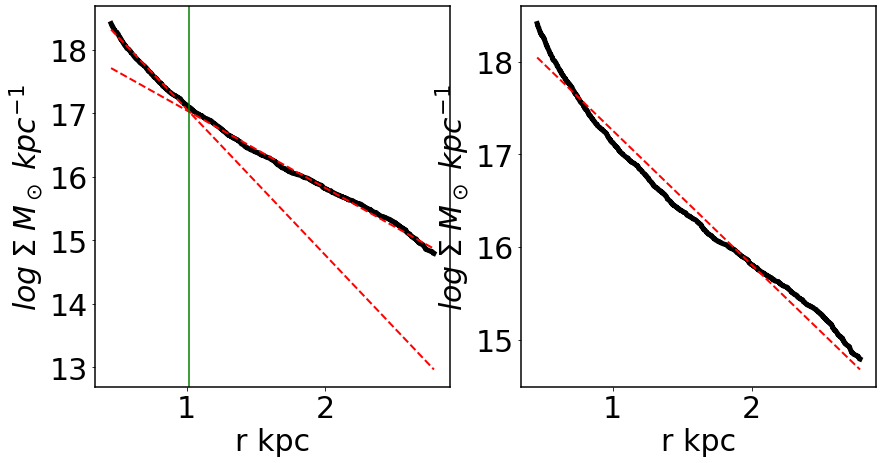

In [36]:
# ok, lets calculate beta at each redshift, lets take a look at z=0 for the fit, anyway.
gal, cen = 4338, 4337
PosGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][gal]

Off = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][gal].astype('int')
R_rot, Lsum = getVec(gal, cen, 128)
posStars = sim['SnapNumber_128/PartType4/Coordinates'][Off[0]:Off[1]]
                
ropt = sim['SnapNumber_128/SubGroups/OpticalRadius'][gal]

f = (1-R_rot[0])/(R_rot[1]**2 + R_rot[2]**2)
R1 = np.array([[0, R_rot[1], R_rot[2]], [-R_rot[1], 0, 0], [-R_rot[2], 0, 0]])
R2 = np.matmul(R1, R1)
                
RM = np.identity(3) + R1 + R2*f

p_POSu = posStars - PosGal
                
RotPos = np.matmul(RM, p_POSu.T)

RR = np.sqrt(RotPos[1]**2+RotPos[2]**2)
                                
Masses = sim['SnapNumber_128/PartType4/Masses'][Off[0]:Off[1]]
                
iR = np.where(RR<1.5*ropt)
               
nbin = np.int(0.2*Masses[iR].size)
Xs, Smass = BF.SDBinMovil(RR[iR],Masses[iR]*1e10,nbin)

# ev = 10
# odd = np.where(np.arange(Xs.size)%ev==0)

# print(odd[0].size)

# Xs, Smass = Xs[odd], Smass[odd]
tp = np.int(Xs.size*0.01)
# tp = 1
bounds=((Xs[tp],0,0,0),(Xs[-tp],np.inf,np.inf,np.inf))

exp = BF.breaks(Xs, Smass, np.zeros_like(Smass))
Lib2exp = exp.DoubleExp(bounds=bounds)

LineT = Lib2exp['LineFit']
Linein,Lineout = Lib2exp['LineFit_in'],Lib2exp['LineFit_out']

pl.figure(figsize=(14,7))

pl.subplot(1, 2, 1)
pl.plot(Xs,Smass,lw=5,c='k')
#plt.plot(LineT[0],LineT[1],c='c',ls='--',lw=3)
pl.plot(Linein[0],Linein[1],c='r',ls='--',lw=2)
pl.plot(Lineout[0],Lineout[1],c='r',ls='--',lw=2)
pl.axvline(Lib2exp['Rbr'], c='g')
pl.ylabel('$log\; \Sigma\; M_\odot \;kpc^{-1}$')
pl.xlabel('r kpc')


Lib1exp = exp.PureExp()
LineT = Lib1exp['LineFit']

pl.subplot(1, 2, 2)

pl.plot(Xs,Smass,lw=5,c='k')
#plt.plot(LineT[0],LineT[1],c='c',ls='--',lw=3)
pl.plot(LineT[0],LineT[1],c='r',ls='--',lw=2)
pl.ylabel('$log\; \Sigma\; M_\odot \;kpc^{-1}$')
pl.xlabel('r kpc')

Lib1exp['ChiSquare'], Lib2exp['ChiSquare'], Lib2exp['Rbr'], Xs[0], Xs[1]

In [37]:
Lib2exp.keys()

dict_keys(['h_i', 'h_o', 'I0i', 'I0o', 'Rbr', 'LineFit', 'LineFit_in', 'LineFit_out', 'ChiSquare', 'pcov'])

In [38]:
Lib2exp['h_i'], Lib2exp['h_o'] 

(0.434586864501449, 0.8181740705462558)

In [39]:
#ok, lets do this the correct way
def getBeta(ff, cc):
    uniqueID = int(128*1e6+ff)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    # and the centre
    uniqueIDC = int(128*1e6+cc)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
#     ropt = sim['SnapNumber_128/SubGroups/OpticalRadius'][ff]
    
    Beta, dist, Xi = [], [], []
    Times = []
    group = sim['SnapNumber_128/SubGroups/GroupNumber'][cc]
    R200 =  sim['SnapNumber_128/Groups/Group_R_Crit200'][group]
    
    for mm, mmC in zip(mtree, mtreeC):
        snap, ffT = split_unique_id(int(mm))
        snapC, ccT = split_unique_id(int(mmC))
        if snap==snapC:
            PosGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][ffT]
            PosCen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][ccT]
            rDist = np.sqrt(np.sum((PosGal-PosCen)**2.))
            if rDist<2*R200:
                dist.append(rDist)
                
                Off = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][ffT].astype('int')
                R_rot, Lsum = getVec(ffT, ccT, snap)
                posStars = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][Off[0]:Off[1]]
                
                ropt = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][ffT]
                
                f = (1-R_rot[0])/(R_rot[1]**2 + R_rot[2]**2)
                R1 = np.array([[0, R_rot[1], R_rot[2]], [-R_rot[1], 0, 0], [-R_rot[2], 0, 0]])
                R2 = np.matmul(R1, R1)
                
                RM = np.identity(3) + R1 + R2*f

                p_POSu = posStars - PosGal
                
                RotPos = np.matmul(RM, p_POSu.T)

                RR = np.sqrt(RotPos[1]**2+RotPos[2]**2)
                
                Masses = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][Off[0]:Off[1]]
                
                z = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
                timenow = Cosmo.lookback_time(z).value
                
                iR = np.where(RR<1.5*ropt)
                
                nbin = np.int(0.2*Masses[iR].size)
                try:
                    Xs, Smass = BF.SDBinMovil(RR[iR],Masses[iR]*1e10,nbin)
                
                    tp = np.int(Xs.size*0.01)
                    # tp = 1
                    bounds=((Xs[tp],0,0,0),(Xs[-1],np.inf,np.inf,np.inf))

                    exp = BF.breaks(Xs, Smass, np.zeros_like(Smass))
                    Lib2exp = exp.DoubleExp(bounds=bounds)
                
                    bb = Lib2exp['h_i'] - Lib2exp['h_o']
                    chi = Lib2exp['ChiSquare']
                except IndexError:
                    bb = np.nan
                    chi = np.nan
                
                Times.append(timenow)
                Beta.append(bb)
                Xi.append(chi)
                
    
    #xaxis = 0.5*(xbins[1:] + xbins[:-1])
    
    dist = np.array(dist)
    t = np.where(dist<=R200)[0]
    t1 = t.max()
    

    Beta = np.array(Beta)
    Xi = np.array(Xi)
    
    Times = np.array(Times)
    
    return Beta, Xi,dist, Times, t1

In [40]:
Beta_4338, Xi_4338, dist_4338, Times_4338, t1_4338 = getBeta(4338, 4337)
Beta_4339, Xi_4339, dist_4339, Times_4339, t1_4339 = getBeta(4339, 4337)
Beta_4341, Xi_4341, dist_4341, Times_4341, t1_4341 = getBeta(4341, 4337)
Beta_4343, Xi_4343, dist_4343, Times_4343, t1_4343 = getBeta(4343, 4337)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/disk2/home/srodriguez/cielo_tutorial/notebooks/BreakFinder.py:149: RuntimeWarning: invalid value encountered in true_divide
  Sigma.append(SumM/S)


In [41]:
Beta_4470, Xi_4470, dist_4470, Times_4470, t1_4470 = getBeta(4470, 4469)
Beta_4471, Xi_4471, dist_4471, Times_4471, t1_4471 = getBeta(4471, 4469)
Beta_4473, Xi_4473, dist_4473, Times_4473, t1_4473 = getBeta(4473, 4469)
Beta_4474, Xi_4474, dist_4474, Times_4474, t1_4474 = getBeta(4474, 4469)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


(-10.0, 10.0)

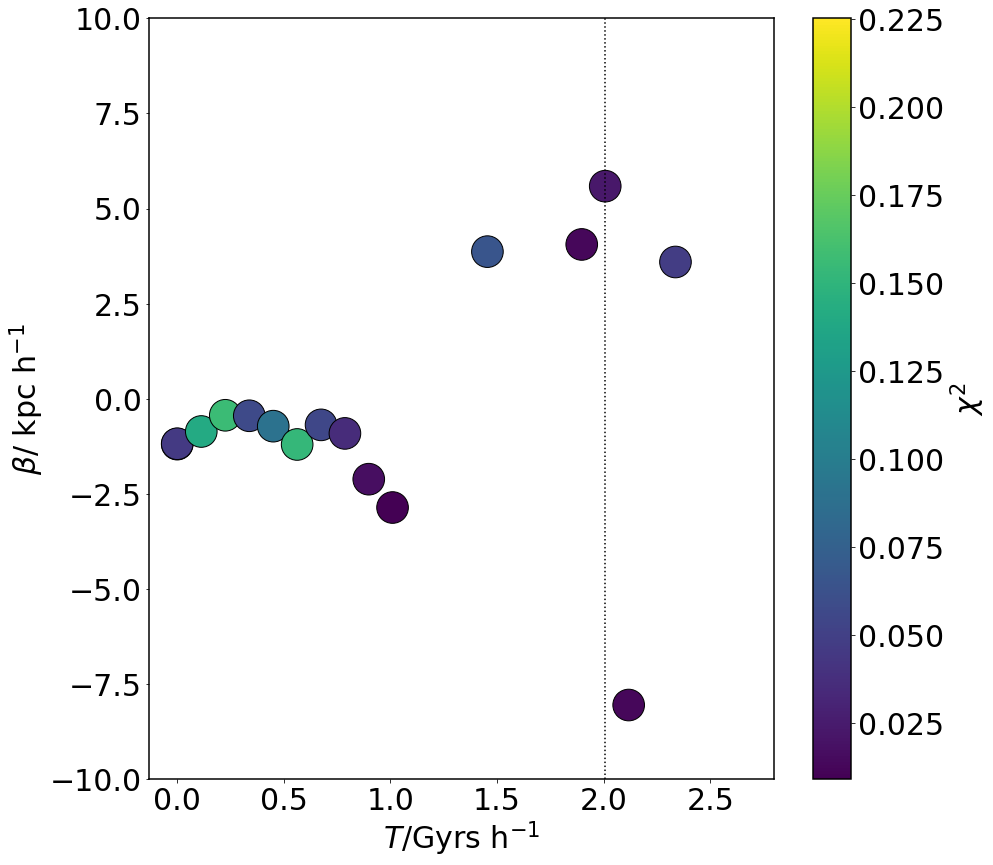

In [42]:
pl.figure(figsize=(14,14))

ii = np.where(Xi_4338<2.2)

pl.scatter(Times_4338[ii], Beta_4338[ii], c=Xi_4338[ii], s=1000, edgecolors='black')
bar = pl.colorbar(label='$\\chi^2$')
pl.axvline(Times_4338[t1_4338], c='black', ls=':')

pl.xlabel('$T$/Gyrs h$^{-1}$')
pl.ylabel('$\\beta/$ kpc h$^{-1}$')

pl.ylim(-10,10)

(-10.0, 10.0)

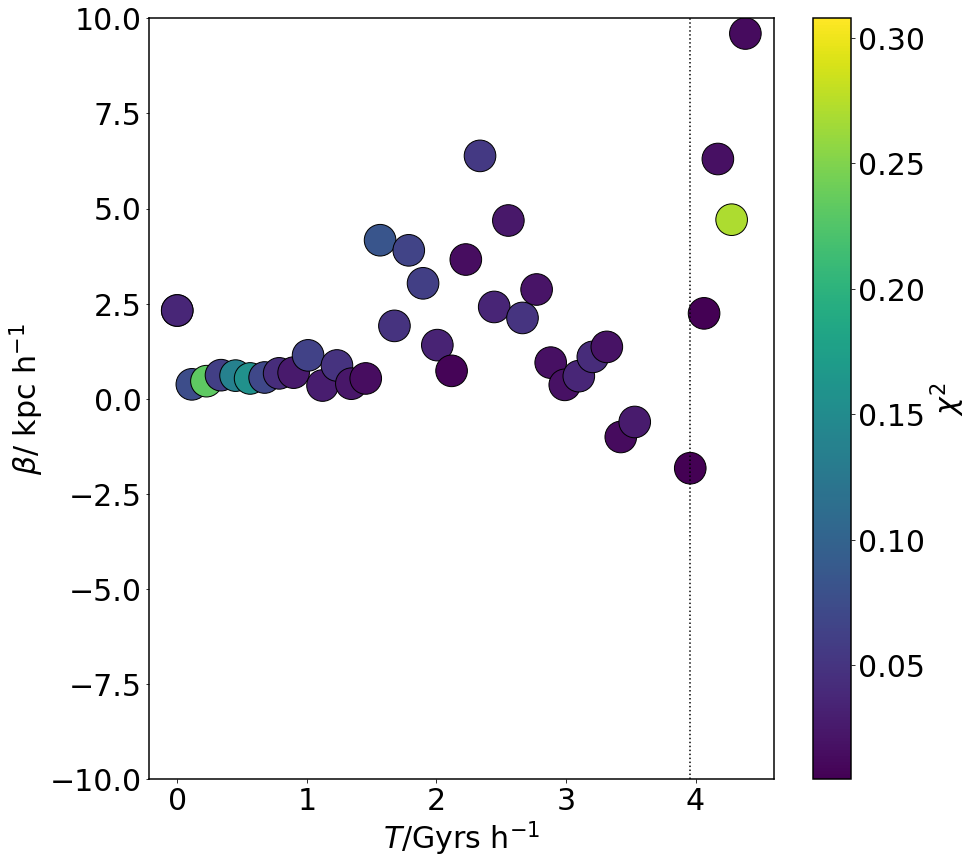

In [43]:
pl.figure(figsize=(14,14))

ii = np.where(Xi_4339<2.2)
pl.scatter(Times_4339[ii], Beta_4339[ii], c=Xi_4339[ii], s=1000, edgecolors='black')
bar = pl.colorbar(label='$\\chi^2$')
pl.axvline(Times_4339[t1_4339], c='black', ls=':')

pl.xlabel('$T$/Gyrs h$^{-1}$')
pl.ylabel('$\\beta/$ kpc h$^{-1}$')

pl.ylim(-10,10)

(-10.0, 10.0)

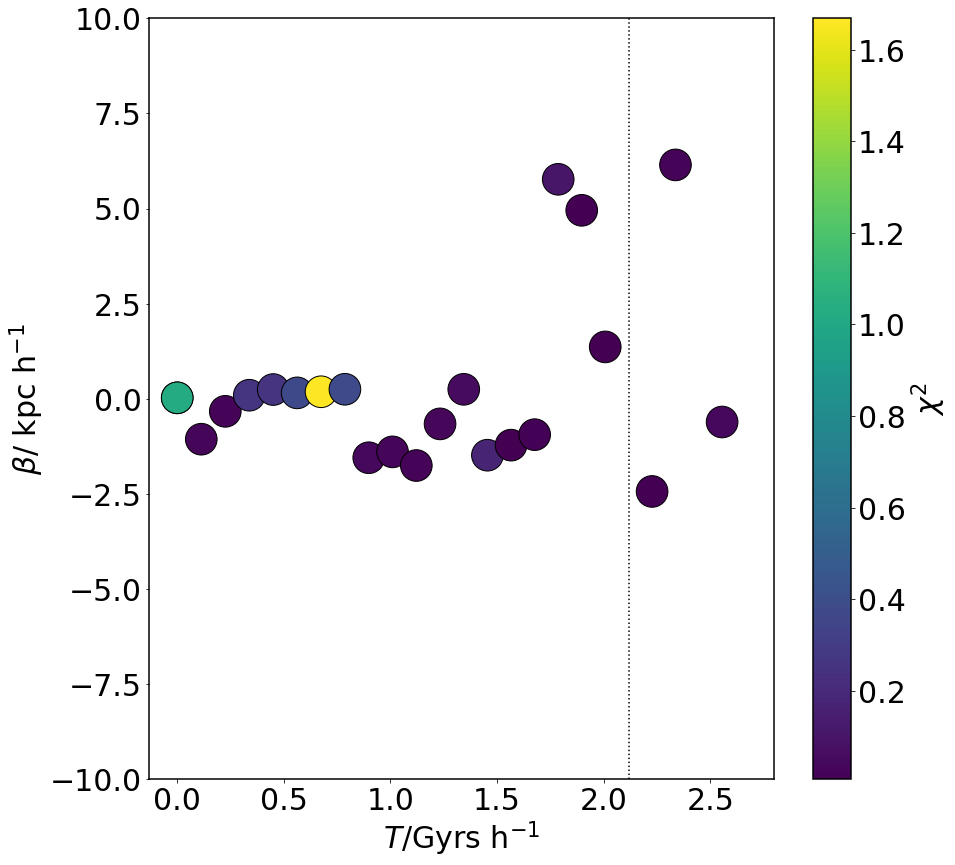

In [44]:
pl.figure(figsize=(14,14))

ii = np.where(Xi_4341<2.2)
pl.scatter(Times_4341[ii], Beta_4341[ii], c=Xi_4341[ii], s=1000, edgecolors='black')
bar = pl.colorbar(label='$\\chi^2$')
pl.axvline(Times_4341[t1_4341], c='black', ls=':')

pl.xlabel('$T$/Gyrs h$^{-1}$')
pl.ylabel('$\\beta/$ kpc h$^{-1}$')

pl.ylim(-10,10)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


(-10.0, 10.0)

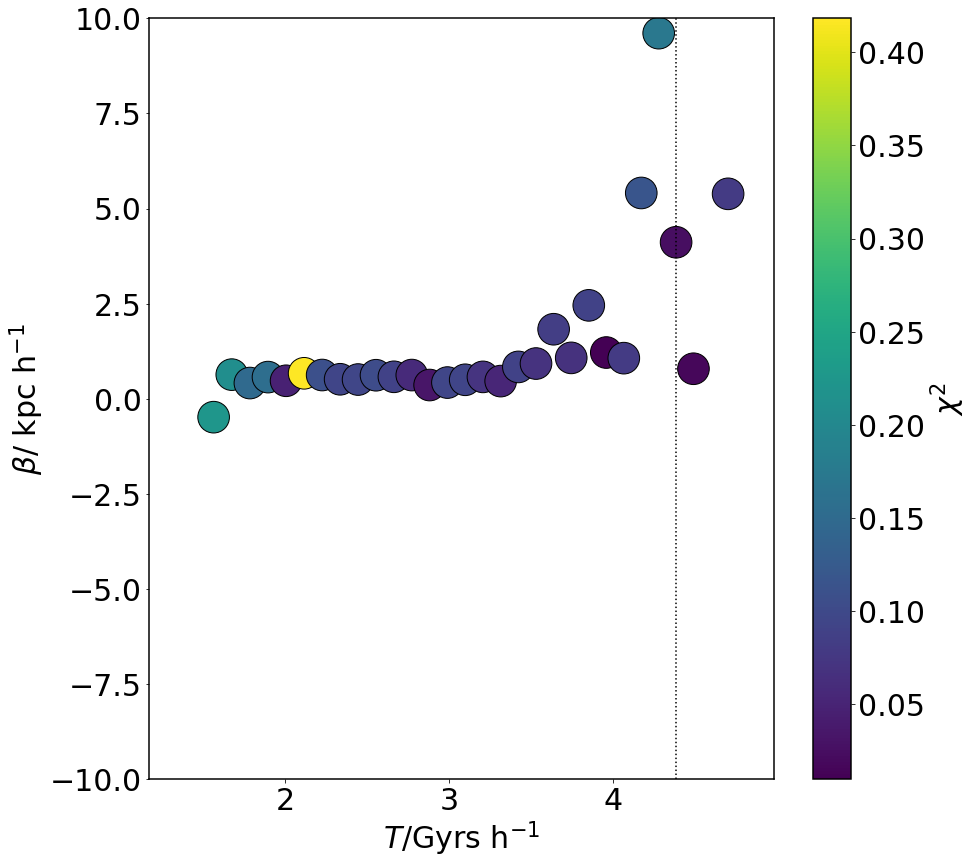

In [45]:
pl.figure(figsize=(14,14))

ii = np.where(Xi_4343<2.2)
pl.scatter(Times_4343[ii], Beta_4343[ii], c=Xi_4343[ii], s=1000, edgecolors='black')
bar = pl.colorbar(label='$\\chi^2$')
pl.axvline(Times_4343[t1_4343], c='black', ls=':')

pl.xlabel('$T$/Gyrs h$^{-1}$')
pl.ylabel('$\\beta/$ kpc h$^{-1}$')

pl.ylim(-10,10)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


(-10.0, 10.0)

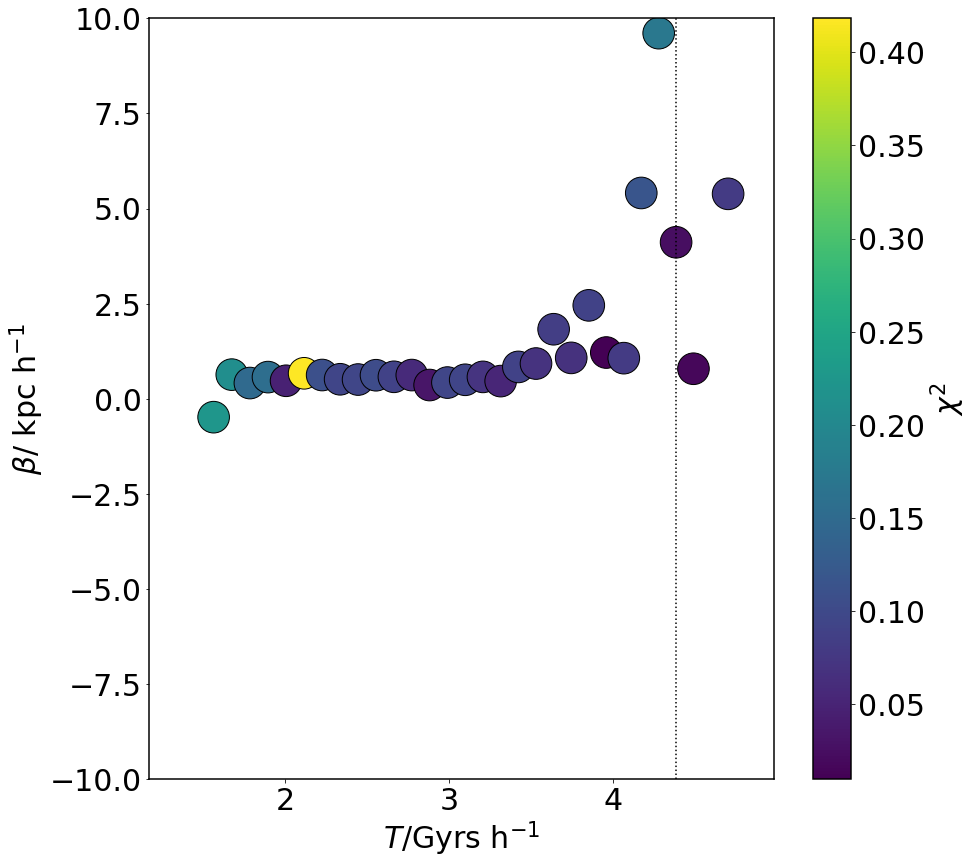

In [46]:
pl.figure(figsize=(14,14))

ii = np.where(Xi_4343<2.2)
pl.scatter(Times_4343[ii], Beta_4343[ii], c=Xi_4343[ii], s=1000, edgecolors='black')
bar = pl.colorbar(label='$\\chi^2$')
pl.axvline(Times_4343[t1_4343], c='black', ls=':')

pl.xlabel('$T$/Gyrs h$^{-1}$')
pl.ylabel('$\\beta/$ kpc h$^{-1}$')

pl.ylim(-10,10)

(-100.0, 100.0)

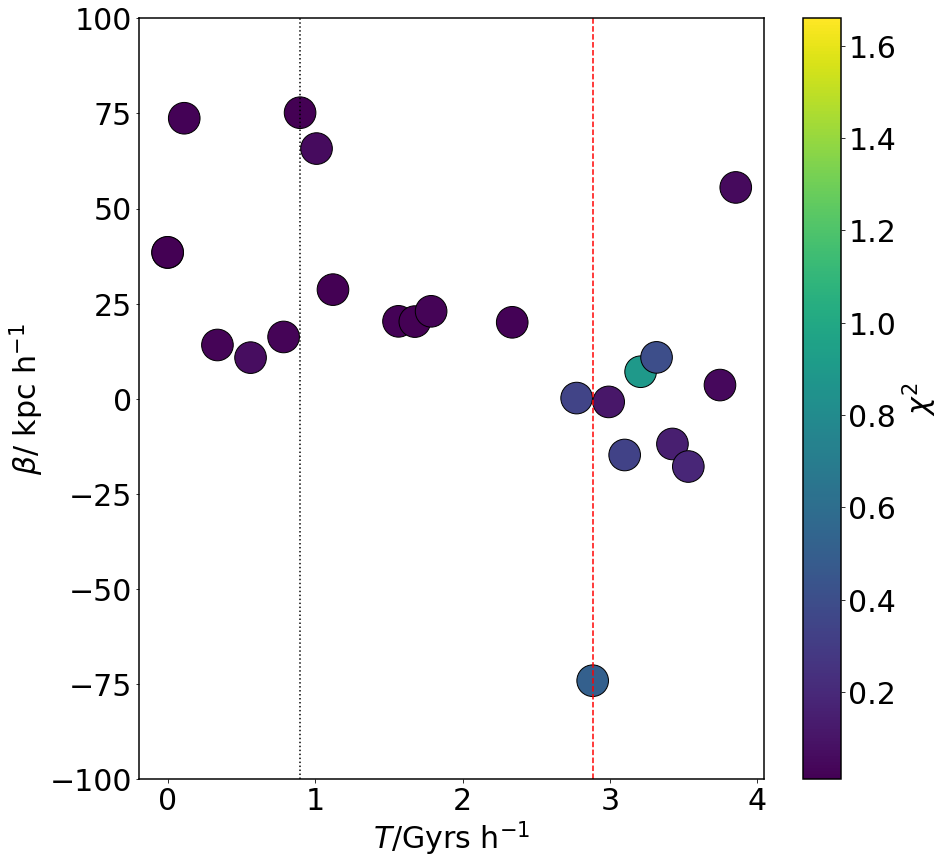

In [68]:
pl.figure(figsize=(14,14))

ii = np.where(Xi_4470<2.2)
pl.scatter(Times_4470[ii], Beta_4470[ii], c=Xi_4470[ii], s=1000, edgecolors='black')
bar = pl.colorbar(label='$\\chi^2$')
pl.axvline(Times_4470[t1_4470], c='black', ls=':')
pl.axvline(tmerger, c='red', ls='--')

pl.xlabel('$T$/Gyrs h$^{-1}$')
pl.ylabel('$\\beta/$ kpc h$^{-1}$')

pl.ylim(-100,100)

(-100.0, 100.0)

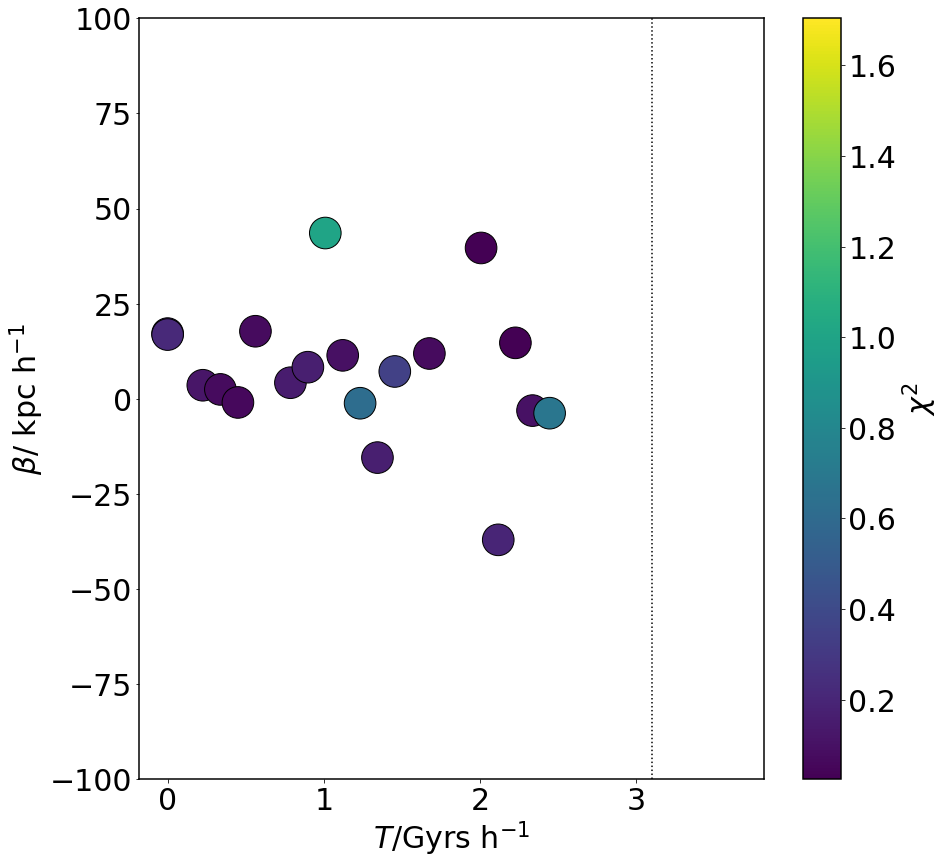

In [70]:
pl.figure(figsize=(14,14))

ii = np.where(Xi_4471<2.2)
pl.scatter(Times_4471[ii], Beta_4471[ii], c=Xi_4471[ii], s=1000, edgecolors='black')
#pl.scatter(Times_4471, Beta_4471, c=Xi_4471, s=1000, edgecolors='black')
bar = pl.colorbar(label='$\\chi^2$')
pl.axvline(Times_4471[t1_4471], c='black', ls=':')

pl.xlabel('$T$/Gyrs h$^{-1}$')
pl.ylabel('$\\beta/$ kpc h$^{-1}$')

pl.ylim(-100,100)

(-10.0, 40.0)

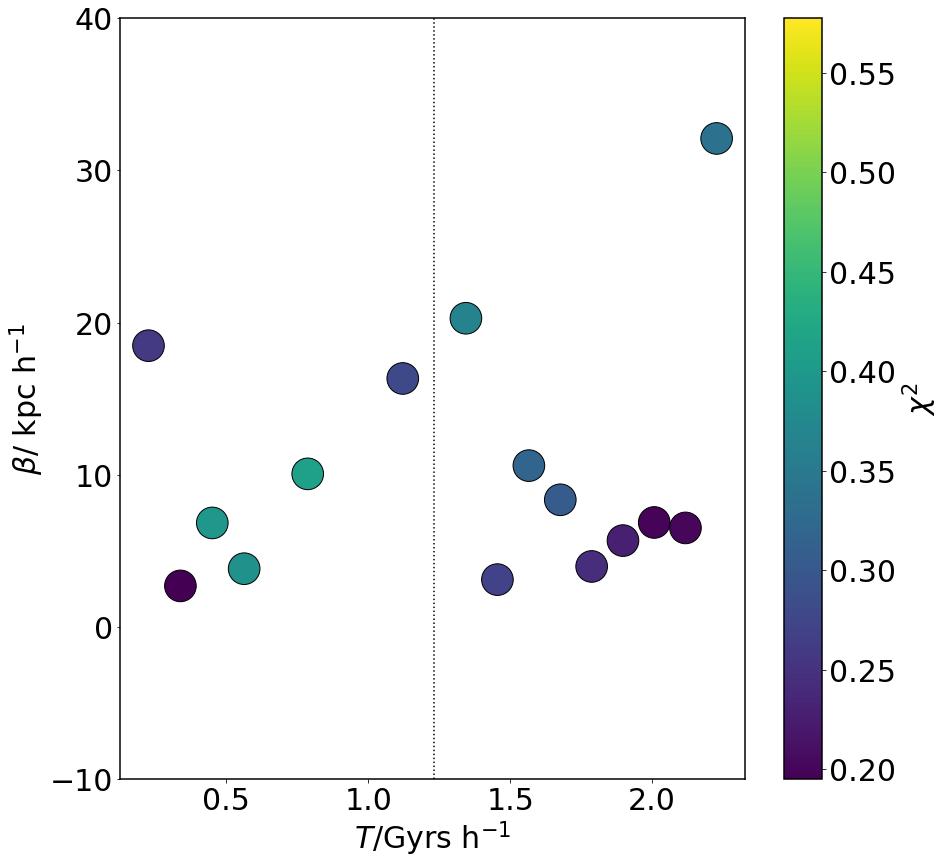

In [73]:
pl.figure(figsize=(14,14))

ii = np.where(Xi_4473<2.2)
pl.scatter(Times_4473[ii], Beta_4473[ii], c=Xi_4473[ii], s=1000, edgecolors='black')
bar = pl.colorbar(label='$\\chi^2$')
pl.axvline(Times_4473[t1_4473], c='black', ls=':')

pl.xlabel('$T$/Gyrs h$^{-1}$')
pl.ylabel('$\\beta/$ kpc h$^{-1}$')

pl.ylim(-10,40)

(-10.0, 10.0)

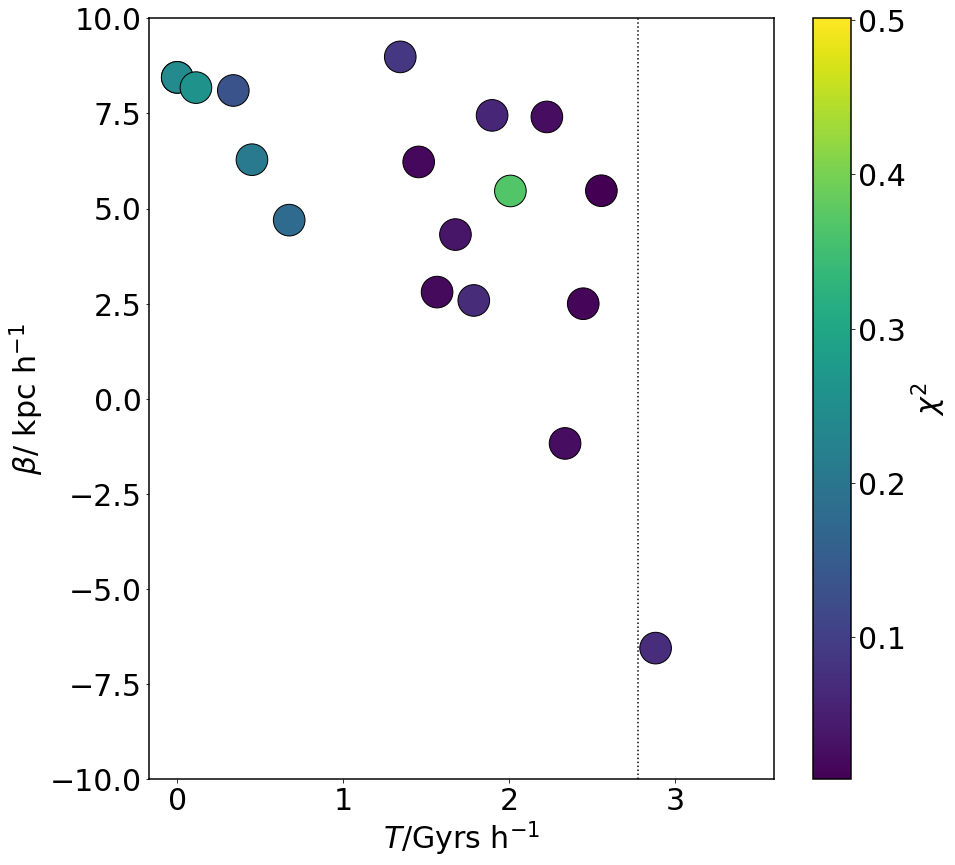

In [50]:
pl.figure(figsize=(14,14))

ii = np.where(Xi_4474<2.2)
pl.scatter(Times_4474[ii], Beta_4474[ii], c=Xi_4474[ii], s=1000, edgecolors='black')
bar = pl.colorbar(label='$\\chi^2$')
pl.axvline(Times_4474[t1_4474], c='black', ls=':')

pl.xlabel('$T$/Gyrs h$^{-1}$')
pl.ylabel('$\\beta/$ kpc h$^{-1}$')

pl.ylim(-10,10)

In [51]:
# idk, compare this with the other things maybe. this sounds like a plan.
T = h5py.File('Derived_Data_3.h5', 'r')


dist_4338 = T['g4338/distance'][()]
Time_4338 = T['g4338/time'][()]
cosC_4338 = T['g4338/CosCen'][()]
cosV_4338 = T['g4338/CosVel'][()]
RP_4338 = T['g4338/RP'][()]
TSt_4338 = T['g4338/TSt'][()]
gMass_4338 = T['g4338/gMass'][()]
SFR_4338 = T['g4338/SFR'][()]
starMass_4338 = T['g4338/starMass'][()]
Gas_4338 = T['g4338/Gas'][()]
RestForce_4338 = T['g4338/RestForce'][()]

dist_4339 = T['g4339/distance'][()]
Time_4339 = T['g4339/time'][()]
cosC_4339 = T['g4339/CosCen'][()]
cosV_4339 = T['g4339/CosVel'][()]
RP_4339 = T['g4339/RP'][()]
TSt_4339 = T['g4339/TSt'][()]
gMass_4339 = T['g4339/gMass'][()]
SFR_4339 = T['g4339/SFR'][()]
starMass_4339 = T['g4339/starMass'][()]
Gas_4339 = T['g4339/Gas'][()]
RestForce_4339 = T['g4339/RestForce'][()]

dist_4341 = T['g4341/distance'][()]
Time_4341 = T['g4341/time'][()]
cosC_4341 = T['g4341/CosCen'][()]
cosV_4341 = T['g4341/CosVel'][()]
RP_4341 = T['g4341/RP'][()]
TSt_4341 = T['g4341/TSt'][()]
gMass_4341 = T['g4341/gMass'][()]
SFR_4341 = T['g4341/SFR'][()]
starMass_4341 = T['g4341/starMass'][()]
Gas_4341 = T['g4341/Gas'][()]
RestForce_4341 = T['g4341/RestForce'][()]

dist_4343 = T['g4343/distance'][()]
Time_4343 = T['g4343/time'][()]
cosC_4343 = T['g4343/CosCen'][()]
cosV_4343 = T['g4343/CosVel'][()]
RP_4343 = T['g4343/RP'][()]
TSt_4343 = T['g4343/TSt'][()]
gMass_4343 = T['g4343/gMass'][()]
SFR_4343 = T['g4343/SFR'][()]
starMass_4343 = T['g4343/starMass'][()]
Gas_4343 = T['g4343/Gas'][()]
RestForce_4343 = T['g4343/RestForce'][()]

dist_4470 = T['g4470/distance'][()]
Time_4470 = T['g4470/time'][()]
cosC_4470 = T['g4470/CosCen'][()]
cosV_4470 = T['g4470/CosVel'][()]
RP_4470 = T['g4470/RP'][()]
TSt_4470 = T['g4470/TSt'][()]
gMass_4470 = T['g4470/gMass'][()]
SFR_4470 = T['g4470/SFR'][()]
starMass_4470 = T['g4470/starMass'][()]
Gas_4470 = T['g4470/Gas'][()]
RestForce_4470 = T['g4470/RestForce'][()]

dist_4471 = T['g4471/distance'][()]
Time_4471 = T['g4471/time'][()]
cosC_4471 = T['g4471/CosCen'][()]
cosV_4471 = T['g4471/CosVel'][()]
RP_4471 = T['g4471/RP'][()]
TSt_4471 = T['g4471/TSt'][()]
gMass_4471 = T['g4471/gMass'][()]
SFR_4471 = T['g4471/SFR'][()]
starMass_4471 = T['g4471/starMass'][()]
Gas_4471 = T['g4471/Gas'][()]
RestForce_4471 = T['g4471/RestForce'][()]

dist_4473 = T['g4473/distance'][()]
Time_4473 = T['g4473/time'][()]
cosC_4473 = T['g4473/CosCen'][()]
cosV_4473 = T['g4473/CosVel'][()]
RP_4473 = T['g4473/RP'][()]
TSt_4473 = T['g4473/TSt'][()]
gMass_4473 = T['g4473/gMass'][()]
SFR_4473 = T['g4473/SFR'][()]
starMass_4473 = T['g4473/starMass'][()]
Gas_4473 = T['g4473/Gas'][()]
RestForce_4473 = T['g4473/RestForce'][()]

dist_4474 = T['g4474/distance'][()]
Time_4474 = T['g4474/time'][()]
cosC_4474 = T['g4474/CosCen'][()]
cosV_4474 = T['g4474/CosVel'][()]
RP_4474 = T['g4474/RP'][()]
TSt_4474 = T['g4474/TSt'][()]
gMass_4474 = T['g4474/gMass'][()]
SFR_4474 = T['g4474/SFR'][()]
starMass_4474 = T['g4474/starMass'][()]
Gas_4474 = T['g4474/Gas'][()]
RestForce_4474 = T['g4474/RestForce'][()]

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, '$T$/Gyrs h$^{-1}$')

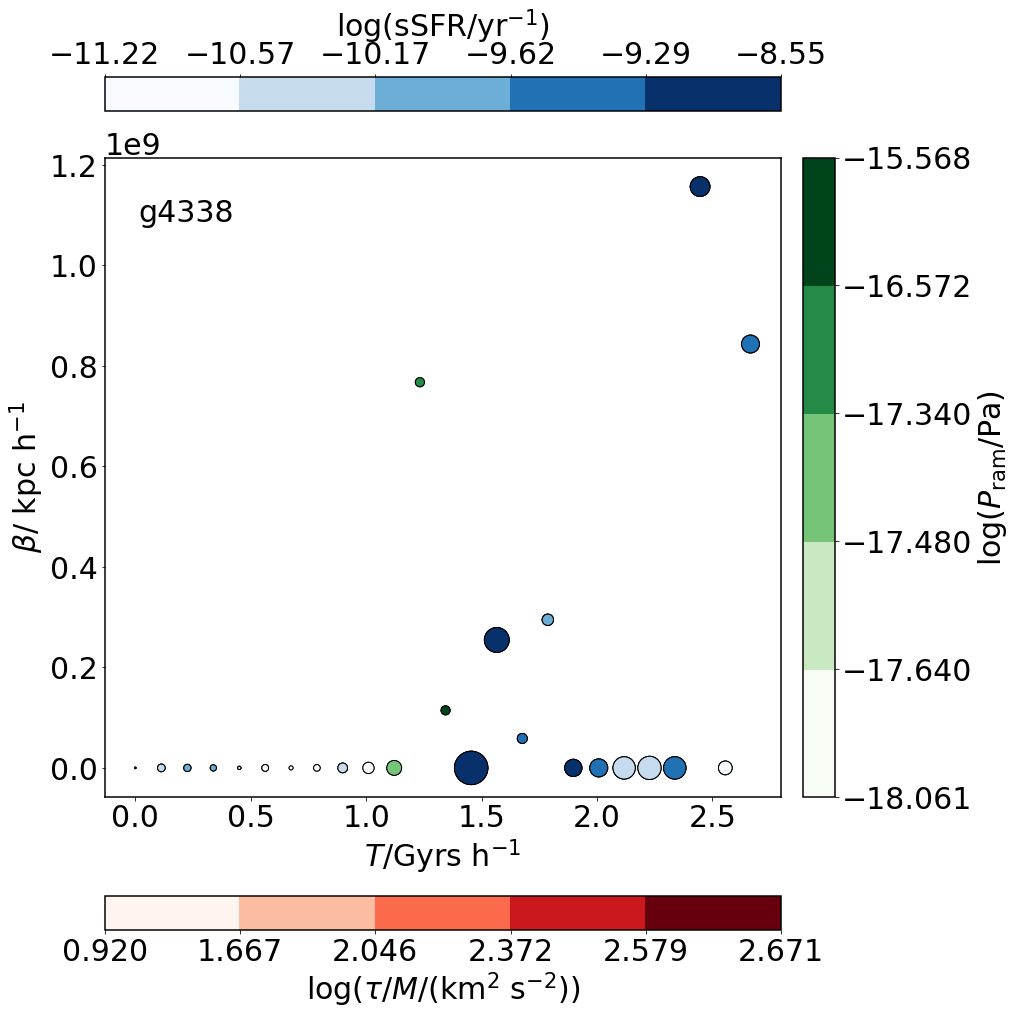

In [52]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 6)
papels = np.percentile(np.log10(TSt_4338/gMass_4338), vaper)
norm = mpco.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4338, Beta_4338, s=Gas_4338/5e5, c=np.log10(TSt_4338/gMass_4338), norm=norm, cmap=mpc.Reds, edgecolors='black')
barT = pl.colorbar(label='log($\\tau/M$/(km$^2$ s$^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4338), vaper)
norm2 = mpco.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4338, Beta_4338+0.5, s=Gas_4338/5e5, c=np.log10(RP_4338), norm=norm2, cmap=mpc.Greens, edgecolors='black')
barRP = pl.colorbar(label='$\log(P_{\\rm ram}$/Pa$)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4338/starMass_4338)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpco.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4338, Beta_4338+1., s=Gas_4338/5e5, c=lsSFR, norm=norm3, cmap=mpc.Blues, edgecolors='black')
bar3 = pl.colorbar(label='$\log($sSFR/yr$^{-1})$', location='top')
bar3.set_ticks(papels3)


xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[1]-deltay/10., 'g4338')

pl.ylabel('$\\beta/$ kpc h$^{-1}$')
pl.xlabel('$T$/Gyrs h$^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, '$T$/Gyrs h$^{-1}$')

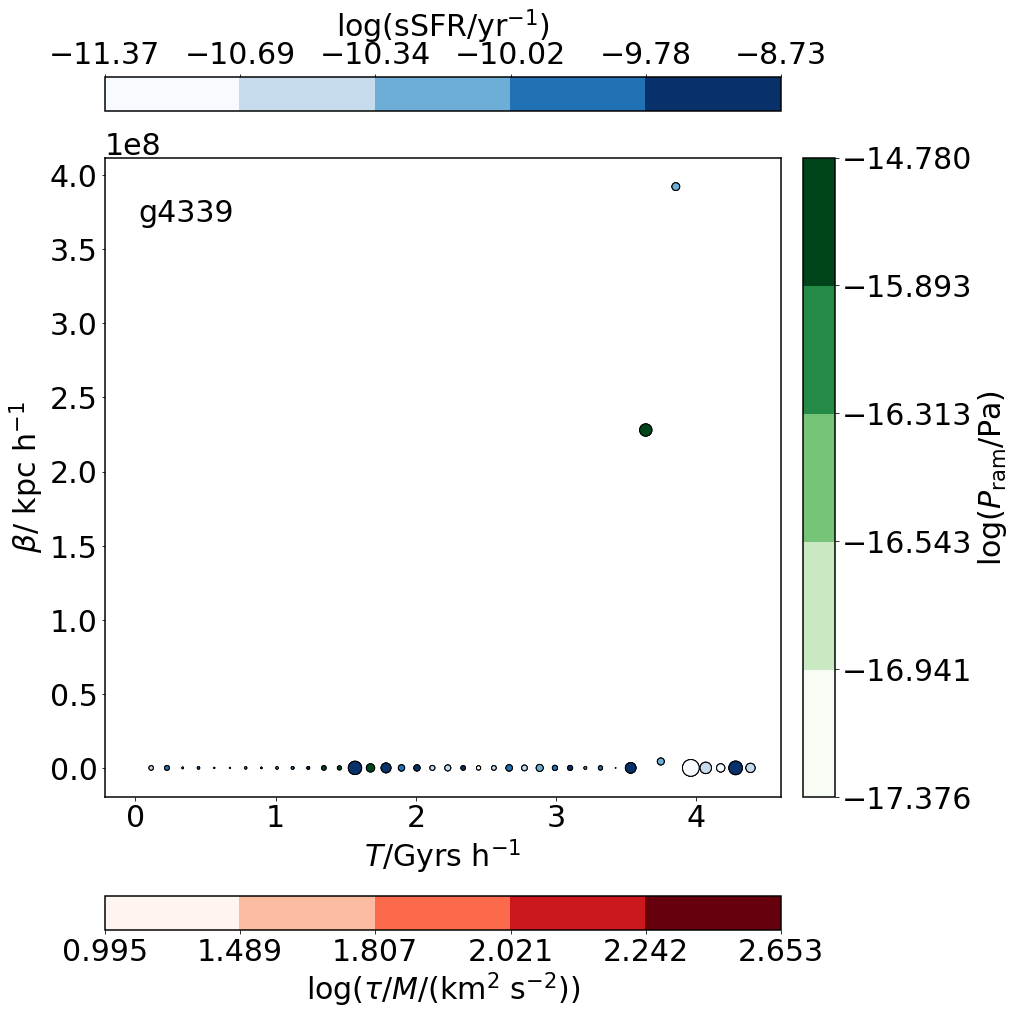

In [53]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 6)
papels = np.percentile(np.log10(TSt_4339/gMass_4339), vaper)
norm = mpco.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4339, Beta_4339, s=Gas_4339/5e5, c=np.log10(TSt_4339/gMass_4339), norm=norm, cmap=mpc.Reds, edgecolors='black')
barT = pl.colorbar(label='log($\\tau/M$/(km$^2$ s$^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4339), vaper)
norm2 = mpco.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4339, Beta_4339+0.5, s=Gas_4339/5e5, c=np.log10(RP_4339), norm=norm2, cmap=mpc.Greens, edgecolors='black')
barRP = pl.colorbar(label='$\log(P_{\\rm ram}$/Pa$)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4339/starMass_4339)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpco.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4339, Beta_4339+1., s=Gas_4339/5e5, c=lsSFR, norm=norm3, cmap=mpc.Blues, edgecolors='black')
bar3 = pl.colorbar(label='$\log($sSFR/yr$^{-1})$', location='top')
bar3.set_ticks(papels3)


xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[1]-deltay/10., 'g4339')

pl.ylabel('$\\beta/$ kpc h$^{-1}$')
pl.xlabel('$T$/Gyrs h$^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, '$T$/Gyrs h$^{-1}$')

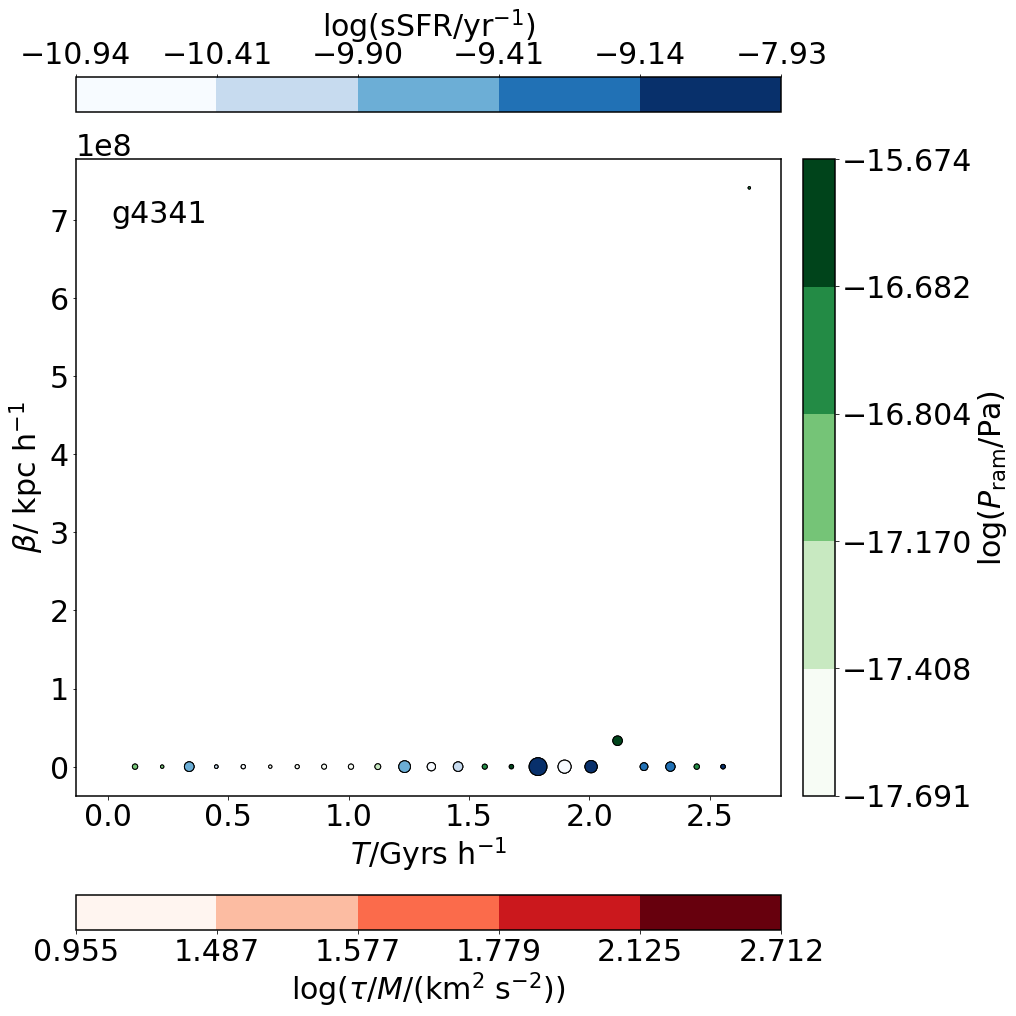

In [54]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 6)
papels = np.percentile(np.log10(TSt_4341/gMass_4341), vaper)
norm = mpco.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4341, Beta_4341, s=Gas_4341/5e5, c=np.log10(TSt_4341/gMass_4341), norm=norm, cmap=mpc.Reds, edgecolors='black')
barT = pl.colorbar(label='log($\\tau/M$/(km$^2$ s$^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4341), vaper)
norm2 = mpco.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4341, Beta_4341+0.5, s=Gas_4341/5e5, c=np.log10(RP_4341), norm=norm2, cmap=mpc.Greens, edgecolors='black')
barRP = pl.colorbar(label='$\log(P_{\\rm ram}$/Pa$)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4341/starMass_4341)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpco.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4341, Beta_4341+1., s=Gas_4341/5e5, c=lsSFR, norm=norm3, cmap=mpc.Blues, edgecolors='black')
bar3 = pl.colorbar(label='$\log($sSFR/yr$^{-1})$', location='top')
bar3.set_ticks(papels3)


xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[1]-deltay/10., 'g4341')

pl.ylabel('$\\beta/$ kpc h$^{-1}$')
pl.xlabel('$T$/Gyrs h$^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, '$T$/Gyrs h$^{-1}$')

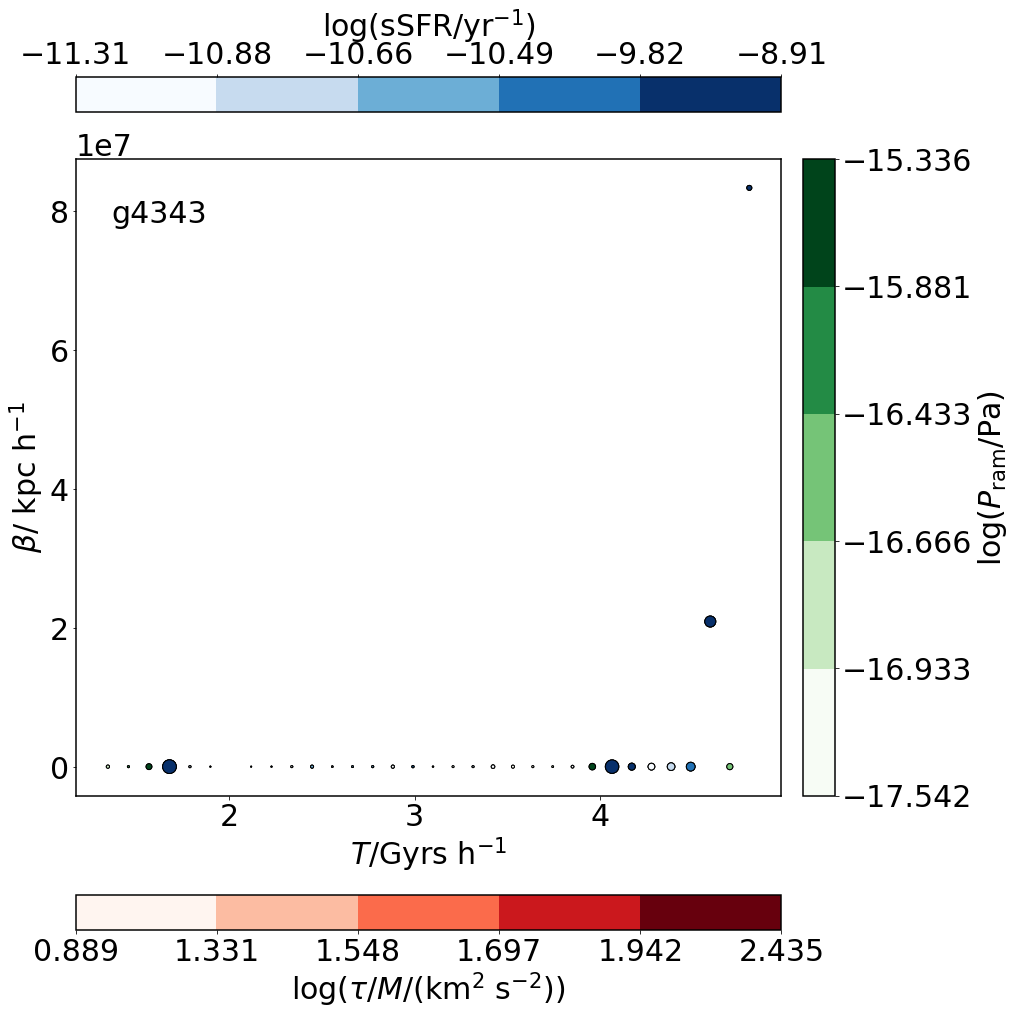

In [55]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 6)
papels = np.percentile(np.log10(TSt_4343/gMass_4343), vaper)
norm = mpco.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4343, Beta_4343, s=Gas_4343/5e5, c=np.log10(TSt_4343/gMass_4343), norm=norm, cmap=mpc.Reds, edgecolors='black')
barT = pl.colorbar(label='log($\\tau/M$/(km$^2$ s$^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4343), vaper)
norm2 = mpco.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4343, Beta_4343+0.5, s=Gas_4343/5e5, c=np.log10(RP_4343), norm=norm2, cmap=mpc.Greens, edgecolors='black')
barRP = pl.colorbar(label='$\log(P_{\\rm ram}$/Pa$)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4343/starMass_4343)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpco.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4343, Beta_4343+1., s=Gas_4343/5e5, c=lsSFR, norm=norm3, cmap=mpc.Blues, edgecolors='black')
bar3 = pl.colorbar(label='$\log($sSFR/yr$^{-1})$', location='top')
bar3.set_ticks(papels3)


xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[1]-deltay/10., 'g4343')

pl.ylabel('$\\beta/$ kpc h$^{-1}$')
pl.xlabel('$T$/Gyrs h$^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, '$T$/Gyrs h$^{-1}$')

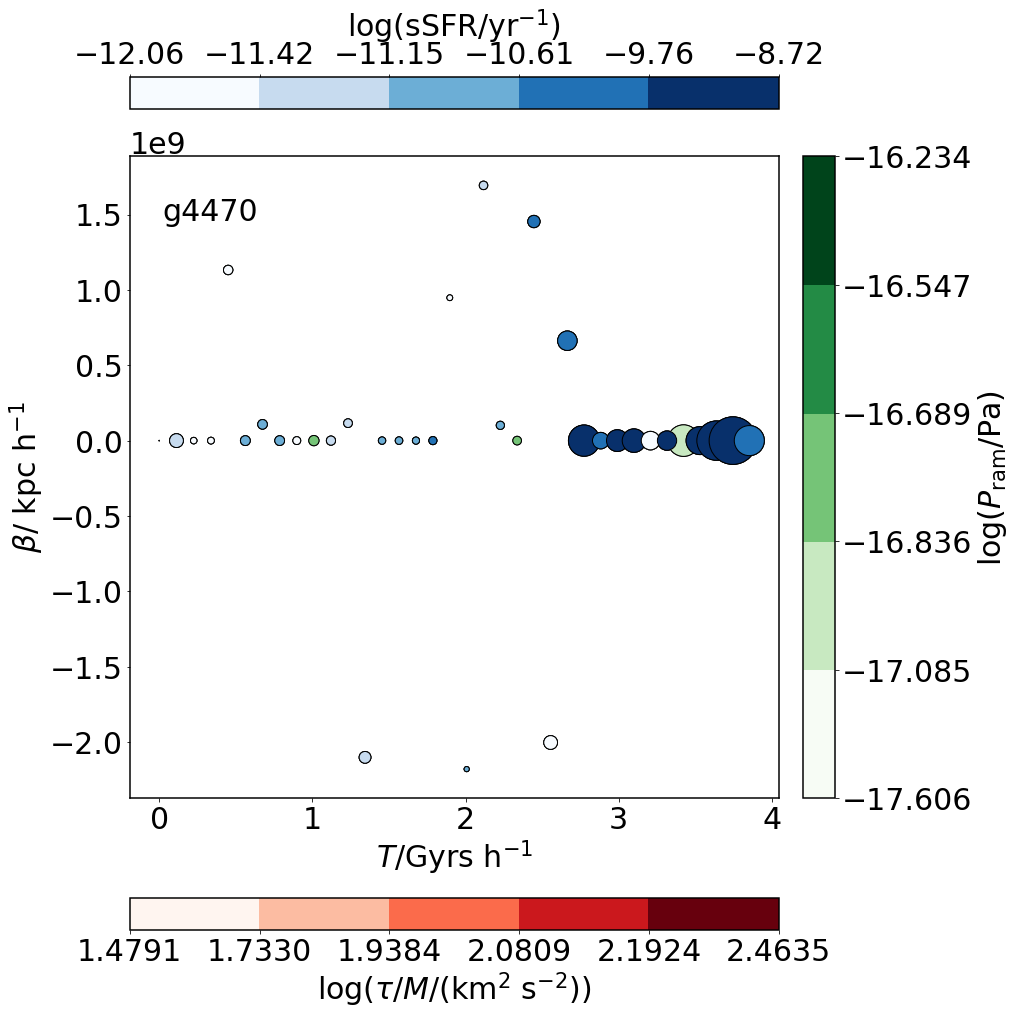

In [56]:
pl.figure(figsize=(14,14), constrained_layout=True)



vaper = np.linspace(0, 100, 6)
papels = np.percentile(np.log10(TSt_4470/gMass_4470), vaper)
norm = mpco.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4470, Beta_4470, s=Gas_4470/5e5, c=np.log10(TSt_4470/gMass_4470), norm=norm, cmap=mpc.Reds, edgecolors='black')
barT = pl.colorbar(label='log($\\tau/M$/(km$^2$ s$^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4470), vaper)
norm2 = mpco.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4470, Beta_4470+0.5, s=Gas_4470/5e5, c=np.log10(RP_4470), norm=norm2, cmap=mpc.Greens, edgecolors='black')
barRP = pl.colorbar(label='$\log(P_{\\rm ram}$/Pa$)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4470/starMass_4470)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpco.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4470, Beta_4470+1., s=Gas_4470/5e5, c=lsSFR, norm=norm3, cmap=mpc.Blues, edgecolors='black')
bar3 = pl.colorbar(label='$\log($sSFR/yr$^{-1})$', location='top')
bar3.set_ticks(papels3)


xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[1]-deltay/10., 'g4470')

pl.ylabel('$\\beta/$ kpc h$^{-1}$')
pl.xlabel('$T$/Gyrs h$^{-1}$')

Text(0.5, 0, '$T$/Gyrs h$^{-1}$')

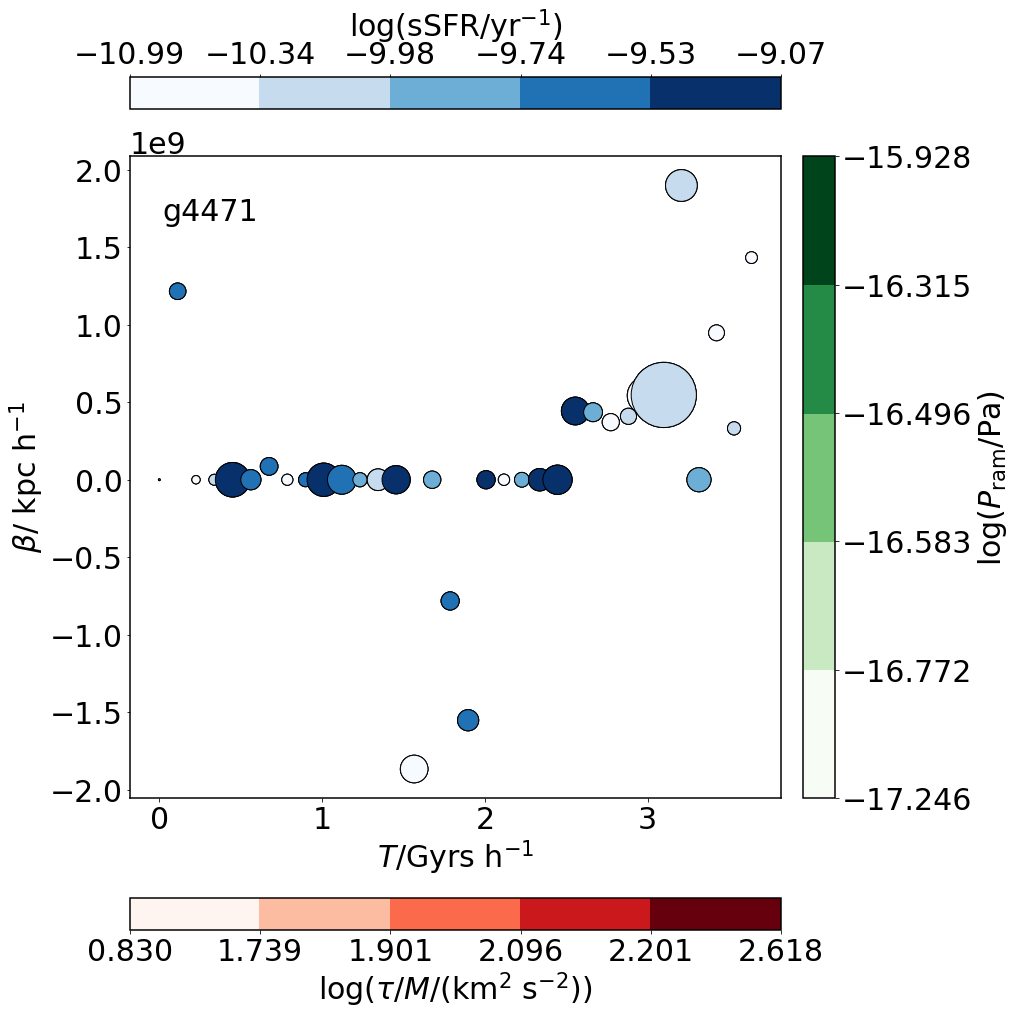

In [57]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 6)
papels = np.percentile(np.log10(TSt_4471/gMass_4471), vaper)
norm = mpco.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4471, Beta_4471, s=Gas_4471/5e5, c=np.log10(TSt_4471/gMass_4471), norm=norm, cmap=mpc.Reds, edgecolors='black')
barT = pl.colorbar(label='log($\\tau/M$/(km$^2$ s$^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4471), vaper)
norm2 = mpco.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4471, Beta_4471+0.5, s=Gas_4471/5e5, c=np.log10(RP_4471), norm=norm2, cmap=mpc.Greens, edgecolors='black')
barRP = pl.colorbar(label='$\log(P_{\\rm ram}$/Pa$)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4471/starMass_4471)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpco.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4471, Beta_4471+1., s=Gas_4471/5e5, c=lsSFR, norm=norm3, cmap=mpc.Blues, edgecolors='black')
bar3 = pl.colorbar(label='$\log($sSFR/yr$^{-1})$', location='top')
bar3.set_ticks(papels3)


xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[1]-deltay/10., 'g4471')

pl.ylabel('$\\beta/$ kpc h$^{-1}$')
pl.xlabel('$T$/Gyrs h$^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, '$T$/Gyrs h$^{-1}$')

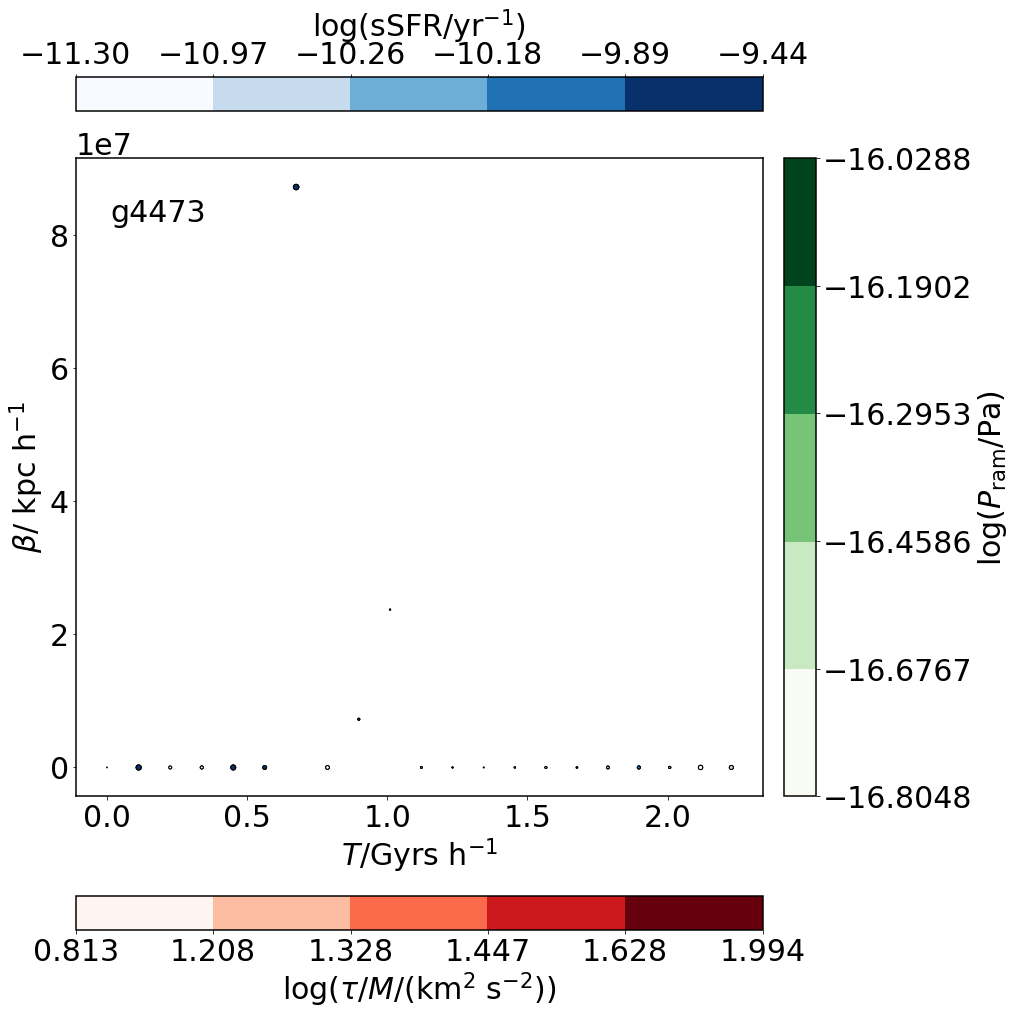

In [58]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 6)
papels = np.percentile(np.log10(TSt_4473/gMass_4473), vaper)
norm = mpco.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4473, Beta_4473, s=Gas_4473/5e5, c=np.log10(TSt_4473/gMass_4473), norm=norm, cmap=mpc.Reds, edgecolors='black')
barT = pl.colorbar(label='log($\\tau/M$/(km$^2$ s$^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4473), vaper)
norm2 = mpco.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4473, Beta_4473+0.5, s=Gas_4473/5e5, c=np.log10(RP_4473), norm=norm2, cmap=mpc.Greens, edgecolors='black')
barRP = pl.colorbar(label='$\log(P_{\\rm ram}$/Pa$)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4473/starMass_4473)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpco.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4473, Beta_4473+1., s=Gas_4473/5e5, c=lsSFR, norm=norm3, cmap=mpc.Blues, edgecolors='black')
bar3 = pl.colorbar(label='$\log($sSFR/yr$^{-1})$', location='top')
bar3.set_ticks(papels3)


xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[1]-deltay/10., 'g4473')

pl.ylabel('$\\beta/$ kpc h$^{-1}$')
pl.xlabel('$T$/Gyrs h$^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, '$T$/Gyrs h$^{-1}$')

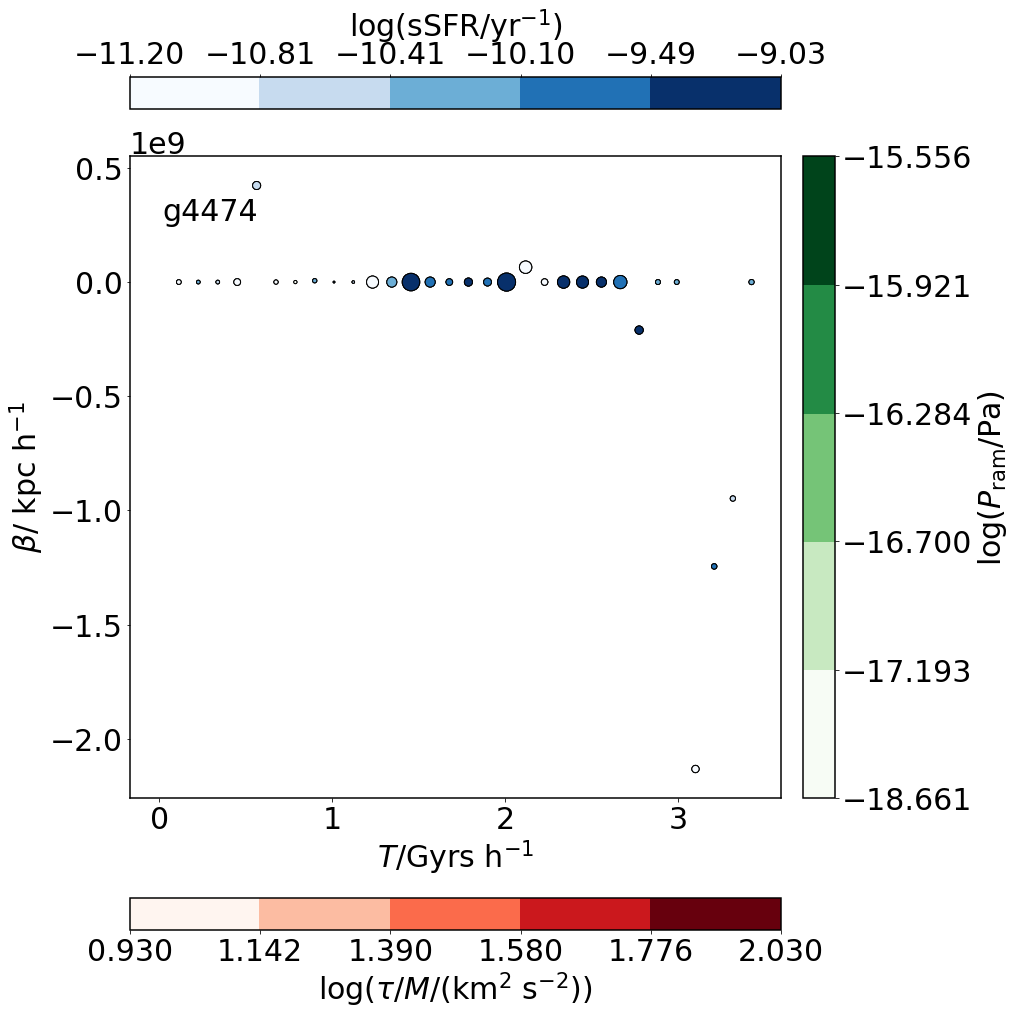

In [59]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 6)
papels = np.percentile(np.log10(TSt_4474/gMass_4474), vaper)
norm = mpco.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4474, Beta_4474, s=Gas_4474/5e5, c=np.log10(TSt_4474/gMass_4474), norm=norm, cmap=mpc.Reds, edgecolors='black')
barT = pl.colorbar(label='log($\\tau/M$/(km$^2$ s$^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4474), vaper)
norm2 = mpco.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4474, Beta_4474+0.5, s=Gas_4474/5e5, c=np.log10(RP_4474), norm=norm2, cmap=mpc.Greens, edgecolors='black')
barRP = pl.colorbar(label='$\log(P_{\\rm ram}$/Pa$)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4474/starMass_4474)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpco.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4474, Beta_4474+1., s=Gas_4474/5e5, c=lsSFR, norm=norm3, cmap=mpc.Blues, edgecolors='black')
bar3 = pl.colorbar(label='$\log($sSFR/yr$^{-1})$', location='top')
bar3.set_ticks(papels3)


xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[1]-deltay/10., 'g4474')

pl.ylabel('$\\beta/$ kpc h$^{-1}$')
pl.xlabel('$T$/Gyrs h$^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  This is separate from the ipykernel package so we can avoid doing imports until
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log10


(-10.0, 10.0)

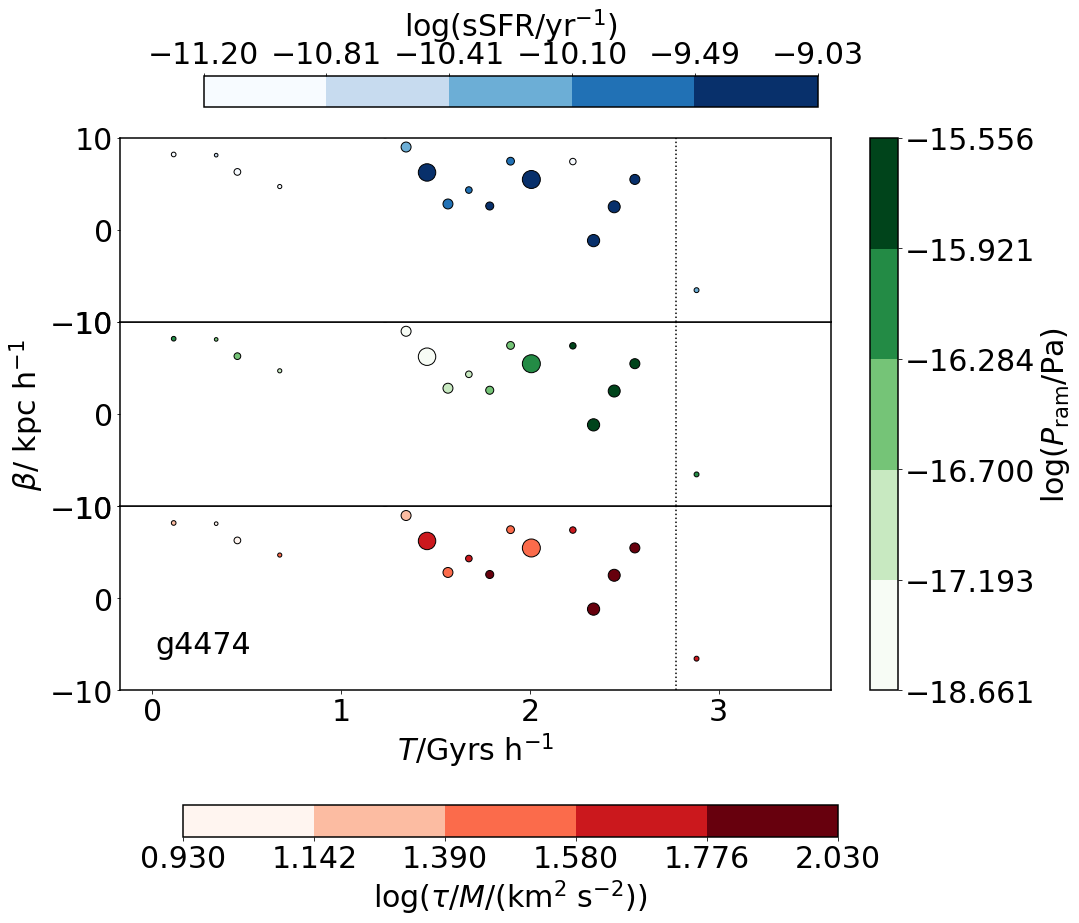

In [75]:
fig = pl.figure(figsize=(14,14), constrained_layout=True)

pl.subplots_adjust(hspace=0.)

vaper = np.linspace(0, 100, 6)
papels = np.percentile(np.log10(TSt_4474/gMass_4474), vaper)
norm = mpco.BoundaryNorm(boundaries=papels, ncolors=256)


ax1 = pl.subplot(3, 1, 3)

sc1 = pl.scatter(Time_4474, Beta_4474, s=Gas_4474/5e5, c=np.log10(TSt_4474/gMass_4474), norm=norm, cmap=mpc.Reds, edgecolors='black')
#barT = pl.colorbar(label='log($\\tau/M$/(km$^2$ s$^{-2})$)',location='bottom')
#barT.set_ticks(papels)
pl.axvline(Times_4474[t1_4474], c='black', ls=':')

papels2 = np.percentile(np.log10(RP_4474), vaper)
norm2 = mpco.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.xlabel('$T$/Gyrs h$^{-1}$')
# pl.ylabel('$\\beta/$ kpc h$^{-1}$', color='white')

pl.ylim(-10,10)

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]
# pl.ylabel('$\\beta/$ kpc h$^{-1}$', color='white')
# pl.xlabel('$T$/Gyrs h$^{-1}$', color='white')
pl.text(xlim[0]+deltax/20., ylim[0]+deltay/5., 'g4474')

ax2 = pl.subplot(3, 1, 2)

sc2 = pl.scatter(Time_4474, Beta_4474, s=Gas_4474/5e5, c=np.log10(RP_4474), norm=norm2, cmap=mpc.Greens, edgecolors='black')
# barRP = fig.colorbar(sc2, label='$\log(P_{\\rm ram}$/Pa$)$')#, location='right')
# barRP.set_ticks(papels2)
pl.axvline(Times_4474[t1_4474], c='black', ls=':')

lsSFR = np.log10(SFR_4474/starMass_4474)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

pl.ylabel('$\\beta/$ kpc h$^{-1}$')
# pl.xlabel('$T$/Gyrs h$^{-1}$', color='white')
pl.xticks((), ())

pl.ylim(-10,10)

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpco.BoundaryNorm(boundaries=papels3, ncolors=256)

ax3 = pl.subplot(3, 1, 1)

sc3 = pl.scatter(Time_4474, Beta_4474, s=Gas_4474/5e5, c=lsSFR, norm=norm3, cmap=mpc.Blues, edgecolors='black')
#bar3 = pl.colorbar(label='$\log($sSFR/yr$^{-1})$', location='top')
#bar3.set_ticks(papels3)
pl.xticks((), ())
pl.axvline(Times_4474[t1_4474], c='black', ls=':')


ax = [ax1, ax2, ax3]


cb2 = fig.colorbar(sc1, ax=ax, label='log($\\tau/M$/(km$^2$ s$^{-2})$)',location='bottom', fraction=0.043)
cb3 = fig.colorbar(sc3, ax=ax, label='$\log($sSFR/yr$^{-1})$', location='top', fraction=0.05)
cb1 = fig.colorbar(sc2, ax=ax, label='$\log(P_{\\rm ram}$/Pa$)$', location='right', fraction=0.04)

pl.ylim(-10,10)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  This is separate from the ipykernel package so we can avoid doing imports until
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log10


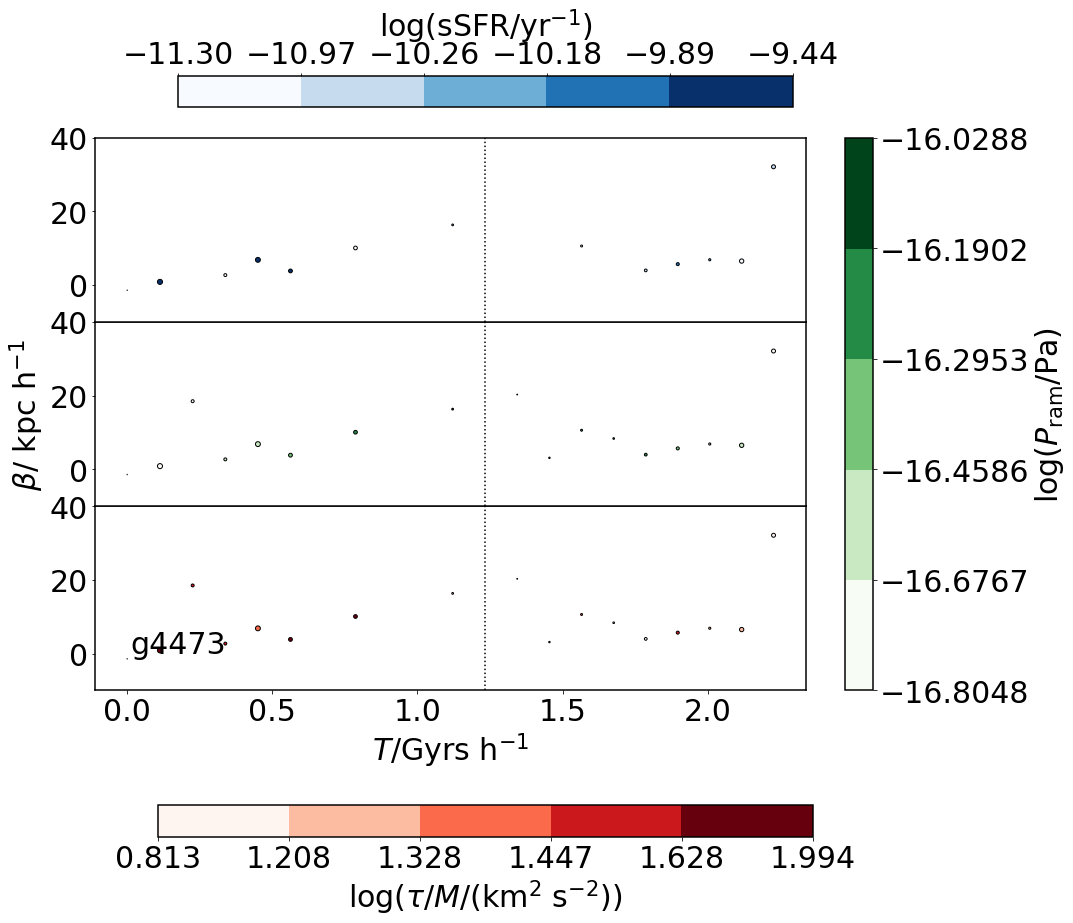

In [76]:
fig = pl.figure(figsize=(14,14), constrained_layout=True)

pl.subplots_adjust(hspace=0.)

vaper = np.linspace(0, 100, 6)
papels = np.percentile(np.log10(TSt_4473/gMass_4473), vaper)
norm = mpco.BoundaryNorm(boundaries=papels, ncolors=256)


ax1 = pl.subplot(3, 1, 3)

sc1 = pl.scatter(Time_4473, Beta_4473, s=Gas_4473/5e5, c=np.log10(TSt_4473/gMass_4473), norm=norm, cmap=mpc.Reds, edgecolors='black')
#barT = pl.colorbar(label='log($\\tau/M$/(km$^2$ s$^{-2})$)',location='bottom')
#barT.set_ticks(papels)
pl.axvline(Times_4473[t1_4473], c='black', ls=':')

papels2 = np.percentile(np.log10(RP_4473), vaper)
norm2 = mpco.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.xlabel('$T$/Gyrs h$^{-1}$')
# pl.ylabel('$\\beta/$ kpc h$^{-1}$', color='white')

pl.ylim(-10,40)

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]
# pl.ylabel('$\\beta/$ kpc h$^{-1}$', color='white')
# pl.xlabel('$T$/Gyrs h$^{-1}$', color='white')
pl.text(xlim[0]+deltax/20., ylim[0]+deltay/5., 'g4473')

ax2 = pl.subplot(3, 1, 2)

sc2 = pl.scatter(Time_4473, Beta_4473, s=Gas_4473/5e5, c=np.log10(RP_4473), norm=norm2, cmap=mpc.Greens, edgecolors='black')
# barRP = fig.colorbar(sc2, label='$\log(P_{\\rm ram}$/Pa$)$')#, location='right')
# barRP.set_ticks(papels2)
pl.axvline(Times_4473[t1_4473], c='black', ls=':')

lsSFR = np.log10(SFR_4473/starMass_4473)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

pl.ylabel('$\\beta/$ kpc h$^{-1}$')
# pl.xlabel('$T$/Gyrs h$^{-1}$', color='white')
pl.xticks((), ())

pl.ylim(-10,40)

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpco.BoundaryNorm(boundaries=papels3, ncolors=256)

ax3 = pl.subplot(3, 1, 1)

sc3 = pl.scatter(Time_4473, Beta_4473, s=Gas_4473/5e5, c=lsSFR, norm=norm3, cmap=mpc.Blues, edgecolors='black')
#bar3 = pl.colorbar(label='$\log($sSFR/yr$^{-1})$', location='top')
#bar3.set_ticks(papels3)
pl.xticks((), ())
pl.axvline(Times_4473[t1_4473], c='black', ls=':')


ax = [ax1, ax2, ax3]

pl.ylim(-10,40)

cb2 = fig.colorbar(sc1, ax=ax, label='log($\\tau/M$/(km$^2$ s$^{-2})$)',location='bottom', fraction=0.043)
cb3 = fig.colorbar(sc3, ax=ax, label='$\log($sSFR/yr$^{-1})$', location='top', fraction=0.05)
cb1 = fig.colorbar(sc2, ax=ax, label='$\log(P_{\\rm ram}$/Pa$)$', location='right', fraction=0.04)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  This is separate from the ipykernel package so we can avoid doing imports until


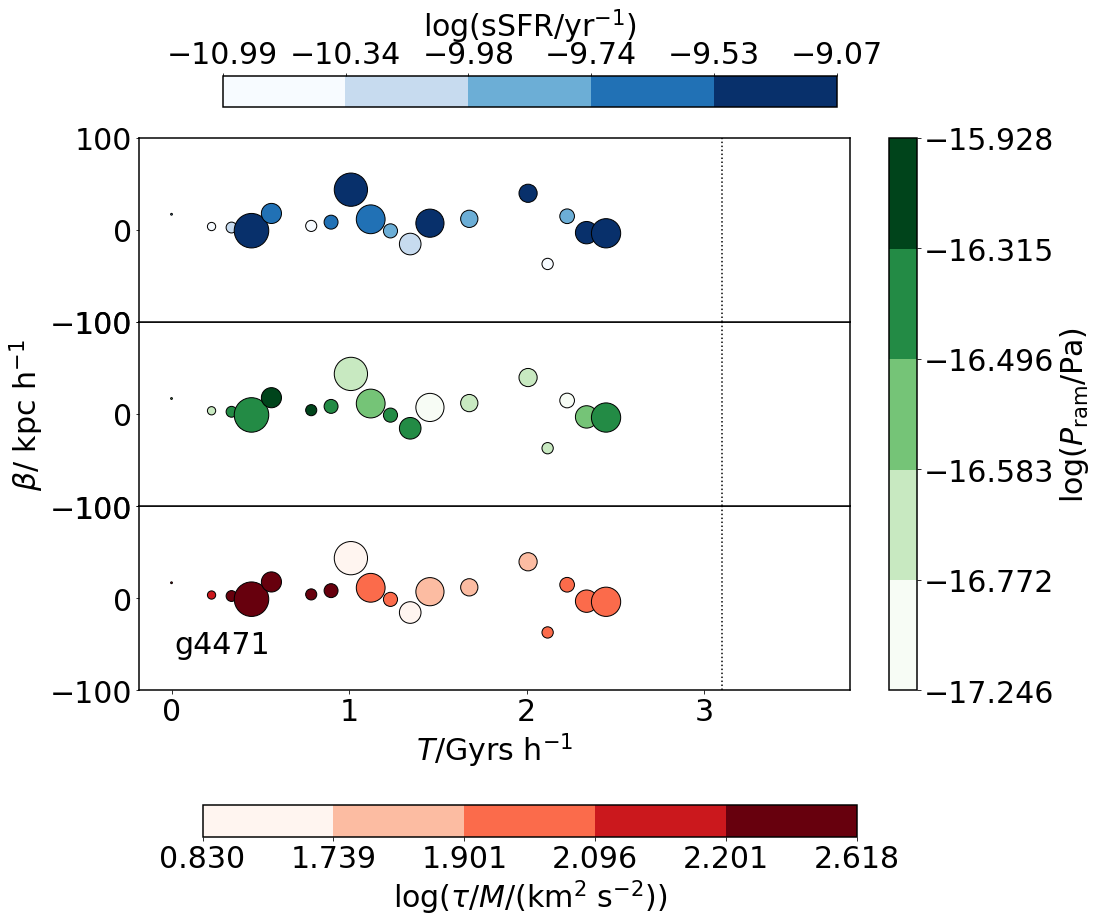

In [77]:
fig = pl.figure(figsize=(14,14), constrained_layout=True)

pl.subplots_adjust(hspace=0.)

vaper = np.linspace(0, 100, 6)
papels = np.percentile(np.log10(TSt_4471/gMass_4471), vaper)
norm = mpco.BoundaryNorm(boundaries=papels, ncolors=256)


ax1 = pl.subplot(3, 1, 3)

sc1 = pl.scatter(Time_4471, Beta_4471, s=Gas_4471/5e5, c=np.log10(TSt_4471/gMass_4471), norm=norm, cmap=mpc.Reds, edgecolors='black')
#barT = pl.colorbar(label='log($\\tau/M$/(km$^2$ s$^{-2})$)',location='bottom')
#barT.set_ticks(papels)
pl.axvline(Times_4471[t1_4471], c='black', ls=':')

papels2 = np.percentile(np.log10(RP_4471), vaper)
norm2 = mpco.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.xlabel('$T$/Gyrs h$^{-1}$')
# pl.ylabel('$\\beta/$ kpc h$^{-1}$', color='white')

pl.ylim(-100,100)

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]
# pl.ylabel('$\\beta/$ kpc h$^{-1}$', color='white')
# pl.xlabel('$T$/Gyrs h$^{-1}$', color='white')
pl.text(xlim[0]+deltax/20., ylim[0]+deltay/5., 'g4471')

ax2 = pl.subplot(3, 1, 2)

sc2 = pl.scatter(Time_4471, Beta_4471, s=Gas_4471/5e5, c=np.log10(RP_4471), norm=norm2, cmap=mpc.Greens, edgecolors='black')
# barRP = fig.colorbar(sc2, label='$\log(P_{\\rm ram}$/Pa$)$')#, location='right')
# barRP.set_ticks(papels2)
pl.axvline(Times_4471[t1_4471], c='black', ls=':')

lsSFR = np.log10(SFR_4471/starMass_4471)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

pl.ylabel('$\\beta/$ kpc h$^{-1}$')
# pl.xlabel('$T$/Gyrs h$^{-1}$', color='white')
pl.xticks((), ())



papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpco.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.ylim(-100,100)

ax3 = pl.subplot(3, 1, 1)

sc3 = pl.scatter(Time_4471, Beta_4471, s=Gas_4471/5e5, c=lsSFR, norm=norm3, cmap=mpc.Blues, edgecolors='black')
#bar3 = pl.colorbar(label='$\log($sSFR/yr$^{-1})$', location='top')
#bar3.set_ticks(papels3)
pl.xticks((), ())
pl.axvline(Times_4471[t1_4471], c='black', ls=':')


ax = [ax1, ax2, ax3]
pl.ylim(-100,100)

cb2 = fig.colorbar(sc1, ax=ax, label='log($\\tau/M$/(km$^2$ s$^{-2})$)',location='bottom', fraction=0.043)
cb3 = fig.colorbar(sc3, ax=ax, label='$\log($sSFR/yr$^{-1})$', location='top', fraction=0.05)
cb1 = fig.colorbar(sc2, ax=ax, label='$\log(P_{\\rm ram}$/Pa$)$', location='right', fraction=0.04)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  This is separate from the ipykernel package so we can avoid doing imports until
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log10


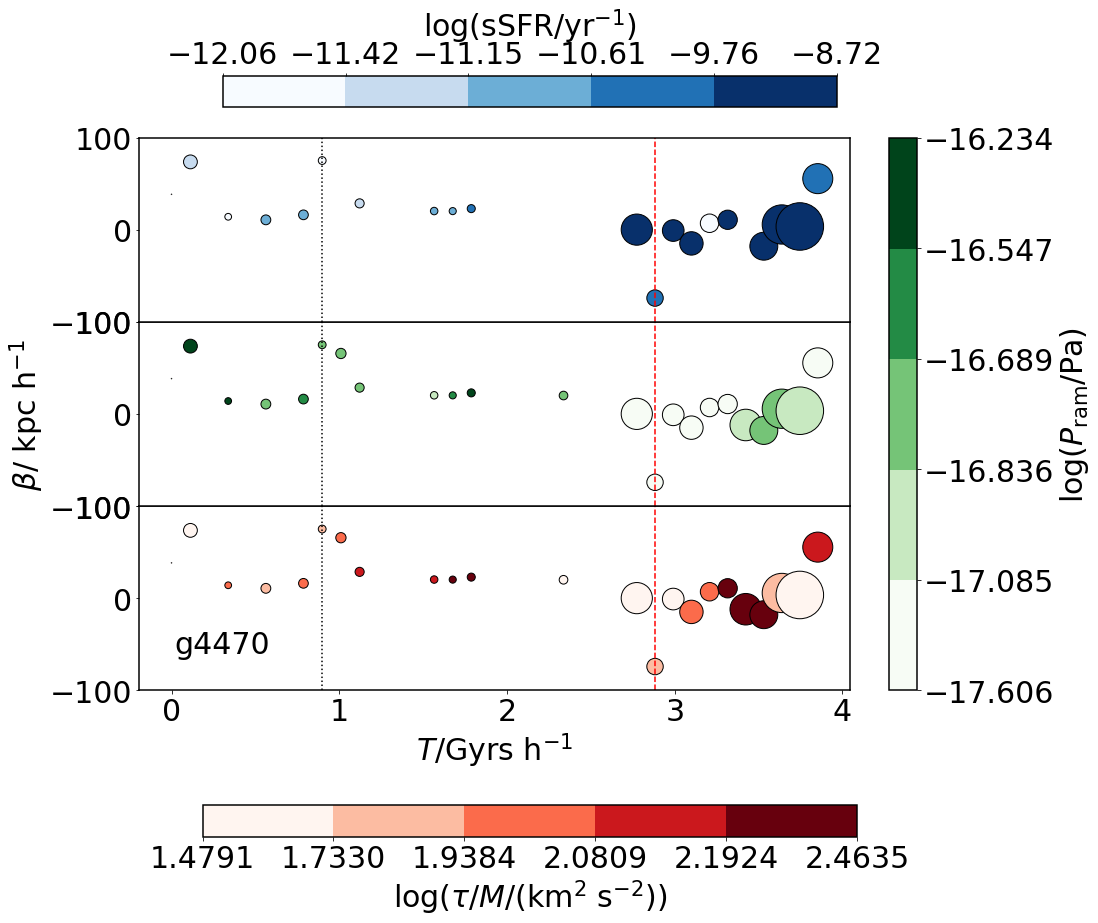

In [78]:
fig = pl.figure(figsize=(14,14), constrained_layout=True)

pl.subplots_adjust(hspace=0.)

vaper = np.linspace(0, 100, 6)
papels = np.percentile(np.log10(TSt_4470/gMass_4470), vaper)
norm = mpco.BoundaryNorm(boundaries=papels, ncolors=256)


ax1 = pl.subplot(3, 1, 3)

sc1 = pl.scatter(Time_4470, Beta_4470, s=Gas_4470/5e5, c=np.log10(TSt_4470/gMass_4470), norm=norm, cmap=mpc.Reds, edgecolors='black')
#barT = pl.colorbar(label='log($\\tau/M$/(km$^2$ s$^{-2})$)',location='bottom')
#barT.set_ticks(papels)
pl.axvline(Times_4470[t1_4470], c='black', ls=':')
pl.axvline(tmerger, c='red', ls='--')

papels2 = np.percentile(np.log10(RP_4470), vaper)
norm2 = mpco.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.xlabel('$T$/Gyrs h$^{-1}$')
# pl.ylabel('$\\beta/$ kpc h$^{-1}$', color='white')

pl.ylim(-100,100)

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]
# pl.ylabel('$\\beta/$ kpc h$^{-1}$', color='white')
# pl.xlabel('$T$/Gyrs h$^{-1}$', color='white')
pl.text(xlim[0]+deltax/20., ylim[0]+deltay/5., 'g4470')

ax2 = pl.subplot(3, 1, 2)

sc2 = pl.scatter(Time_4470, Beta_4470, s=Gas_4470/5e5, c=np.log10(RP_4470), norm=norm2, cmap=mpc.Greens, edgecolors='black')
# barRP = fig.colorbar(sc2, label='$\log(P_{\\rm ram}$/Pa$)$')#, location='right')
# barRP.set_ticks(papels2)
pl.axvline(Times_4470[t1_4470], c='black', ls=':')
pl.axvline(tmerger, c='red', ls='--')

lsSFR = np.log10(SFR_4470/starMass_4470)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

pl.ylabel('$\\beta/$ kpc h$^{-1}$')
# pl.xlabel('$T$/Gyrs h$^{-1}$', color='white')
pl.xticks((), ())

pl.ylim(-100,100)

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpco.BoundaryNorm(boundaries=papels3, ncolors=256)

ax3 = pl.subplot(3, 1, 1)

sc3 = pl.scatter(Time_4470, Beta_4470, s=Gas_4470/5e5, c=lsSFR, norm=norm3, cmap=mpc.Blues, edgecolors='black')
#bar3 = pl.colorbar(label='$\log($sSFR/yr$^{-1})$', location='top')
#bar3.set_ticks(papels3)
pl.xticks((), ())
pl.axvline(Times_4470[t1_4470], c='black', ls=':')
pl.axvline(tmerger, c='red', ls='--')

ax = [ax1, ax2, ax3]

pl.ylim(-100,100)

cb2 = fig.colorbar(sc1, ax=ax, label='log($\\tau/M$/(km$^2$ s$^{-2})$)',location='bottom', fraction=0.043)
cb3 = fig.colorbar(sc3, ax=ax, label='$\log($sSFR/yr$^{-1})$', location='top', fraction=0.05)
cb1 = fig.colorbar(sc2, ax=ax, label='$\log(P_{\\rm ram}$/Pa$)$', location='right', fraction=0.04)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  This is separate from the ipykernel package so we can avoid doing imports until
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log10


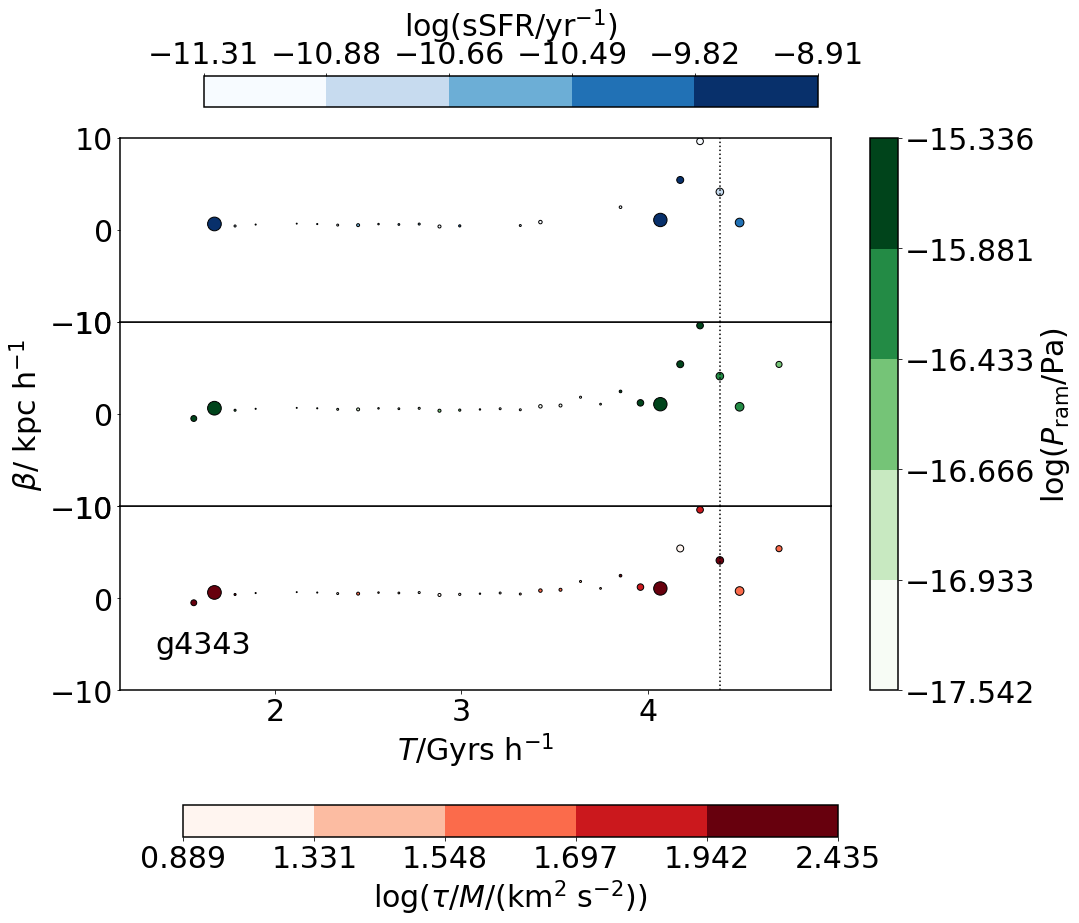

In [79]:
fig = pl.figure(figsize=(14,14), constrained_layout=True)

pl.subplots_adjust(hspace=0.)

vaper = np.linspace(0, 100, 6)
papels = np.percentile(np.log10(TSt_4343/gMass_4343), vaper)
norm = mpco.BoundaryNorm(boundaries=papels, ncolors=256)


ax1 = pl.subplot(3, 1, 3)

sc1 = pl.scatter(Time_4343, Beta_4343, s=Gas_4343/5e5, c=np.log10(TSt_4343/gMass_4343), norm=norm, cmap=mpc.Reds, edgecolors='black')
#barT = pl.colorbar(label='log($\\tau/M$/(km$^2$ s$^{-2})$)',location='bottom')
#barT.set_ticks(papels)
pl.axvline(Times_4343[t1_4343], c='black', ls=':')

papels2 = np.percentile(np.log10(RP_4343), vaper)
norm2 = mpco.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.xlabel('$T$/Gyrs h$^{-1}$')
# pl.ylabel('$\\beta/$ kpc h$^{-1}$', color='white')

pl.ylim(-10,10)

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]
# pl.ylabel('$\\beta/$ kpc h$^{-1}$', color='white')
# pl.xlabel('$T$/Gyrs h$^{-1}$', color='white')
pl.text(xlim[0]+deltax/20., ylim[0]+deltay/5., 'g4343')

ax2 = pl.subplot(3, 1, 2)

sc2 = pl.scatter(Time_4343, Beta_4343, s=Gas_4343/5e5, c=np.log10(RP_4343), norm=norm2, cmap=mpc.Greens, edgecolors='black')
# barRP = fig.colorbar(sc2, label='$\log(P_{\\rm ram}$/Pa$)$')#, location='right')
# barRP.set_ticks(papels2)
pl.axvline(Times_4343[t1_4343], c='black', ls=':')

lsSFR = np.log10(SFR_4343/starMass_4343)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

pl.ylabel('$\\beta/$ kpc h$^{-1}$')
# pl.xlabel('$T$/Gyrs h$^{-1}$', color='white')
pl.xticks((), ())


pl.ylim(-10,10)

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpco.BoundaryNorm(boundaries=papels3, ncolors=256)

ax3 = pl.subplot(3, 1, 1)

sc3 = pl.scatter(Time_4343, Beta_4343, s=Gas_4343/5e5, c=lsSFR, norm=norm3, cmap=mpc.Blues, edgecolors='black')
#bar3 = pl.colorbar(label='$\log($sSFR/yr$^{-1})$', location='top')
#bar3.set_ticks(papels3)
pl.xticks((), ())
pl.axvline(Times_4343[t1_4343], c='black', ls=':')
pl.xlim(xlim)
pl.ylim(ylim)

ax = [ax1, ax2, ax3]

pl.ylim(-10,10)


cb2 = fig.colorbar(sc1, ax=ax, label='log($\\tau/M$/(km$^2$ s$^{-2})$)',location='bottom', fraction=0.043)
cb3 = fig.colorbar(sc3, ax=ax, label='$\log($sSFR/yr$^{-1})$', location='top', fraction=0.05)
cb1 = fig.colorbar(sc2, ax=ax, label='$\log(P_{\\rm ram}$/Pa$)$', location='right', fraction=0.04)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  This is separate from the ipykernel package so we can avoid doing imports until
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log10


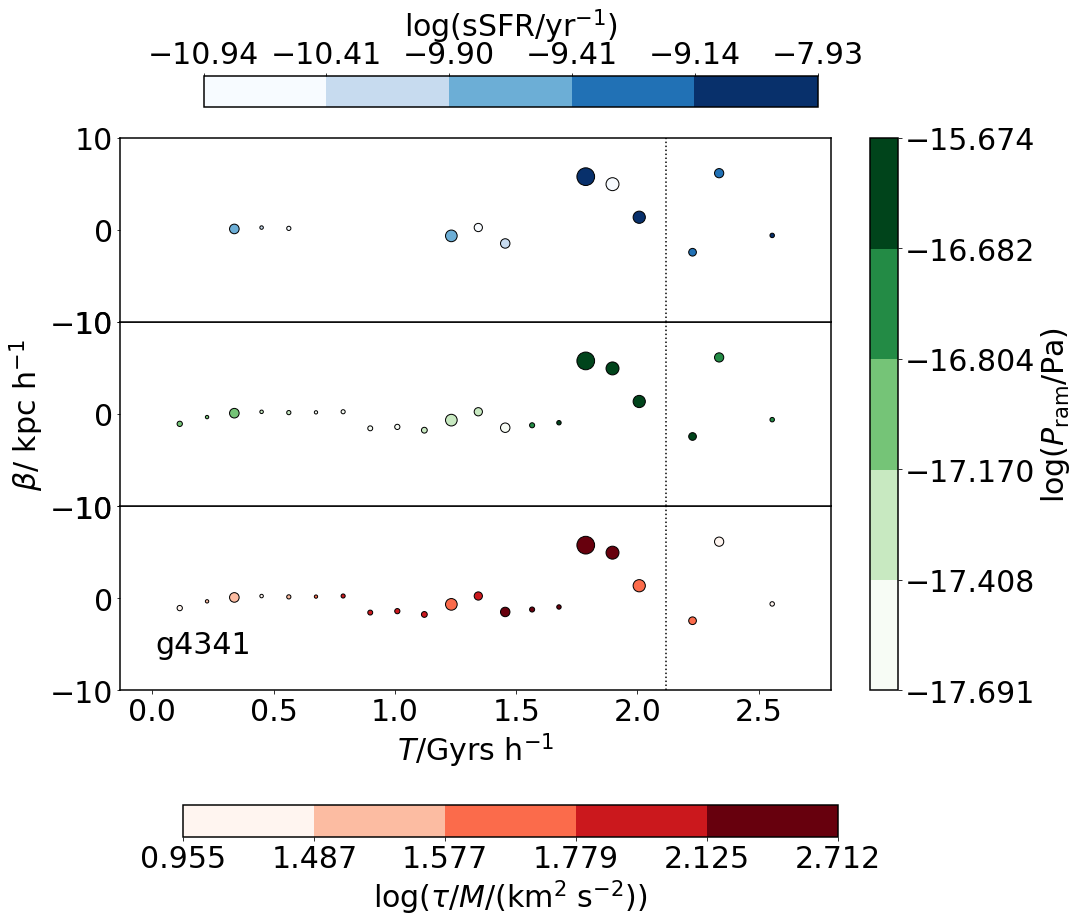

In [80]:
fig = pl.figure(figsize=(14,14), constrained_layout=True)

pl.subplots_adjust(hspace=0.)

vaper = np.linspace(0, 100, 6)
papels = np.percentile(np.log10(TSt_4341/gMass_4341), vaper)
norm = mpco.BoundaryNorm(boundaries=papels, ncolors=256)


ax1 = pl.subplot(3, 1, 3)

sc1 = pl.scatter(Time_4341, Beta_4341, s=Gas_4341/5e5, c=np.log10(TSt_4341/gMass_4341), norm=norm, cmap=mpc.Reds, edgecolors='black')
#barT = pl.colorbar(label='log($\\tau/M$/(km$^2$ s$^{-2})$)',location='bottom')
#barT.set_ticks(papels)
pl.axvline(Times_4341[t1_4341], c='black', ls=':')

papels2 = np.percentile(np.log10(RP_4341), vaper)
norm2 = mpco.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.xlabel('$T$/Gyrs h$^{-1}$')
# pl.ylabel('$\\beta/$ kpc h$^{-1}$', color='white')

pl.ylim(-10,10)

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]
# pl.ylabel('$\\beta/$ kpc h$^{-1}$', color='white')
# pl.xlabel('$T$/Gyrs h$^{-1}$', color='white')
pl.text(xlim[0]+deltax/20., ylim[0]+deltay/5., 'g4341')

ax2 = pl.subplot(3, 1, 2)

sc2 = pl.scatter(Time_4341, Beta_4341, s=Gas_4341/5e5, c=np.log10(RP_4341), norm=norm2, cmap=mpc.Greens, edgecolors='black')
# barRP = fig.colorbar(sc2, label='$\log(P_{\\rm ram}$/Pa$)$')#, location='right')
# barRP.set_ticks(papels2)
pl.axvline(Times_4341[t1_4341], c='black', ls=':')

lsSFR = np.log10(SFR_4341/starMass_4341)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

pl.ylabel('$\\beta/$ kpc h$^{-1}$')
# pl.xlabel('$T$/Gyrs h$^{-1}$', color='white')
pl.xticks((), ())

pl.ylim(-10,10)

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpco.BoundaryNorm(boundaries=papels3, ncolors=256)

ax3 = pl.subplot(3, 1, 1)

sc3 = pl.scatter(Time_4341, Beta_4341, s=Gas_4341/5e5, c=lsSFR, norm=norm3, cmap=mpc.Blues, edgecolors='black')
#bar3 = pl.colorbar(label='$\log($sSFR/yr$^{-1})$', location='top')
#bar3.set_ticks(papels3)
pl.xticks((), ())
pl.axvline(Times_4341[t1_4341], c='black', ls=':')

pl.xlim(xlim)
pl.ylim(ylim)

ax = [ax1, ax2, ax3]
pl.ylim(-10,10)

cb2 = fig.colorbar(sc1, ax=ax, label='log($\\tau/M$/(km$^2$ s$^{-2})$)',location='bottom', fraction=0.043)
cb3 = fig.colorbar(sc3, ax=ax, label='$\log($sSFR/yr$^{-1})$', location='top', fraction=0.05)
cb1 = fig.colorbar(sc2, ax=ax, label='$\log(P_{\\rm ram}$/Pa$)$', location='right', fraction=0.04)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  This is separate from the ipykernel package so we can avoid doing imports until
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log10


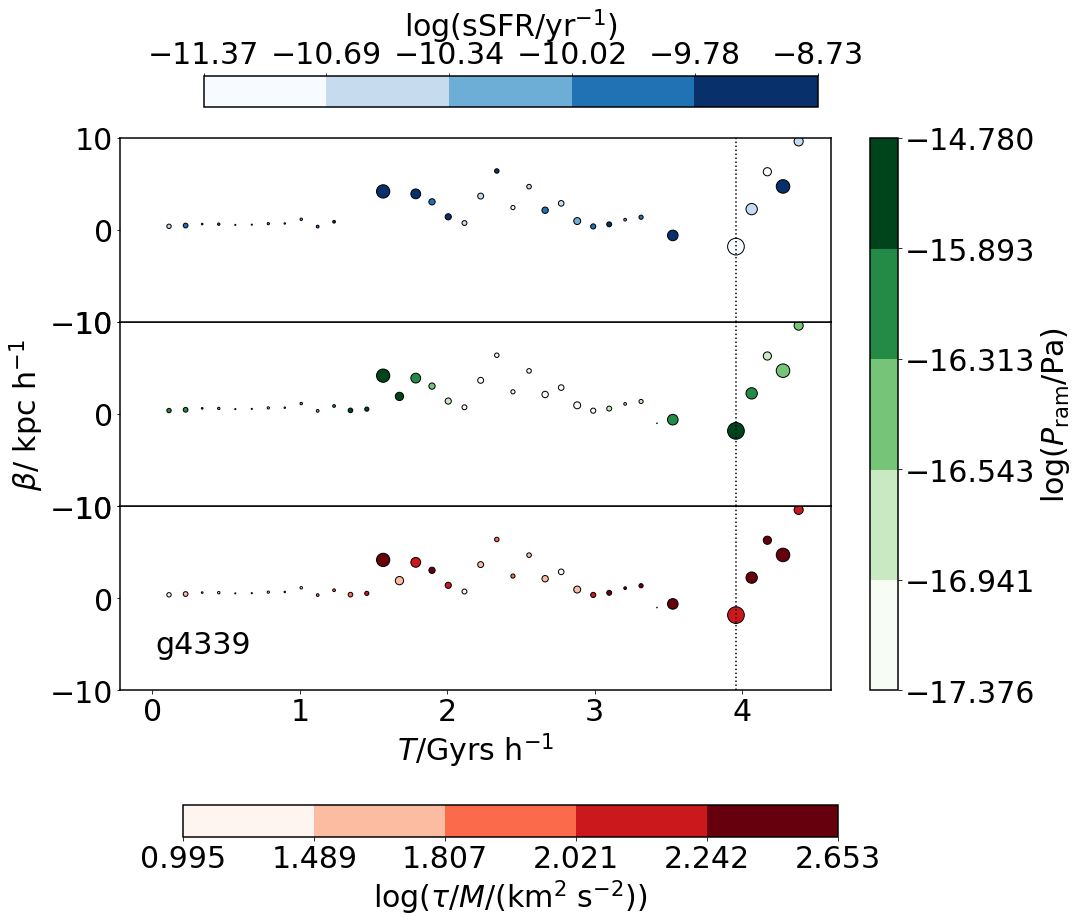

In [81]:
fig = pl.figure(figsize=(14,14), constrained_layout=True)

pl.subplots_adjust(hspace=0.)

vaper = np.linspace(0, 100, 6)
papels = np.percentile(np.log10(TSt_4339/gMass_4339), vaper)
norm = mpco.BoundaryNorm(boundaries=papels, ncolors=256)


ax1 = pl.subplot(3, 1, 3)

sc1 = pl.scatter(Time_4339, Beta_4339, s=Gas_4339/5e5, c=np.log10(TSt_4339/gMass_4339), norm=norm, cmap=mpc.Reds, edgecolors='black')
#barT = pl.colorbar(label='log($\\tau/M$/(km$^2$ s$^{-2})$)',location='bottom')
#barT.set_ticks(papels)
pl.axvline(Times_4339[t1_4339], c='black', ls=':')

papels2 = np.percentile(np.log10(RP_4339), vaper)
norm2 = mpco.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.xlabel('$T$/Gyrs h$^{-1}$')
# pl.ylabel('$\\beta/$ kpc h$^{-1}$', color='white')

pl.ylim(-10,10)

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]
# pl.ylabel('$\\beta/$ kpc h$^{-1}$', color='white')
# pl.xlabel('$T$/Gyrs h$^{-1}$', color='white')
pl.text(xlim[0]+deltax/20., ylim[0]+deltay/5., 'g4339')

ax2 = pl.subplot(3, 1, 2)

sc2 = pl.scatter(Time_4339, Beta_4339, s=Gas_4339/5e5, c=np.log10(RP_4339), norm=norm2, cmap=mpc.Greens, edgecolors='black')
# barRP = fig.colorbar(sc2, label='$\log(P_{\\rm ram}$/Pa$)$')#, location='right')
# barRP.set_ticks(papels2)
pl.axvline(Times_4339[t1_4339], c='black', ls=':')

lsSFR = np.log10(SFR_4339/starMass_4339)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

pl.ylabel('$\\beta/$ kpc h$^{-1}$')
# pl.xlabel('$T$/Gyrs h$^{-1}$', color='white')
pl.xticks((), ())

pl.ylim(-10,10)

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpco.BoundaryNorm(boundaries=papels3, ncolors=256)

ax3 = pl.subplot(3, 1, 1)

sc3 = pl.scatter(Time_4339, Beta_4339, s=Gas_4339/5e5, c=lsSFR, norm=norm3, cmap=mpc.Blues, edgecolors='black')
#bar3 = pl.colorbar(label='$\log($sSFR/yr$^{-1})$', location='top')
#bar3.set_ticks(papels3)
pl.xticks((), ())
pl.axvline(Times_4339[t1_4339], c='black', ls=':')

pl.ylim(-10,10)
ax = [ax1, ax2, ax3]


cb2 = fig.colorbar(sc1, ax=ax, label='log($\\tau/M$/(km$^2$ s$^{-2})$)',location='bottom', fraction=0.043)
cb3 = fig.colorbar(sc3, ax=ax, label='$\log($sSFR/yr$^{-1})$', location='top', fraction=0.05)
cb1 = fig.colorbar(sc2, ax=ax, label='$\log(P_{\\rm ram}$/Pa$)$', location='right', fraction=0.04)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  This is separate from the ipykernel package so we can avoid doing imports until
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log10


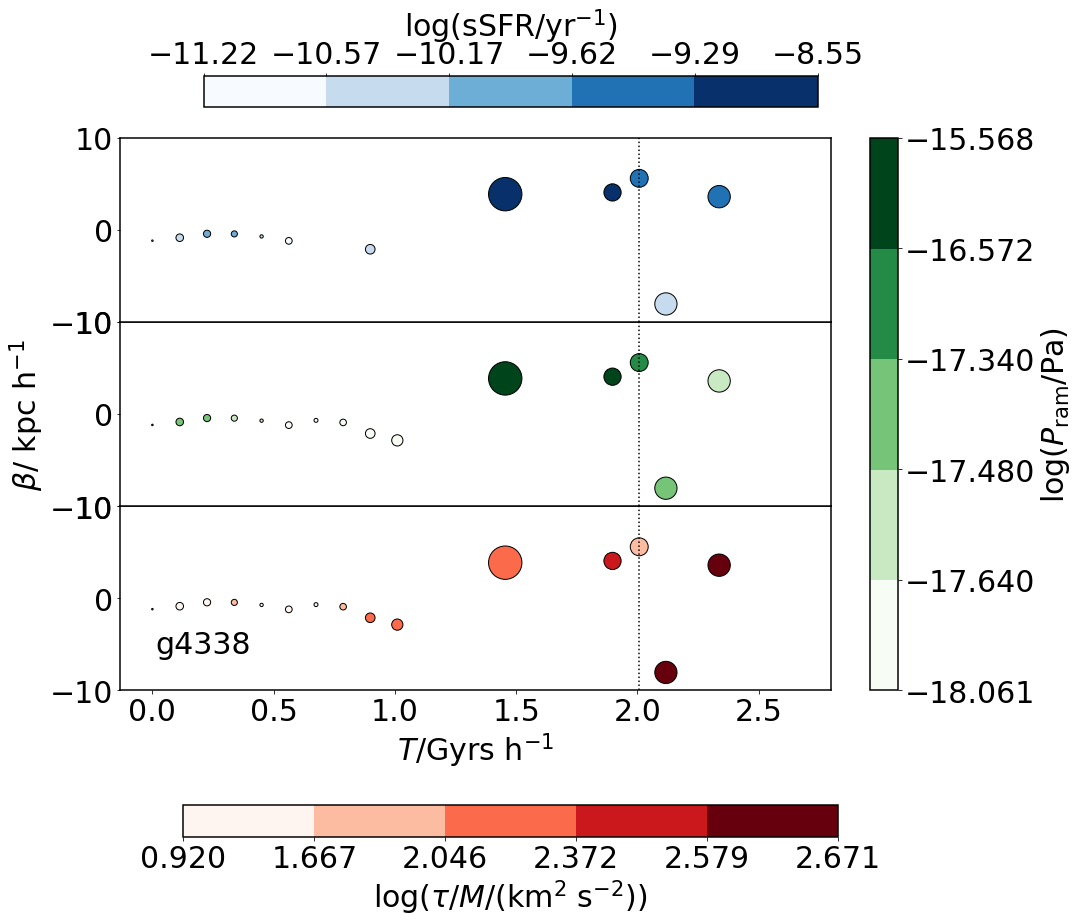

In [82]:
fig = pl.figure(figsize=(14,14), constrained_layout=True)

pl.subplots_adjust(hspace=0.)

vaper = np.linspace(0, 100, 6)
papels = np.percentile(np.log10(TSt_4338/gMass_4338), vaper)
norm = mpco.BoundaryNorm(boundaries=papels, ncolors=256)


ax1 = pl.subplot(3, 1, 3)

sc1 = pl.scatter(Time_4338, Beta_4338, s=Gas_4338/5e5, c=np.log10(TSt_4338/gMass_4338), norm=norm, cmap=mpc.Reds, edgecolors='black')
#barT = pl.colorbar(label='log($\\tau/M$/(km$^2$ s$^{-2})$)',location='bottom')
#barT.set_ticks(papels)
pl.axvline(Times_4338[t1_4338], c='black', ls=':')

papels2 = np.percentile(np.log10(RP_4338), vaper)
norm2 = mpco.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.xlabel('$T$/Gyrs h$^{-1}$')
# pl.ylabel('$\\beta/$ kpc h$^{-1}$', color='white')

pl.ylim(-10,10)

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]
# pl.ylabel('$\\beta/$ kpc h$^{-1}$', color='white')
# pl.xlabel('$T$/Gyrs h$^{-1}$', color='white')
pl.text(xlim[0]+deltax/20., ylim[0]+deltay/5., 'g4338')

ax2 = pl.subplot(3, 1, 2)

sc2 = pl.scatter(Time_4338, Beta_4338, s=Gas_4338/5e5, c=np.log10(RP_4338), norm=norm2, cmap=mpc.Greens, edgecolors='black')
# barRP = fig.colorbar(sc2, label='$\log(P_{\\rm ram}$/Pa$)$')#, location='right')
# barRP.set_ticks(papels2)
pl.axvline(Times_4338[t1_4338], c='black', ls=':')

lsSFR = np.log10(SFR_4338/starMass_4338)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

pl.ylabel('$\\beta/$ kpc h$^{-1}$')
# pl.xlabel('$T$/Gyrs h$^{-1}$', color='white')
pl.xticks((), ())

pl.ylim(-10,10)

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpco.BoundaryNorm(boundaries=papels3, ncolors=256)

ax3 = pl.subplot(3, 1, 1)

sc3 = pl.scatter(Time_4338, Beta_4338, s=Gas_4338/5e5, c=lsSFR, norm=norm3, cmap=mpc.Blues, edgecolors='black')
#bar3 = pl.colorbar(label='$\log($sSFR/yr$^{-1})$', location='top')
#bar3.set_ticks(papels3)
pl.xticks((), ())
pl.axvline(Times_4338[t1_4338], c='black', ls=':')

pl.ylim(-10,10)
ax = [ax1, ax2, ax3]


cb2 = fig.colorbar(sc1, ax=ax, label='log($\\tau/M$/(km$^2$ s$^{-2})$)',location='bottom', fraction=0.043)
cb3 = fig.colorbar(sc3, ax=ax, label='$\log($sSFR/yr$^{-1})$', location='top', fraction=0.05)
cb1 = fig.colorbar(sc2, ax=ax, label='$\log(P_{\\rm ram}$/Pa$)$', location='right', fraction=0.04)